## Required packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import networkx as nx

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import pairwise_distances
import gudhi as gd
import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence

import pickle as pkl

import datetime

## Data cleaning

In [ ]:
df = pd.read_pickle("data.pkl")
df = pd.DataFrame.from_dict(df, orient = "index")
df = df.transpose()
print(type(df["obs_tas"][1]))
print(type(df["obs_pr"][1]))
df

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


flow                                            obs_tas flow_dates  \
0      1.723781  [-10.600000381469727, -9.699999809265137, -6.6... 1958-01-04   
1      0.960882  [-20.5, -19.100000381469727, -12.0, -17.700000... 1958-01-05   
2         0.001  [-23.600000381469727, -22.5, -15.1000003814697... 1958-01-06   
3         0.001  [-16.200000762939453, -16.0, -14.1000003814697... 1958-01-07   
4      0.316796  [-7.900000095367432, -7.800000190734863, -9.5,... 1958-01-08   
...         ...                                                ...        ...   
21541  1.812796  [-12.5, -11.699999809265137, -8.60000038146972... 2016-12-26   
21542      None  [-12.5, -11.899999618530273, -9.10000038146972...        NaT   
21543      None  [-11.899999618530273, -11.399999618530273, -8....        NaT   
21544      None  [-7.0, -6.5, -3.4000000953674316, -5.900000095...        NaT   
21545      None  [-2.4000000953674316, -2.0999999046325684, 1.2...        NaT   

      obs_lon_lat                                             obs_pr  \
0            9.37  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10000000...   
1           60.23  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20000000...   
2            None  [0.10000000149011612, 0.0, 0.30000001192092896...   
3            None  [1.0, 0.0, 1.0, 1.100000023841858, 0.899999976...   
4            None  [9.300000190734863, 8.600000381469727, 8.0, 8....   
...           ...                                                ...   
21541        None  [2.200000047683716, 0.10000000149011612, 1.100...   
21542        None  [5.5, 4.900000095367432, 8.300000190734863, 6....   
21543        None  [1.7999999523162842, 1.7000000476837158, 2.099...   
21544        None  [4.099999904632568, 3.5, 4.599999904632568, 5....   
21545        None  [6.400000095367432, 7.400000095367432, 8.5, 8....   

       obs_dates  
0     1957-01-01  
1     1957-01-02  
2     1957-01-03  
3     1957-01-04  
4     1957-01-05  
...          ...  
21541 2015-12-27  
21542 2015-12-28  
21543 2015-12-29  
21544 2015-12-30  
21545 2015-12-31  

[21546 rows x 6 columns]

In [ ]:
obs_pr = pd.DataFrame()


for i in range(len(df["obs_pr"])):
    df1 = pd.DataFrame(df["obs_pr"][i]).T
    obs_pr = pd.concat([obs_pr, df1])

obs_pr.columns = ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"]
obs_pr

r1   r2   r3   r4   r5    r6   r7    r8   r9
0   0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.1  0.1
0   0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.2  0.1
0   0.1  0.0  0.3  0.1  0.3   0.3  0.4   0.3  0.5
0   1.0  0.0  1.0  1.1  0.9   0.7  0.8   0.4  0.6
0   9.3  8.6  8.0  8.9  8.7  10.2  9.3  10.1  9.7
..  ...  ...  ...  ...  ...   ...  ...   ...  ...
0   2.2  0.1  1.1  1.5  0.1   0.0  0.0   0.0  0.0
0   5.5  4.9  8.3  6.1  3.7   5.0  5.4   0.0  5.1
0   1.8  1.7  2.1  2.7  0.2   0.8  2.2   0.0  0.0
0   4.1  3.5  4.6  5.1  3.5   3.4  3.2   0.0  3.6
0   6.4  7.4  8.5  8.4  8.4   9.8  7.9  10.0  8.1

[21546 rows x 9 columns]

In [ ]:
obs_tas = pd.DataFrame()


for i in range(len(df["obs_tas"])):
    df1 = pd.DataFrame(df["obs_tas"][i]).T
    obs_tas = pd.concat([obs_tas, df1])

obs_tas.columns = ["r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"]
obs_tas

r1    r2    r3         r4         r5         r6    r7    r8    r9
0  -10.600000  -9.7  -6.7  -8.800000  -8.900000  -7.500000  -8.1  -6.5  -5.4
0  -20.500000 -19.1 -12.0 -17.700001 -17.700001 -13.100000 -15.5 -11.8  -9.1
0  -23.600000 -22.5 -15.1 -21.400000 -21.400000 -16.299999 -19.4 -14.6 -12.2
0  -16.200001 -16.0 -14.1 -15.600000 -15.400000 -14.500000 -15.0 -13.8 -11.9
0   -7.900000  -7.8  -9.5  -7.600000  -7.500000  -8.000000  -7.4  -8.6  -8.2
..        ...   ...   ...        ...        ...        ...   ...   ...   ...
0  -12.500000 -11.7  -8.6 -11.000000 -10.900000  -9.200000  -9.7  -8.4  -7.5
0  -12.500000 -11.9  -9.1 -11.400000 -11.200000  -9.800000 -10.6  -8.6  -7.5
0  -11.900000 -11.4  -8.4 -10.800000 -10.800000  -8.600000  -9.3  -7.2  -6.3
0   -7.000000  -6.5  -3.4  -5.900000  -6.100000  -4.800000  -5.0  -3.8  -3.0
0   -2.400000  -2.1   1.3  -1.500000  -1.800000  -0.800000  -0.9   0.5   1.1

[21546 rows x 9 columns]

In [ ]:
obs_tas = obs_tas.reset_index(drop= True)
a = df["obs_dates"]
obs_tas["date"] = a
obs_pr = obs_pr.reset_index(drop = True)
obs_pr["date"] = a
target = pd.DataFrame()
target["flow"] = df["flow"]
target["date"] = df["flow_dates"]

In [ ]:
temp = obs_tas
prec = obs_pr


temp = temp[temp["date"] >= "1958-01-04"]
prec = prec[prec["date"] >= "1958-01-04"]
target = target[target["date"] < "2016-01-01"]
temp.set_index("date", inplace=True)
prec.set_index("date", inplace=True)
target.set_index("date", inplace=True)

df = target.join(temp, rsuffix=("_temp"))
df = df.join(prec, rsuffix= ("_prec"))

df.dropna(inplace=True)

df.columns = ["flow", "r1_temp", "r2_temp", "r3_temp", "r4_temp", "r5_temp",
    "r6_temp", "r7_temp", "r8_temp", "r9_temp", "r1_prec", "r2_prec", "r3_prec", "r4_prec", "r5_prec", "r6_prec", "r7_prec", "r8_prec", "r9_prec"]

df.reset_index(inplace=True)


df['date'] = pd.to_datetime(df['date'])
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day 

df["Season"] = 0

for i in range(len(df["Month"])):
    if df["Month"][i] in [1, 2, 3]:
        df["Season"][i] = "Winter"
    elif df["Month"][i] in [4, 5, 6]:
        df["Season"][i] = "Spring"
    elif df["Month"][i] in [7, 8, 9]:
        df["Season"][i] = "Summer"
    elif df["Month"][i] in [10, 11, 12]:
        df["Season"][i] = "Fall"


C:\Users\herna\AppData\Local\Temp/ipykernel_12908/3562531571.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\herna\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
def plot_seasonal_time_series(data, season, year, var):
    frame = data[(data["Season"] == season) & (data["Year"] == year)]
    
    if var == "Temp":
        frame = frame[["r1_temp", "r2_temp", "r3_temp", "r4_temp", "r5_temp", "r6_temp", "r7_temp", "r8_temp", "r9_temp", "date", "Month"]]
    elif var == "Prec":
        frame = frame[["r1_prec", "r2_prec", "r3_prec", "r4_prec", "r5_prec", "r6_prec", "r7_prec", "r8_prec", "r9_prec", "date", "Month"]]

    fig, axs = plt.subplots(3, 3, figsize = (40,10), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = .2, wspace=.09)
    axs = axs.ravel()

    frame_cols = frame.columns

    for i in range(len(frame_cols)):
        if i == 9:
            break
        else:
            frame[frame_cols[i]].groupby(frame["Month"]).plot(ax = axs[i])
            axs[i].set_title(frame_cols[i])

    plt.show()

def plot_seasonal_scatterplot(data, season, year):
    frame = data[(data["Season"] == season) & (data["Year"] == year)]

    prec = ["r1_prec", "r2_prec", "r3_prec", "r4_prec", "r5_prec", "r6_prec", "r7_prec", "r8_prec", "r9_prec"]
    temp = ["r1_temp", "r2_temp", "r3_temp", "r4_temp", "r5_temp", "r6_temp", "r7_temp", "r8_temp", "r9_temp"]

    fig, axs = plt.subplots(3, 3, figsize = (20,20), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = .2, wspace=.09)
    axs = axs.ravel()


    for i in range(9):
        if i == 9:
            break
        else:
            frame.groupby(frame["Month"]).plot.scatter(prec[i], temp[i], ax = axs[i])

    plt.show()

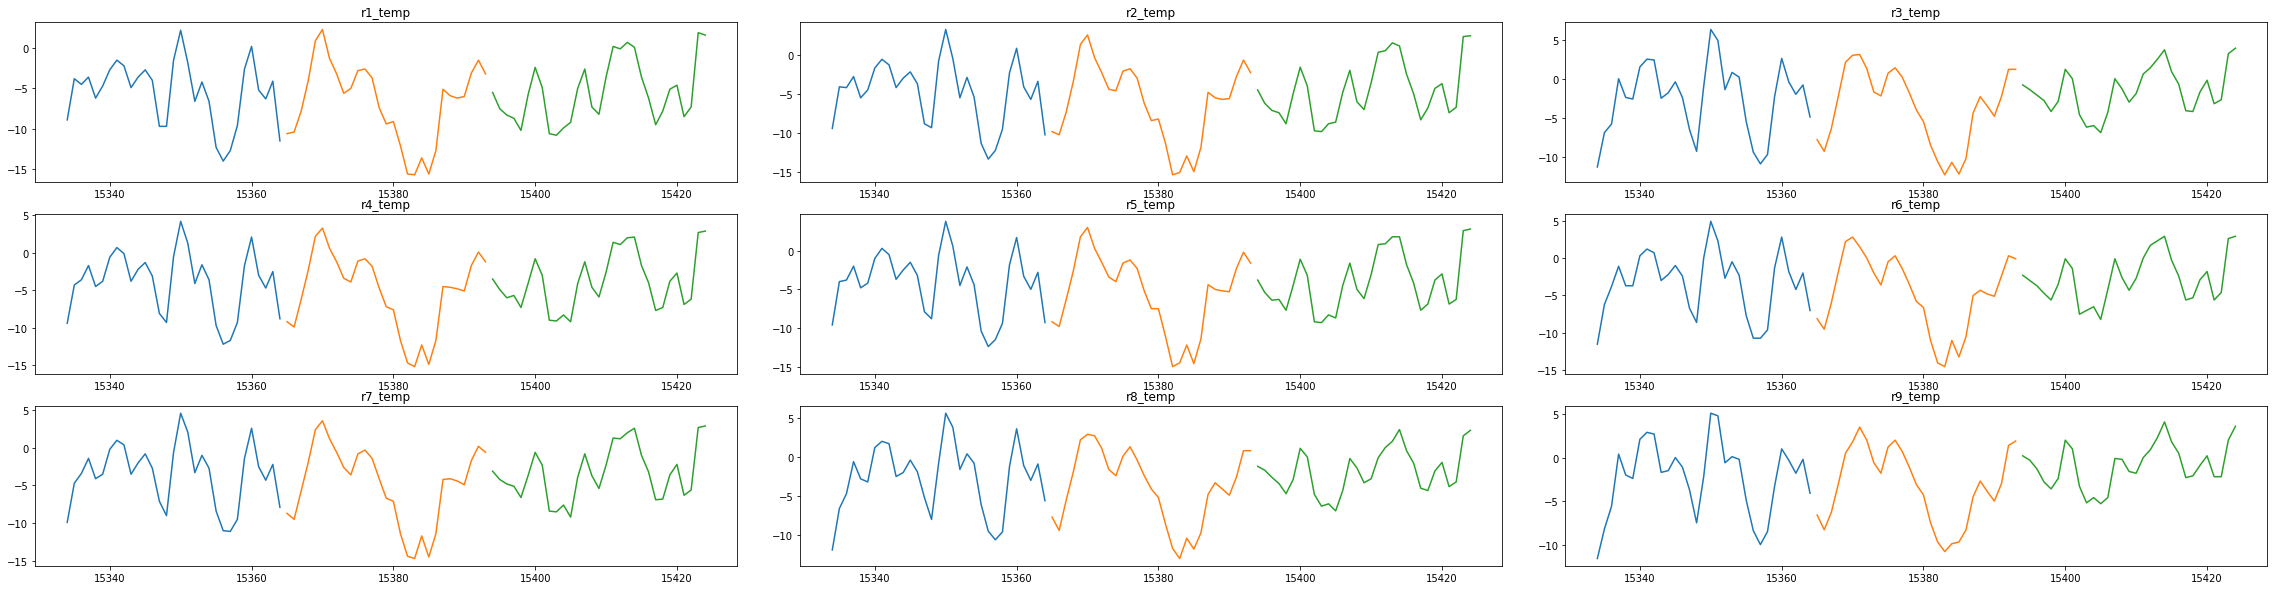

In [ ]:
plot_seasonal_time_series(df, "Winter", 2000, "Temp")

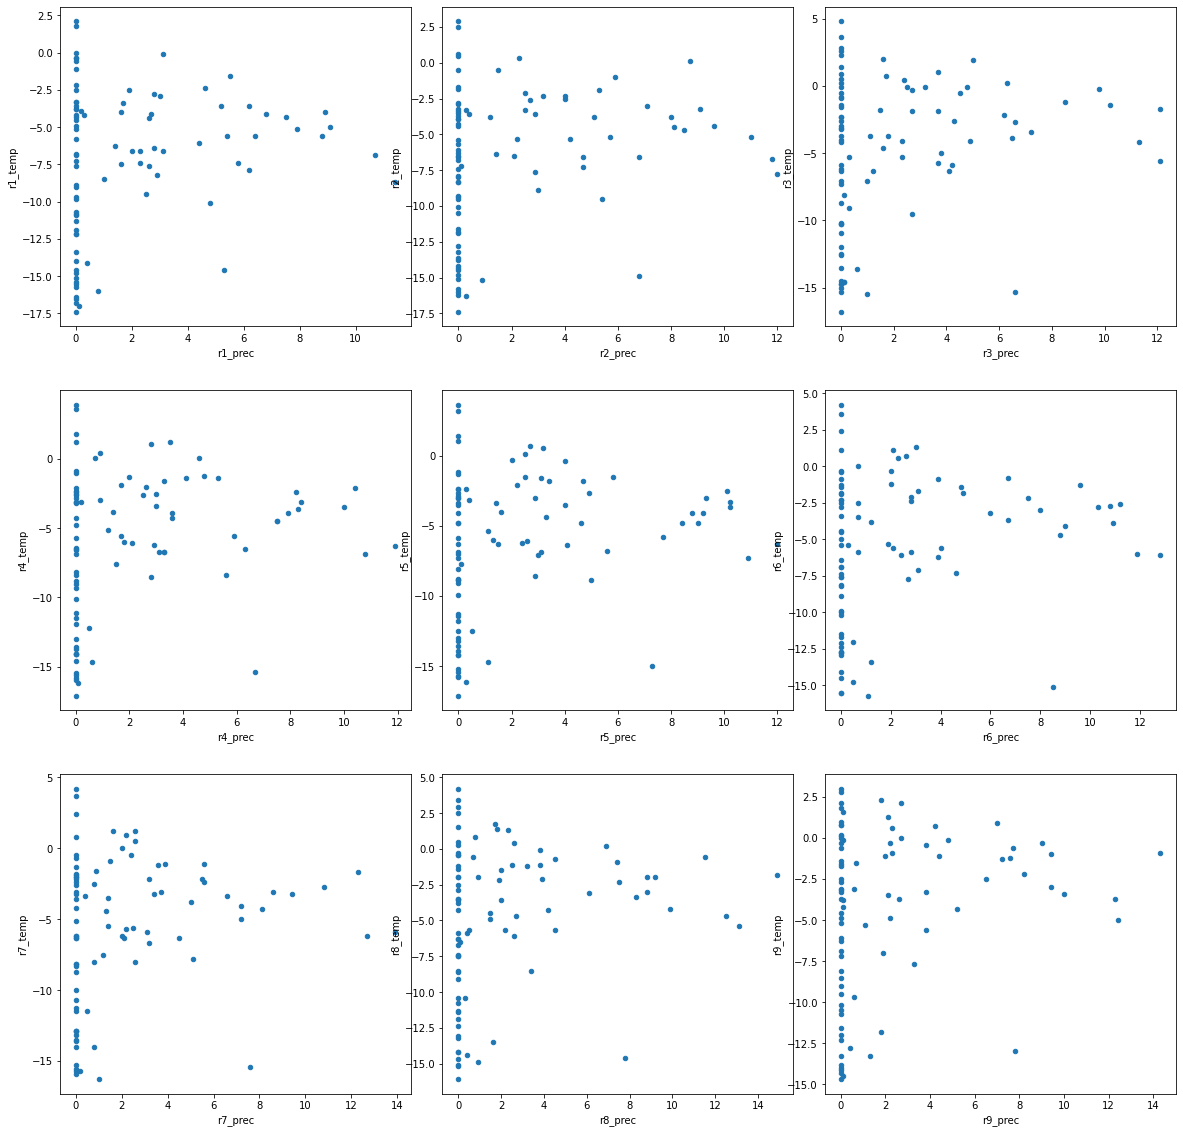

In [ ]:
plot_seasonal_scatterplot(df, "Winter", 1999)

In [ ]:
df = pd.read_csv("C:/Users/brend/Desktop/TDA-ClimateAI/final_db.csv")

## Time series and periodicity

### Using all data

In [ ]:
x = df["date"]
y = df["r1_temp"]

fig = go.Figure(data=go.Scatter(x=x, y=y))
fig.update_layout(xaxis_title="Timestamp", yaxis_title="Amplitude")
fig.show()

In [ ]:
max_embedding_dimension = 2
max_time_delay = 1000
stride = 30

embedder_periodic = SingleTakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dimension,
    n_jobs=2,
    stride=stride,
)

def fit_embedder(embedder: SingleTakensEmbedding, y: np.ndarray, verbose: bool=True) -> np.ndarray:
    """Fits a Takens embedder and displays optimal search parameters."""
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(
            f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}"
        )

    return y_embedded

y_periodic_embedded = fit_embedder(embedder_periodic, y)

Shape of embedded time series: (697, 2)
Optimal embedding dimension is 2 and time delay is 269


In [ ]:
embedding_dimension_nonperiodic = 3
embedding_time_delay_nonperiodic = 269
stride = 10

embedder_nonperiodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_nonperiodic,
    dimension=embedding_dimension_nonperiodic,
    stride=stride,
)

y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(y)

plot_point_cloud(y_nonperiodic_embedded)

### Using segments

In [ ]:
from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence

def analyze_time_interval(data, starting_year, longitude, var, region, dimension):
    to_plot = data[(data["Year"] >= starting_year) & (data["Year"] <= starting_year+longitude)]
    temp="r"+str(region)+"_temp"
    prec="r"+str(region)+"_prec"
    to_plot = to_plot[[temp, prec, "flow", "date"]]

    if var == "temp":
        to_plot = to_plot[[temp, "date"]]
    elif var == "prec":
        to_plot = to_plot[[prec, "date"]]
    elif var == "flow":
        to_plot = to_plot[["flow", "date"]]

    x = to_plot["date"]
    y = to_plot[to_plot.columns[0]]

    fig = go.Figure(data=go.Scatter(x=x, y=y))
    fig.update_layout(xaxis_title="Tiempo", yaxis_title= var)
    fig.show()

    max_embedding_dimension = 10
    max_time_delay = 1000
    stride = 30

    embedder_periodic = SingleTakensEmbedding(
        parameters_type="search",
        time_delay=max_time_delay,
        dimension=max_embedding_dimension,
        n_jobs=2,
        stride=stride
    )

    def fit_embedder(embedder: SingleTakensEmbedding, y: np.ndarray, verbose: bool=True) -> np.ndarray:
        """Fits a Takens embedder and displays optimal search parameters."""
        y_embedded = embedder.fit_transform(y)

        if verbose:
            print(f"Shape of embedded time series: {y_embedded.shape}")
            print(
                f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}"
            )

        return y_embedded, embedder.time_delay_

    y_periodic_embedded, TD = fit_embedder(embedder_periodic, y)

    embedding_dimension_nonperiodic = dimension
    embedding_time_delay_nonperiodic = TD
    stride = 10

    embedder_nonperiodic = SingleTakensEmbedding(
        parameters_type="fixed",
        n_jobs=2,
        time_delay=embedding_time_delay_nonperiodic,
        dimension=embedding_dimension_nonperiodic,
        stride=stride)

    y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(y)
    
    return y_nonperiodic_embedded

In [ ]:
example = analyze_time_interval(df, 1958, 3, "temp",9, 7)

Shape of embedded time series: (47, 2)
Optimal embedding dimension is 2 and time delay is 68


In [ ]:
plot_point_cloud(example)

In [ ]:
# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]

nonperiodic_persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=6
)
print("Persistence diagram for nonperiodic signal")
nonperiodic_persistence.fit_transform_plot(example[None, :, :]);

Persistence diagram for nonperiodic signal


date      flow  r1_temp    r2_temp  r3_temp  r4_temp    r5_temp  \
0      1958-01-04  1.723781    -12.8 -13.000000    -13.0    -12.5 -12.500000   
1      1958-01-05  0.960882     -7.8  -7.900000     -8.4     -7.0  -7.300000   
2      1958-01-06  0.001000    -11.0  -9.900000     -6.5     -8.5  -9.000000   
3      1958-01-07  0.001000    -13.2 -12.200000     -7.9    -10.7 -11.300000   
4      1958-01-08  0.316796    -19.9 -19.299999    -15.4    -18.4 -18.700001   
...           ...       ...      ...        ...      ...      ...        ...   
21173  2015-12-27  2.177040    -12.5 -11.700000     -8.6    -11.0 -10.900000   
21174  2015-12-28  4.876250    -12.5 -11.900000     -9.1    -11.4 -11.200000   
21175  2015-12-29  4.998840    -11.9 -11.400000     -8.4    -10.8 -10.800000   
21176  2015-12-30  4.428777     -7.0  -6.500000     -3.4     -5.9  -6.100000   
21177  2015-12-31  4.047925     -2.4  -2.100000      1.3     -1.5  -1.800000   

       r6_temp    r7_temp  r8_temp  ...  r4_prec  r5_prec  r6_prec  r7_prec  \
0        -12.7 -12.000000    -12.5  ...      0.0      0.0      0.0      0.0   
1         -8.6  -6.500000     -7.7  ...      3.3      3.7      0.7      3.1   
2         -7.4  -7.900000     -6.8  ...     12.5     11.2     12.2     14.1   
3         -9.8 -10.100000     -8.5  ...      7.3      6.5      5.2     10.4   
4        -16.9 -17.700001    -15.9  ...      3.5      3.8      3.3      2.9   
...        ...        ...      ...  ...      ...      ...      ...      ...   
21173     -9.2  -9.700000     -8.4  ...      1.5      0.1      0.0      0.0   
21174     -9.8 -10.600000     -8.6  ...      6.1      3.7      5.0      5.4   
21175     -8.6  -9.300000     -7.2  ...      2.7      0.2      0.8      2.2   
21176     -4.8  -5.000000     -3.8  ...      5.1      3.5      3.4      3.2   
21177     -0.8  -0.900000      0.5  ...      8.4      8.4      9.8      7.9   

       r8_prec  r9_prec  Year  Month  Day  Season  
0          0.0      0.0  1958      1    4  Winter  
1          4.2      1.1  1958      1    5  Winter  
2         14.2     10.5  1958      1    6  Winter  
3          5.7      3.7  1958      1    7  Winter  
4          4.0      3.5  1958      1    8  Winter  
...        ...      ...   ...    ...  ...     ...  
21173      0.0      0.0  2015     12   27    Fall  
21174      0.0      5.1  2015     12   28    Fall  
21175      0.0      0.0  2015     12   29    Fall  
21176      0.0      3.6  2015     12   30    Fall  
21177     10.0      8.1  2015     12   31    Fall  

[21178 rows x 24 columns]

### Reducción de dimensionalidad

Observamos que se han realizado distintos análisis de datos meteorológicos (como la temperatura) tomando el promedio de cada mes de la variable. Por ello, obtuvimos el promedio de la temperatura, precipitación y flujo por mes de cada región.



In [ ]:
df = df.groupby(['Year', 'Month']).mean()
df = df.drop('Day', axis=1)
df

flow    r1_temp    r2_temp    r3_temp    r4_temp    r5_temp  \
Year Month                                                                     
1958 1       0.629797 -10.307143  -9.950000  -9.189286  -9.264286  -9.392857   
     2       0.587594 -13.725000 -13.196429 -12.507143 -12.475000 -12.628571   
     3       0.568484 -12.016129 -11.200000  -8.829032 -10.364516 -10.529032   
     4       4.465059  -3.773333  -2.920000   0.043333  -1.976667  -2.270000   
     5      16.584016   1.387097   2.393548   5.603226   3.448387   3.116129   
...               ...        ...        ...        ...        ...        ...   
2015 8      11.422987   9.438710  10.219355  13.003226  10.948387  10.741935   
     9      28.201833   6.103333   6.823333   9.376667   7.613333   7.353333   
     10      2.733366   1.641935   2.125806   3.987097   2.674194   2.561290   
     11      3.136748  -1.643333  -1.296667  -0.273333  -0.680000  -0.813333   
     12      3.105860  -3.787097  -3.235484  -1.500000  -2.412903  -2.583871   

              r6_temp    r7_temp    r8_temp    r9_temp   r1_prec   r2_prec  \
Year Month                                                                   
1958 1      -9.242857  -8.910714  -8.885714  -8.367857  1.978571  1.839286   
     2     -12.096428 -12.042857 -11.921428 -12.039286  1.164286  1.057143   
     3      -8.841935  -9.787097  -8.390322  -8.125806  0.096774  0.000000   
     4      -0.940000  -1.496667  -0.190000   0.460000  1.296667  1.353333   
     5       4.458065   3.964516   5.332258   6.187097  2.064516  2.138710   
...               ...        ...        ...        ...       ...       ...   
2015 8      12.125806  11.348387  12.764516  13.938710  3.380645  3.593548   
     9       8.570000   8.033333   9.176667  10.170000  5.716667  5.403333   
     10      3.535484   3.000000   3.996774   4.796774  0.274194  0.264516   
     11     -0.353333  -0.310000  -0.123333   0.316667  1.886667  2.056667   
     12     -1.664516  -1.780645  -1.135484  -0.635484  2.183871  1.925806   

             r3_prec   r4_prec   r5_prec   r6_prec   r7_prec   r8_prec  \
Year Month                                                               
1958 1      2.271429  2.075000  1.935714  1.814286  2.157143  1.978571   
     2      0.896429  1.096429  1.260714  1.228571  1.203571  1.267857   
     3      0.074194  0.122581  0.196774  0.038710  0.190323  0.174194   
     4      1.110000  1.493333  1.963333  2.150000  1.703333  2.203333   
     5      1.980645  2.180645  2.290323  2.719355  2.403226  2.803226   
...              ...       ...       ...       ...       ...       ...   
2015 8      3.893548  4.003226  3.912903  3.612903  4.119355  3.867742   
     9      7.550000  6.646667  6.586667  7.023333  7.276667  7.840000   
     10     0.458065  0.383871  0.348387  0.316129  0.445161  0.332258   
     11     1.910000  2.126667  2.033333  2.220000  1.773333  1.483333   
     12     2.164516  2.348387  1.780645  1.874194  1.877419  0.712903   

             r9_prec  
Year Month            
1958 1      1.603571  
     2      1.478571  
     3      0.209677  
     4      2.373333  
     5      2.909677  
...              ...  
2015 8      3.416129  
     9      7.733333  
     10     0.206452  
     11     2.033333  
     12     1.825806  

[696 rows x 19 columns]

#### PCA

In [ ]:
## Temperatura
from sklearn.decomposition import PCA 
pca = PCA(n_components=1)#2)

pca.fit_transform(df[["r1_temp", "r2_temp", "r3_temp", "r4_temp", "r5_temp", "r6_temp", "r7_temp", "r8_temp", "r9_temp"]])
print(pca.explained_variance_ratio_)
principal_components = pca.fit_transform(df[["r1_temp", "r2_temp", "r3_temp", "r4_temp", "r5_temp", "r6_temp", "r7_temp", "r8_temp", "r9_temp"]])
dfTempPCA = pd.DataFrame(data=principal_components, columns=['Comp 1'])#,'Comp 2'])

print(pca.singular_values_)
print(pca.components_)
dfTempPCA

[0.997722]
[618.84218117]
[[-0.31497785 -0.32206706 -0.35063577 -0.32910639 -0.32541272 -0.33386796
  -0.33012644 -0.34182788 -0.35016323]]


Comp 1
0    33.387744
1    43.092840
2    34.835488
3     9.828791
4    -6.493783
..         ...
691 -29.347342
692 -18.903495
693  -3.916027
694   7.285124
695  11.764019

[696 rows x 1 columns]

In [ ]:
## Precipitacion
pca = PCA(n_components=1)#2)

pca.fit_transform(df[["r1_prec", "r2_prec", "r3_prec", "r4_prec", "r5_prec", "r6_prec", "r7_prec", "r8_prec", "r9_prec"]])
print(pca.explained_variance_ratio_)
principal_components = pca.fit_transform(df[["r1_prec", "r2_prec", "r3_prec", "r4_prec", "r5_prec", "r6_prec", "r7_prec", "r8_prec", "r9_prec"]])
dfPrecPCA = pd.DataFrame(data=principal_components, columns=['Comp 1'])#,'Comp 2'])

print(pca.singular_values_)
print(pca.components_)
dfPrecPCA

[0.97349542]
[117.65534889]
[[0.28575829 0.30824788 0.31455166 0.32376784 0.34040947 0.34245996
  0.34463606 0.37895203 0.35216614]]


Comp 1
0    -0.705428
1    -3.000892
2    -6.185905
3    -1.279506
4     0.642108
..         ...
691   4.689996
692  14.113302
693  -5.555120
694  -0.758070
695  -1.095245

[696 rows x 1 columns]

Como los valores de los componentes resultantes del PCA son similares,, se decidió hacer un promedio de las regiones.



In [4]:
df = pd.read_csv('C:/Users/brend/Desktop/TDA-ClimateAI/avgMonthData.csv')
df

Year  Month       flow    r1_temp    r2_temp    r3_temp    r4_temp  \
0    1958      1   0.629797 -10.307143  -9.950000  -9.189286  -9.264286   
1    1958      2   0.587594 -13.725000 -13.196429 -12.507143 -12.475000   
2    1958      3   0.568484 -12.016129 -11.200000  -8.829032 -10.364516   
3    1958      4   4.465059  -3.773333  -2.920000   0.043333  -1.976667   
4    1958      5  16.584016   1.387097   2.393548   5.603226   3.448387   
..    ...    ...        ...        ...        ...        ...        ...   
691  2015      8  11.422987   9.438710  10.219355  13.003226  10.948387   
692  2015      9  28.201833   6.103333   6.823333   9.376667   7.613333   
693  2015     10   2.733366   1.641935   2.125806   3.987097   2.674194   
694  2015     11   3.136748  -1.643333  -1.296667  -0.273333  -0.680000   
695  2015     12   3.105860  -3.787097  -3.235484  -1.500000  -2.412903   

       r5_temp    r6_temp    r7_temp  ...    r9_temp   r1_prec   r2_prec  \
0    -9.392857  -9.242857  -8.910714  ...  -8.367857  1.978571  1.839286   
1   -12.628571 -12.096428 -12.042857  ... -12.039286  1.164286  1.057143   
2   -10.529032  -8.841935  -9.787097  ...  -8.125806  0.096774  0.000000   
3    -2.270000  -0.940000  -1.496667  ...   0.460000  1.296667  1.353333   
4     3.116129   4.458065   3.964516  ...   6.187097  2.064516  2.138710   
..         ...        ...        ...  ...        ...       ...       ...   
691  10.741935  12.125806  11.348387  ...  13.938710  3.380645  3.593548   
692   7.353333   8.570000   8.033333  ...  10.170000  5.716667  5.403333   
693   2.561290   3.535484   3.000000  ...   4.796774  0.274194  0.264516   
694  -0.813333  -0.353333  -0.310000  ...   0.316667  1.886667  2.056667   
695  -2.583871  -1.664516  -1.780645  ...  -0.635484  2.183871  1.925806   

      r3_prec   r4_prec   r5_prec   r6_prec   r7_prec   r8_prec   r9_prec  
0    2.271429  2.075000  1.935714  1.814286  2.157143  1.978571  1.603571  
1    0.896429  1.096429  1.260714  1.228571  1.203571  1.267857  1.478571  
2    0.074194  0.122581  0.196774  0.038710  0.190323  0.174194  0.209677  
3    1.110000  1.493333  1.963333  2.150000  1.703333  2.203333  2.373333  
4    1.980645  2.180645  2.290323  2.719355  2.403226  2.803226  2.909677  
..        ...       ...       ...       ...       ...       ...       ...  
691  3.893548  4.003226  3.912903  3.612903  4.119355  3.867742  3.416129  
692  7.550000  6.646667  6.586667  7.023333  7.276667  7.840000  7.733333  
693  0.458065  0.383871  0.348387  0.316129  0.445161  0.332258  0.206452  
694  1.910000  2.126667  2.033333  2.220000  1.773333  1.483333  2.033333  
695  2.164516  2.348387  1.780645  1.874194  1.877419  0.712903  1.825806  

[696 rows x 21 columns]

In [5]:
df['Season'] = ''

for i in range(len(df["Month"])):
    if df["Month"][i] in [1, 2, 3]:
        df["Season"][i] = "Winter"
    elif df["Month"][i] in [4, 5, 6]:
        df["Season"][i] = "Spring"
    elif df["Month"][i] in [7, 8, 9]:
        df["Season"][i] = "Summer"
    elif df["Month"][i] in [10, 11, 12]:
        df["Season"][i] = "Fall"


newdf = pd.DataFrame()
newdf['Year'] = df['Year']
newdf['Month'] = df['Month']
newdf['Season'] = df['Season']
newdf['flow'] = df['flow']
newdf['Temp'] = df[["r1_temp", "r2_temp", "r3_temp", "r4_temp", "r5_temp", "r6_temp", "r7_temp", "r8_temp", "r9_temp"]].mean(axis = 1)
newdf['Prec'] = df[["r1_prec", "r2_prec", "r3_prec", "r4_prec", "r5_prec", "r6_prec", "r7_prec", "r8_prec", "r9_prec"]].mean(axis = 1)

df = newdf
df

<ipython-input-5-4ad53aa5602b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Season"][i] = "Winter"
<ipython-input-5-4ad53aa5602b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Season"][i] = "Spring"
<ipython-input-5-4ad53aa5602b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Season"][i] = "Summer"
<ipython-input-5-4ad53aa5602b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

Year  Month  Season       flow       Temp      Prec
0    1958      1  Winter   0.629797  -9.278968  1.961508
1    1958      2  Winter   0.587594 -12.514683  1.183730
2    1958      3  Winter   0.568484  -9.787097  0.122581
3    1958      4  Spring   4.465059  -1.451481  1.738519
4    1958      5  Spring  16.584016   3.987814  2.387814
..    ...    ...     ...        ...        ...       ...
691  2015      8  Summer  11.422987  11.614337  3.755556
692  2015      9  Summer  28.201833   8.135556  6.864074
693  2015     10    Fall   2.733366   3.146595  0.336559
694  2015     11    Fall   3.136748  -0.575185  1.947037
695  2015     12    Fall   3.105860  -2.081720  1.854839

[696 rows x 6 columns]

### Homología Simplicial

In [8]:
from sklearn.metrics import pairwise_distances

In [9]:
def create_2_dim_simplicial_complex(D,r):
    
    # Create 1-skeleton
    G = create_simplicial_complex(D,r)
    
    # Get a list of 2-simplices
    two_spx_list = []
    
    # Naive search for viable 2-simplices
    for edge in G.edges():
        for vertex in G.nodes():
            if vertex != edge[0] and vertex != edge[1] and D[edge[0],vertex] < r and D[edge[1],vertex] < r:
                two_spx_list.append([edge[0],edge[1],vertex])
                
    return G, two_spx_list

In [10]:
def create_simplicial_complex(D,r):
    """
    Input: distance matrix and nonnegative radius
    Output: networkx graph 
    """
    
    G = nx.Graph()
    G.add_nodes_from(list(range(len(D))))
    edge_list = np.argwhere(D <= r) 
    G.add_edges_from(edge_list)
    
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    return G

In [ ]:
def lotsHomology(season, var1, var2):
    f = df[(df['Season']==season)]
    f = f[[var1, var2]].to_numpy()
    D = pairwise_distances(f)

    r = .3
    G = create_simplicial_complex(D,r)
    nx.draw_kamada_kawai(G)

    rs = [0,0.1,0.2,0.3,0.4,0.5,0.6,1,2]
    pos = {n:f[n,:] for n in range(len(f))}

    plt.figure(figsize = (20,20))

    for (j,r) in enumerate(rs):
        G = create_simplicial_complex(D,r)
        plt.subplot(3,3,j+1)
        nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 20)
        plt.axis('equal')
        plt.title('Radius = '+str(r))

    plt.show()

    r = 1.5
    G, two_spx_list = create_2_dim_simplicial_complex(D,r)

    patches = []

    for i,spx in enumerate(two_spx_list):
        position_array = np.array([[pos[vert][0],pos[vert][1]] for vert in spx])
        polygon = Polygon(position_array, True)
        patches.append(polygon)

    fig, ax = plt.subplots(figsize = (10,10))

    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 50)
    colors = 100*np.random.rand(len(patches))
    p = PatchCollection(patches, alpha=.15)
    p.set_array(np.array(colors))
    ax.add_collection(p)

    plt.axis('equal')
    plt.show()

    rs = [0,0.2,0.3,0.5,0.6,0.7,0.8,0.9,1]
    pos = {n:f[n,:] for n in range(len(f))}

    plt.figure(figsize = (20,20))

    for (j,r) in enumerate(rs):
        G, two_spx_list = create_2_dim_simplicial_complex(D,r)
        patches = []

        for i,spx in enumerate(two_spx_list):
            position_array = np.array([[pos[vert][0],pos[vert][1]] for vert in spx])
            polygon = Polygon(position_array, True)
            patches.append(polygon)
            
        ax = plt.subplot(3,3,j+1)
        nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 30)
        colors = 100*np.random.rand(len(patches))
        p = PatchCollection(patches, alpha=0.05)
        p.set_array(np.array(colors))
        ax.add_collection(p)
        
        plt.axis('equal')
        plt.title('Radius = '+str(r))

    plt.show()

    skeleton = gd.RipsComplex(distance_matrix = D, max_edge_length = 2) 
    Rips_complex = skeleton.create_simplex_tree(max_dimension = 3)

    rips_filtration = Rips_complex.get_filtration()
    rips_list = list(rips_filtration)
    print('Number of Simplices:',len(rips_list))

    BarCodes = Rips_complex.persistence()
    gd.plot_persistence_diagram(BarCodes)
    plt.show()

    gd.plot_persistence_barcode(BarCodes)
    plt.show()

##### Summer

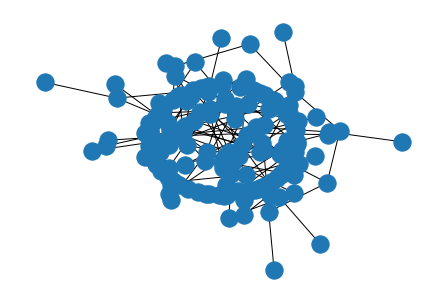

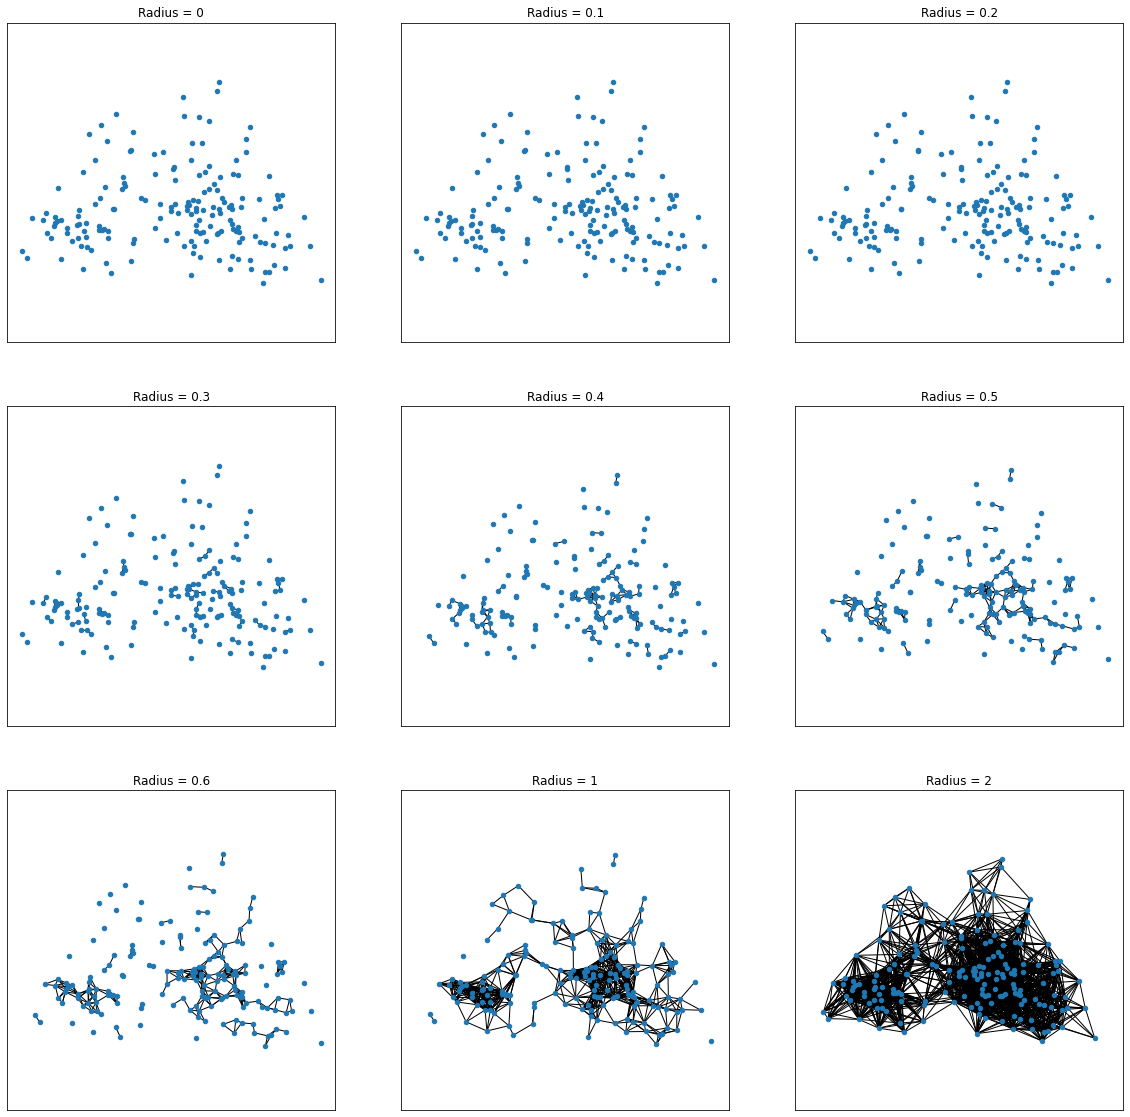

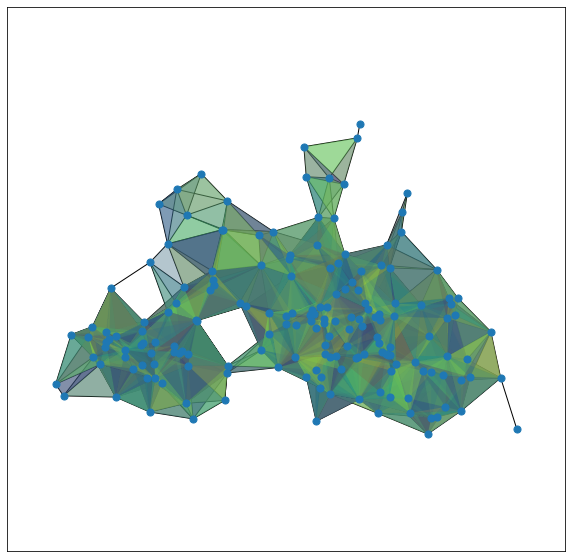

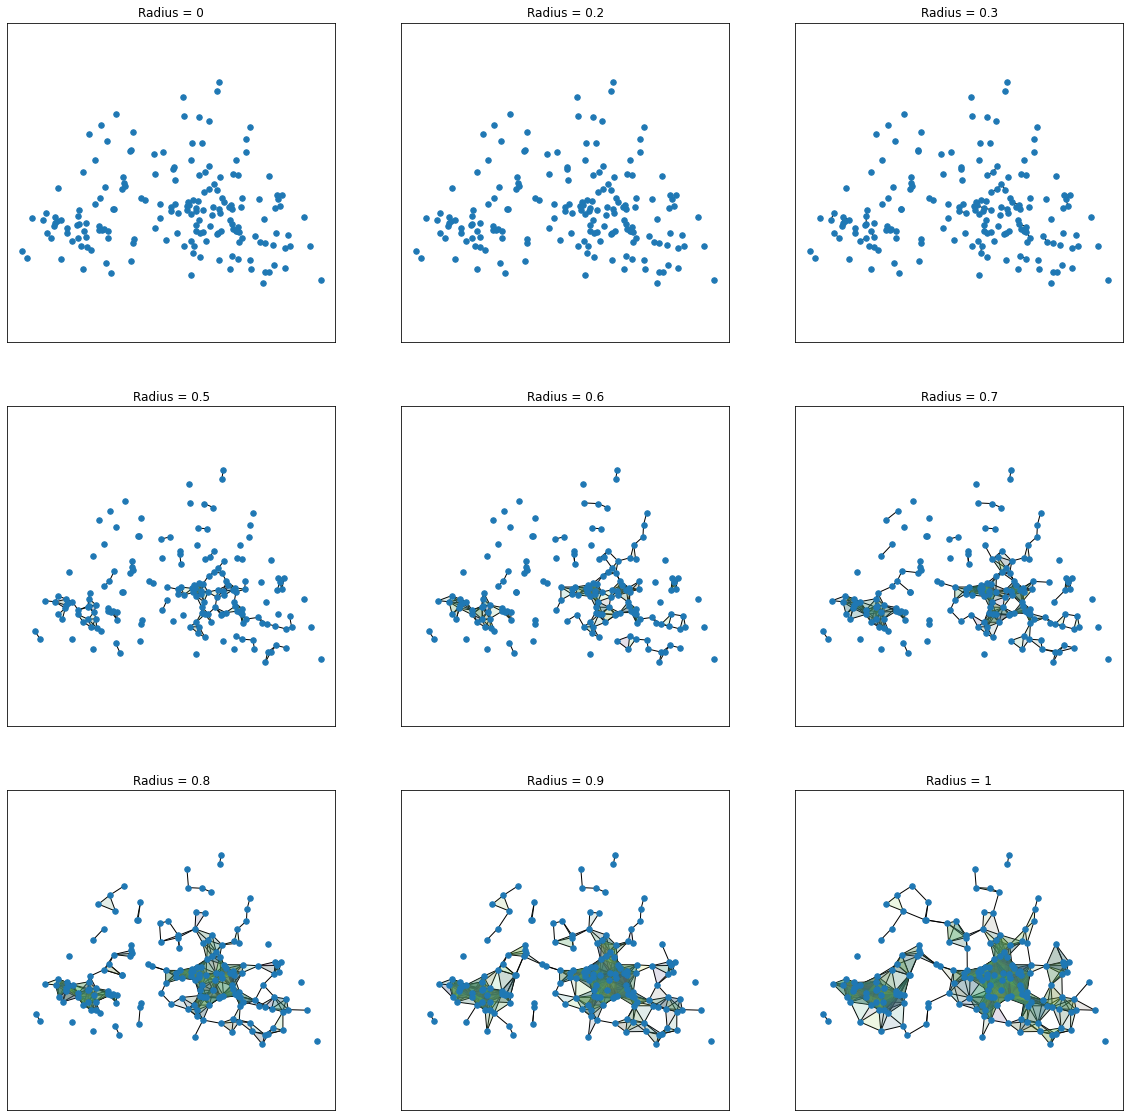

Number of Simplices: 260834


usetex mode requires TeX.


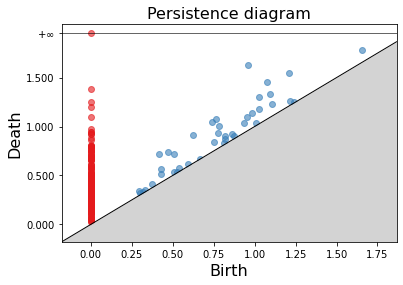

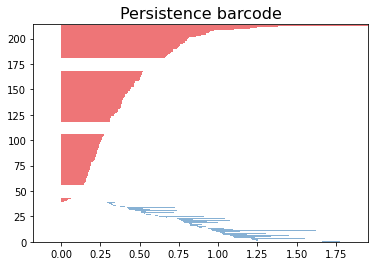

---------------------------------------------------------


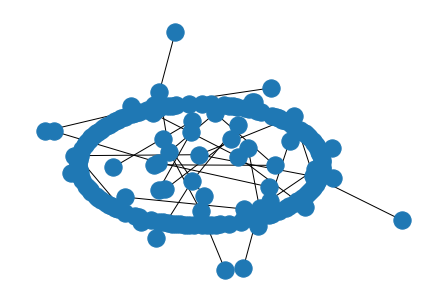

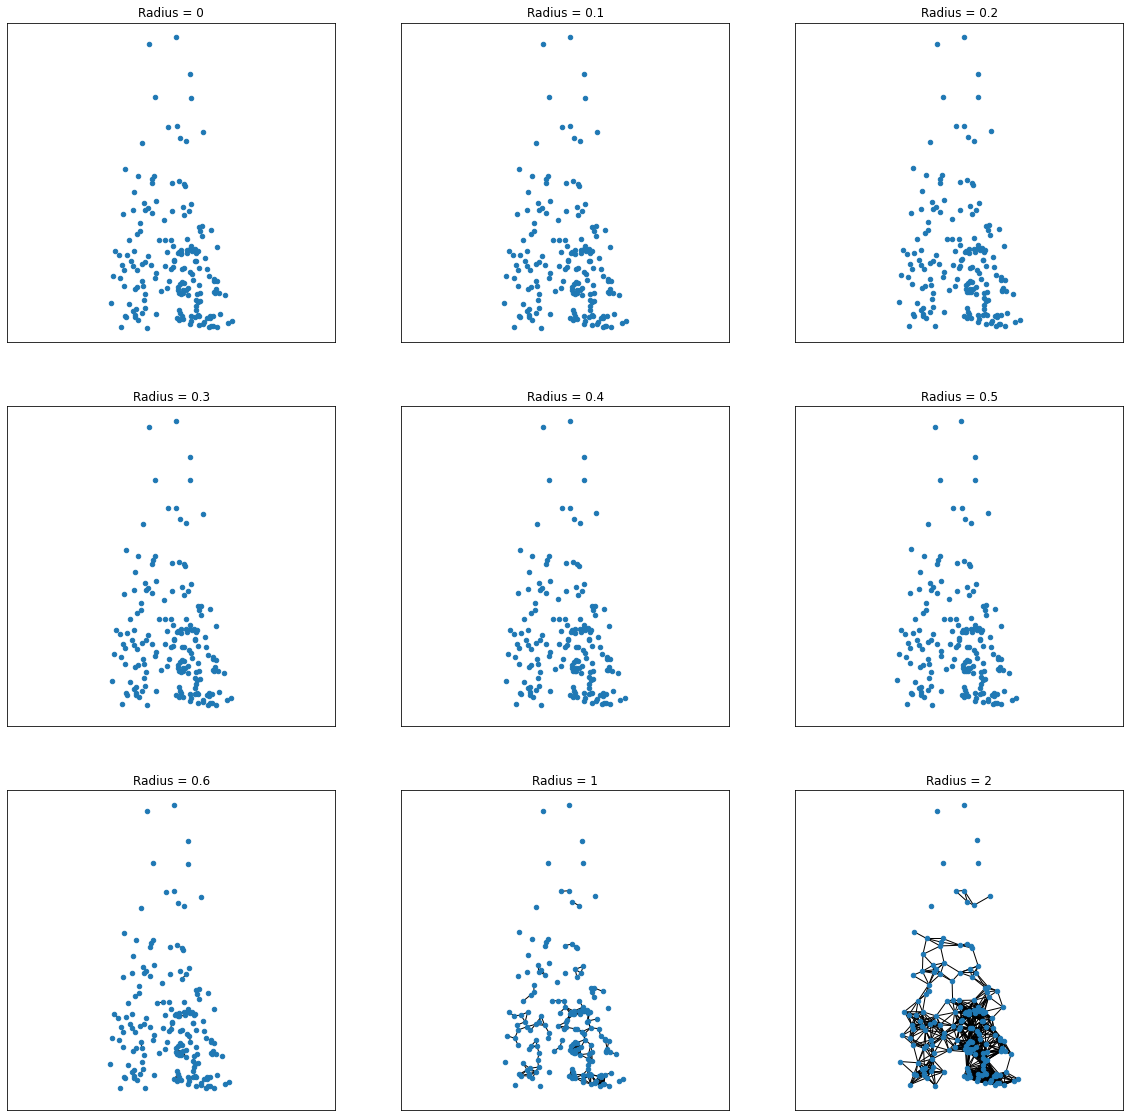

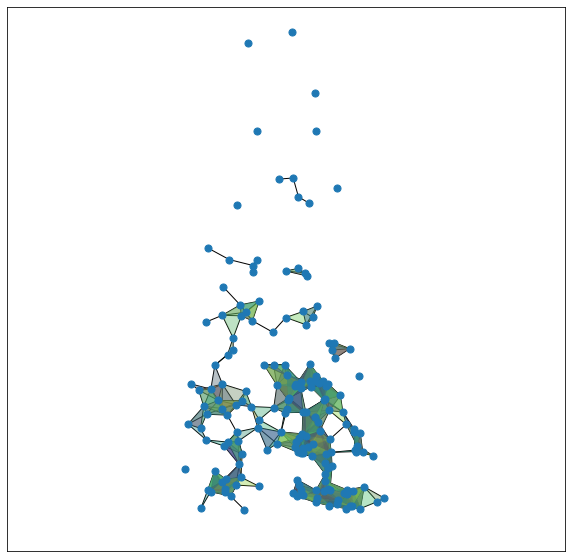

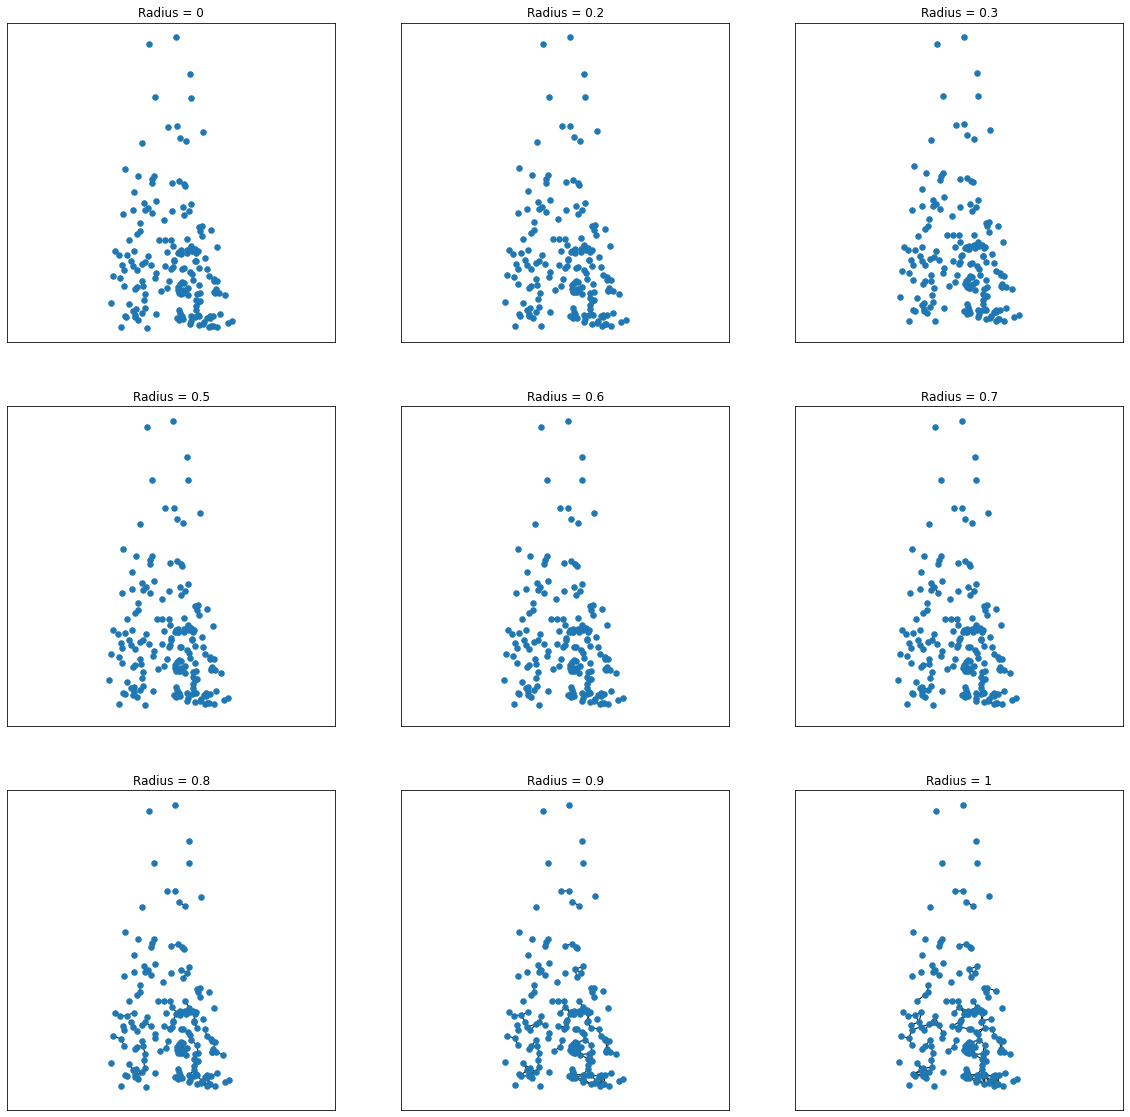

Number of Simplices: 15868


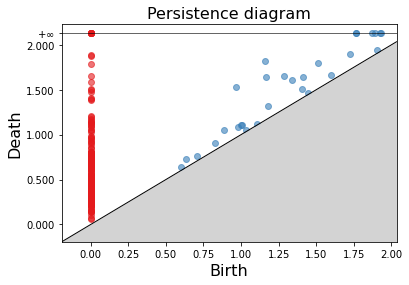

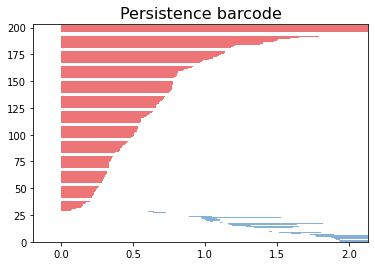

---------------------------------------------------------


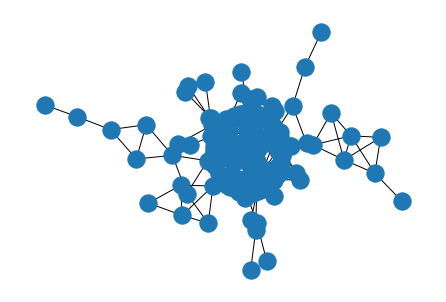

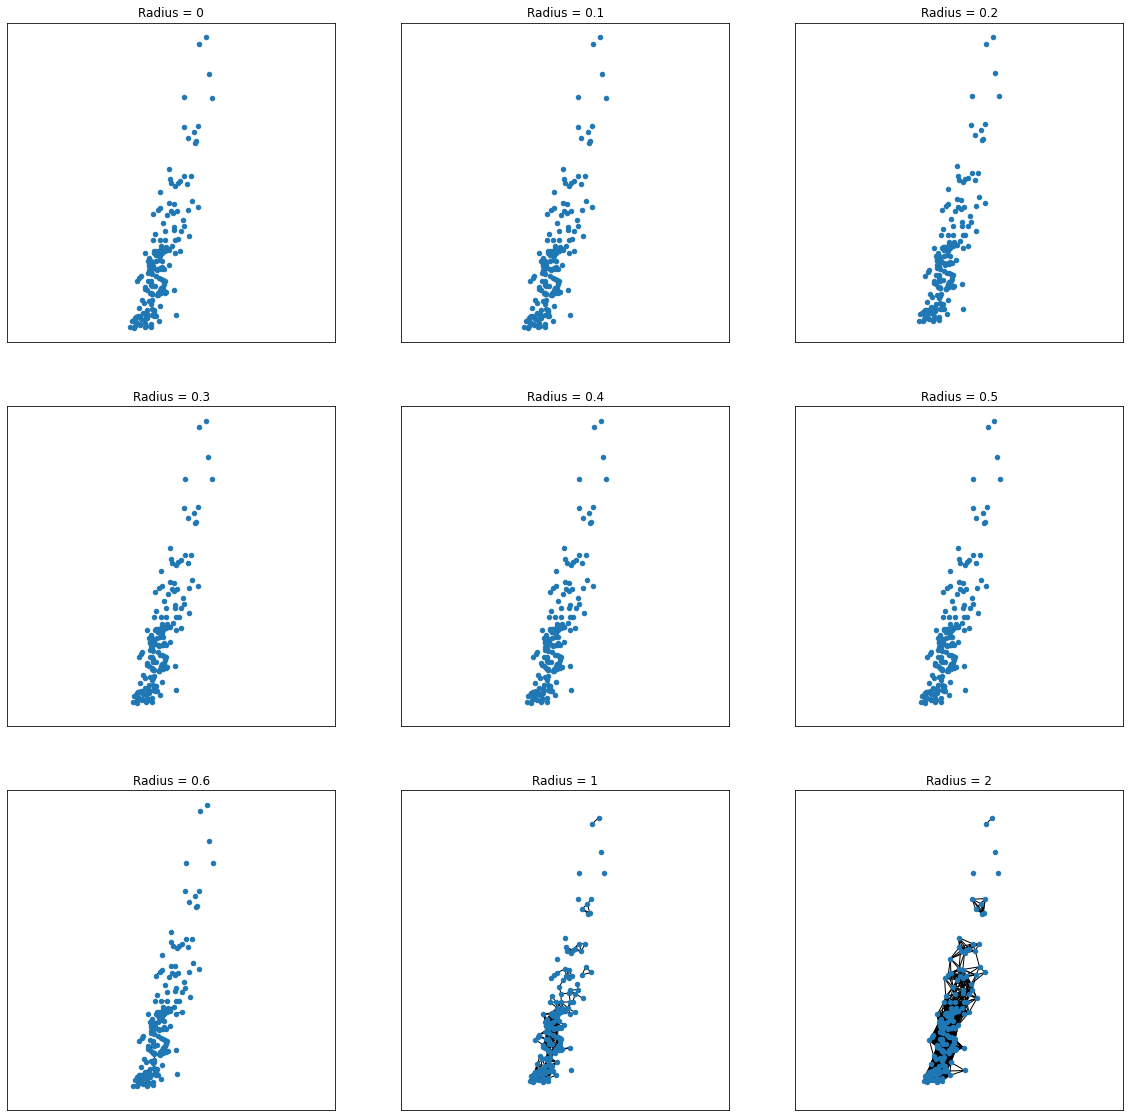

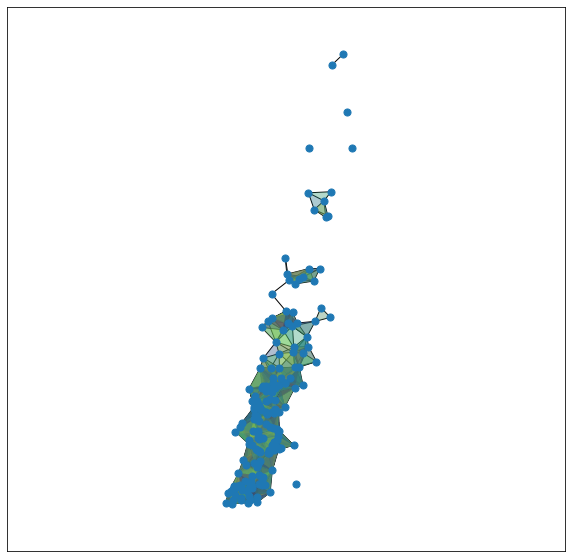

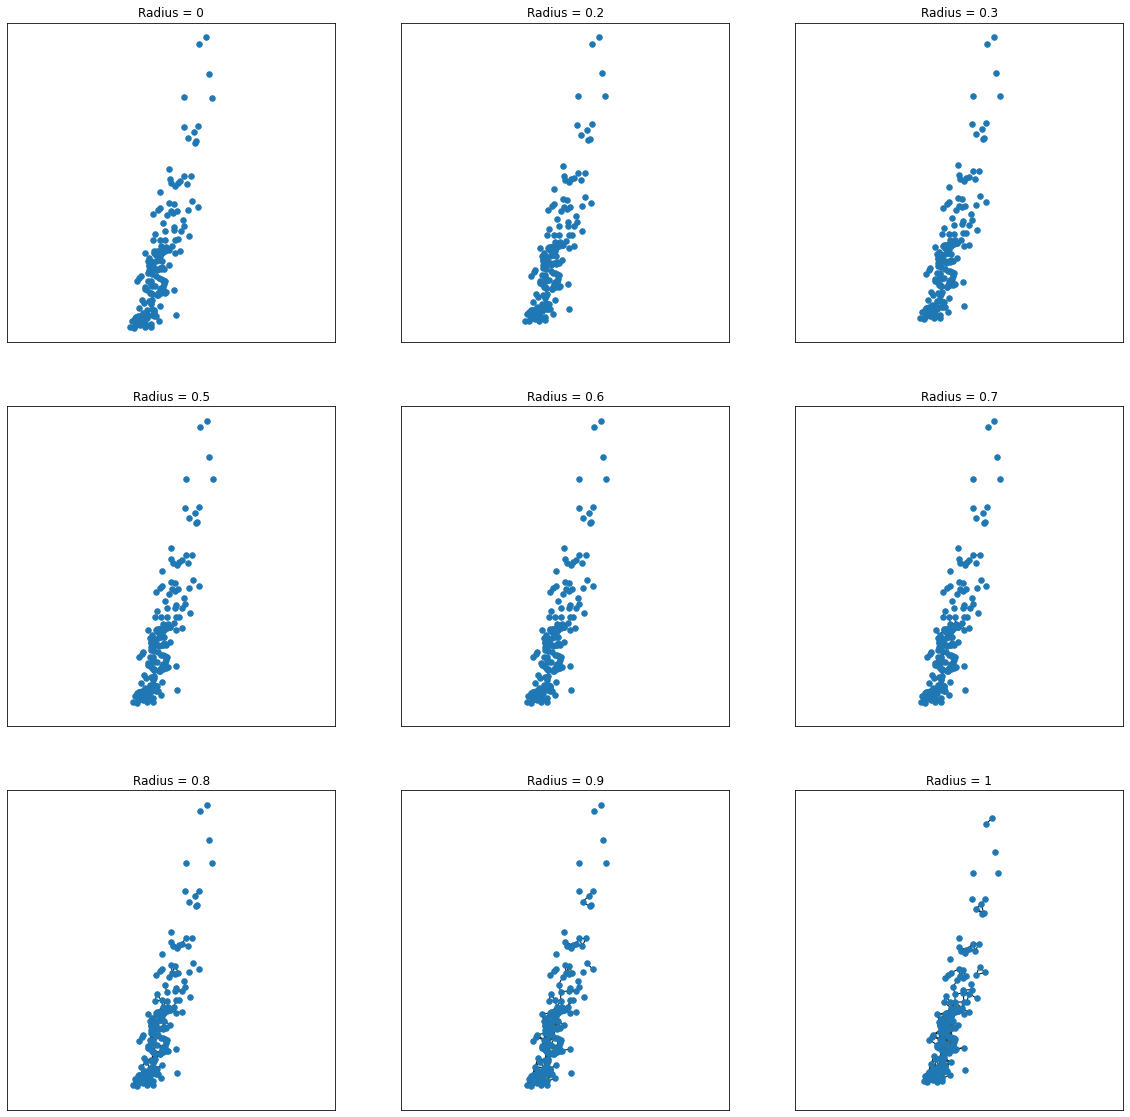

Number of Simplices: 245032


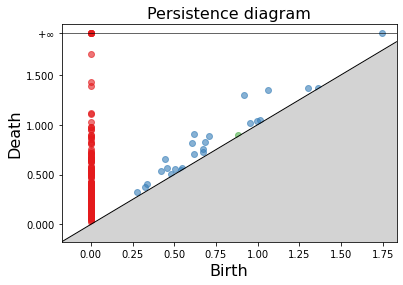

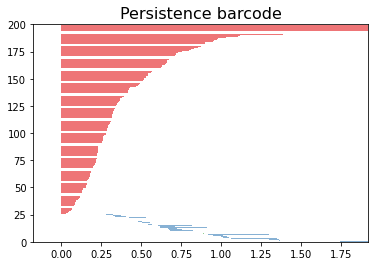

In [ ]:
lotsHomology('Summer', 'Temp', 'Prec')
print('---------------------------------------------------------')
lotsHomology('Summer', 'Temp', 'flow')
print('---------------------------------------------------------')
lotsHomology('Summer', 'Prec', 'flow')

##### Fall

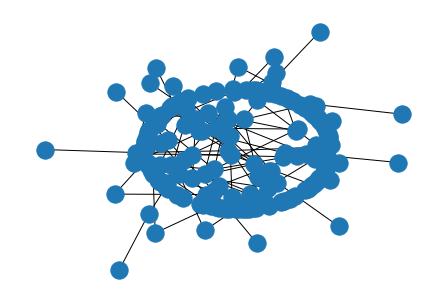

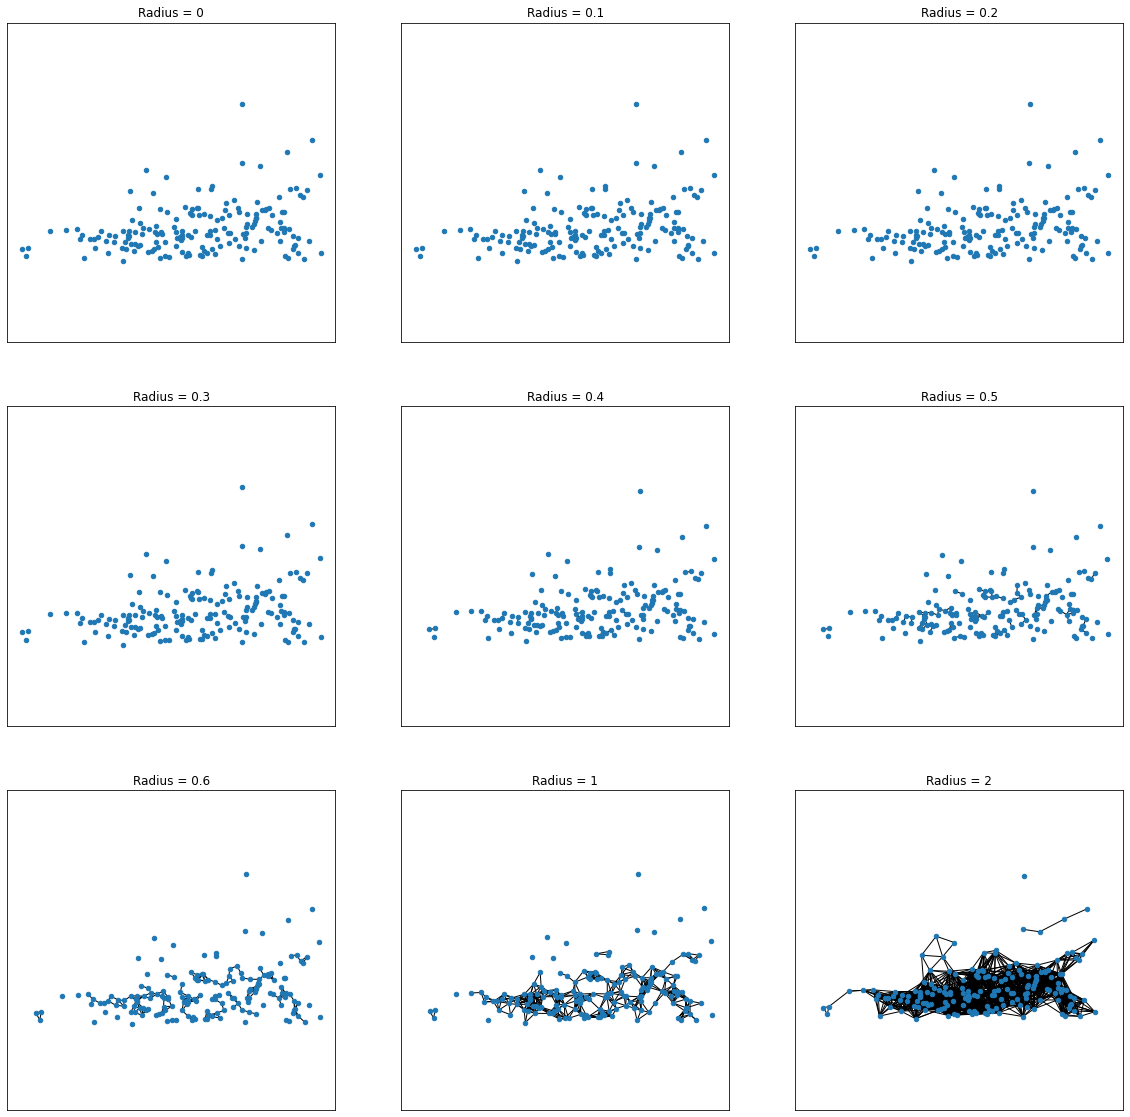

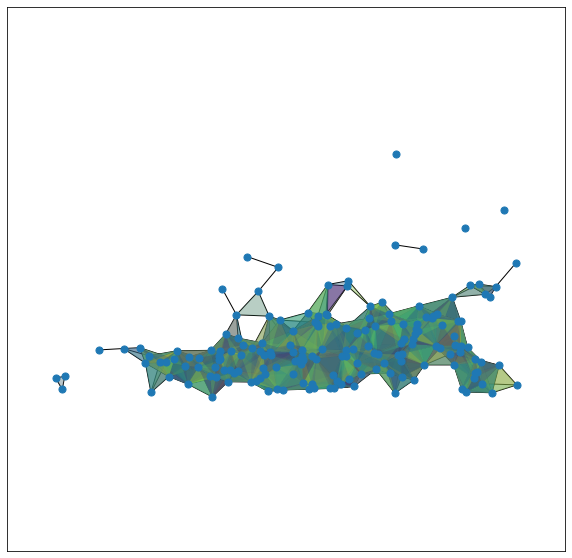

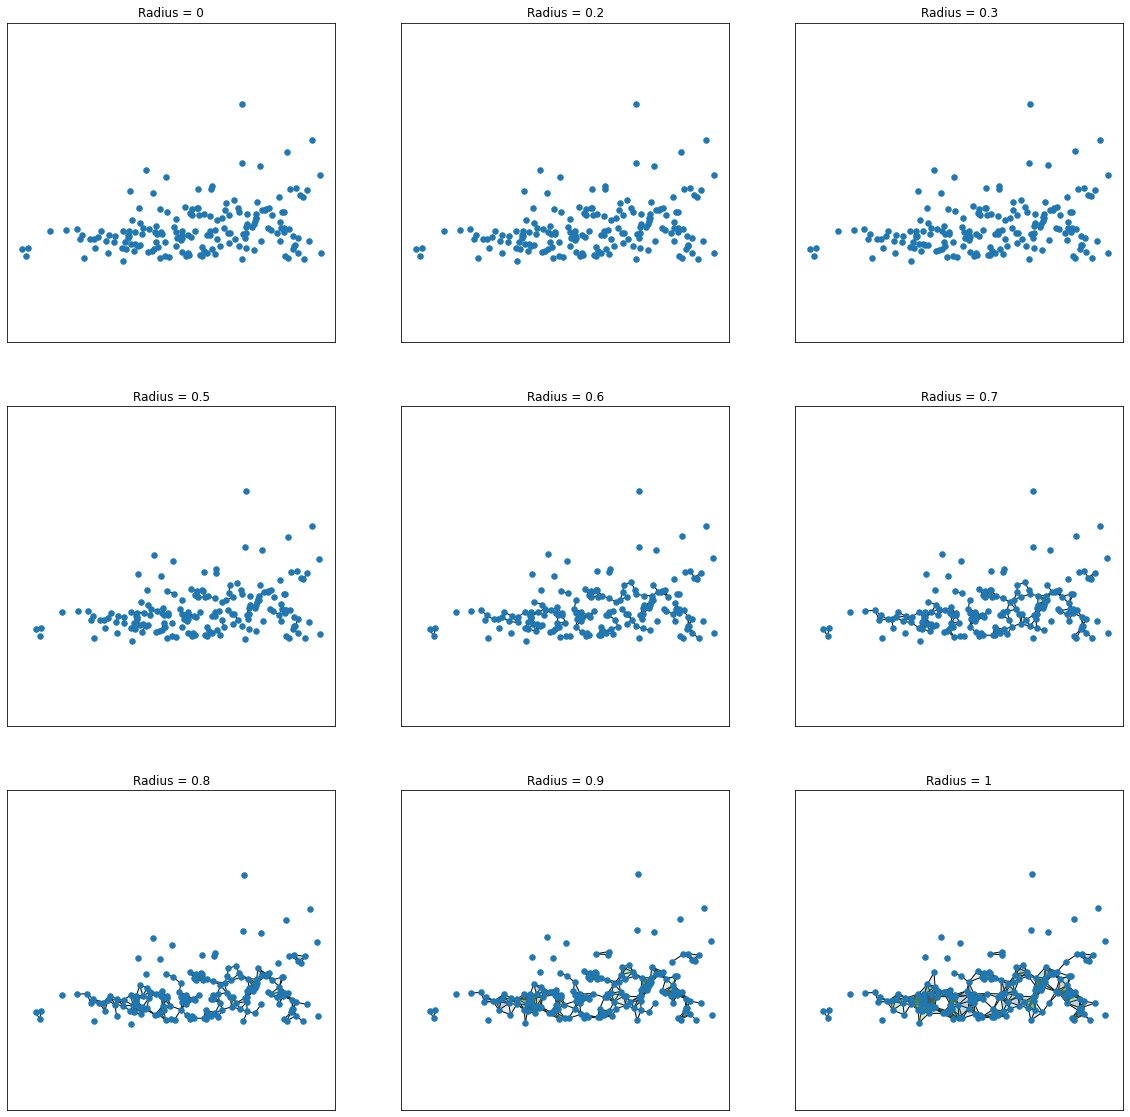

Number of Simplices: 76731


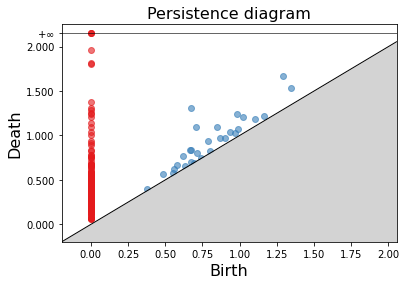

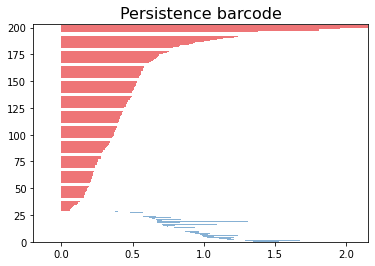

---------------------------------------------------------


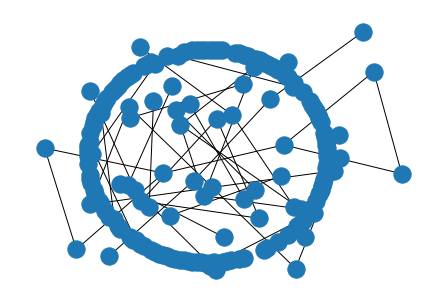

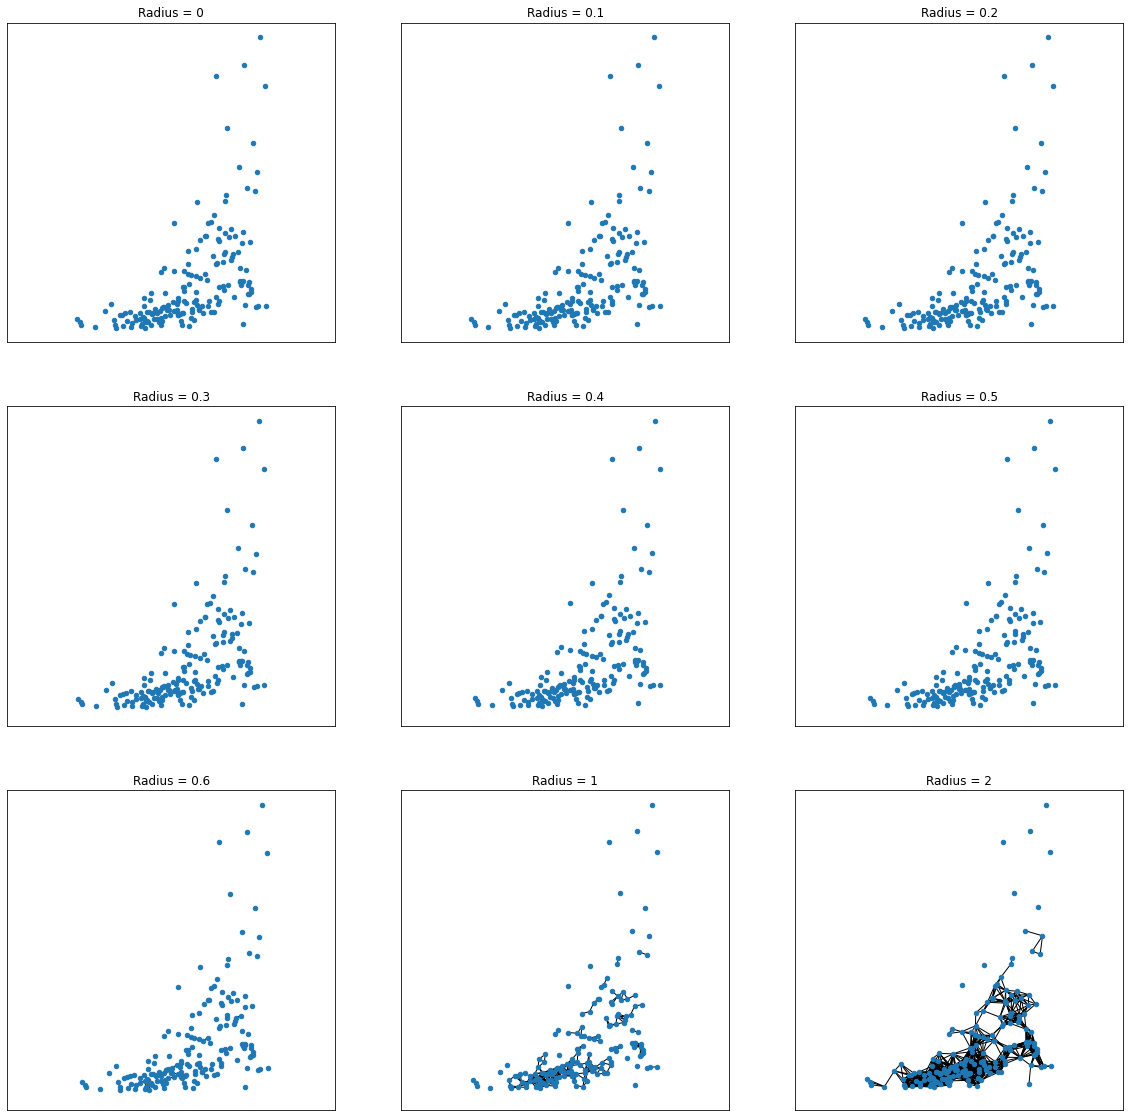

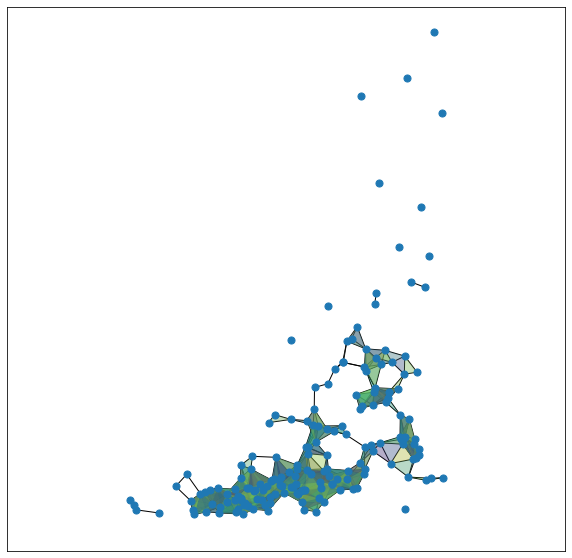

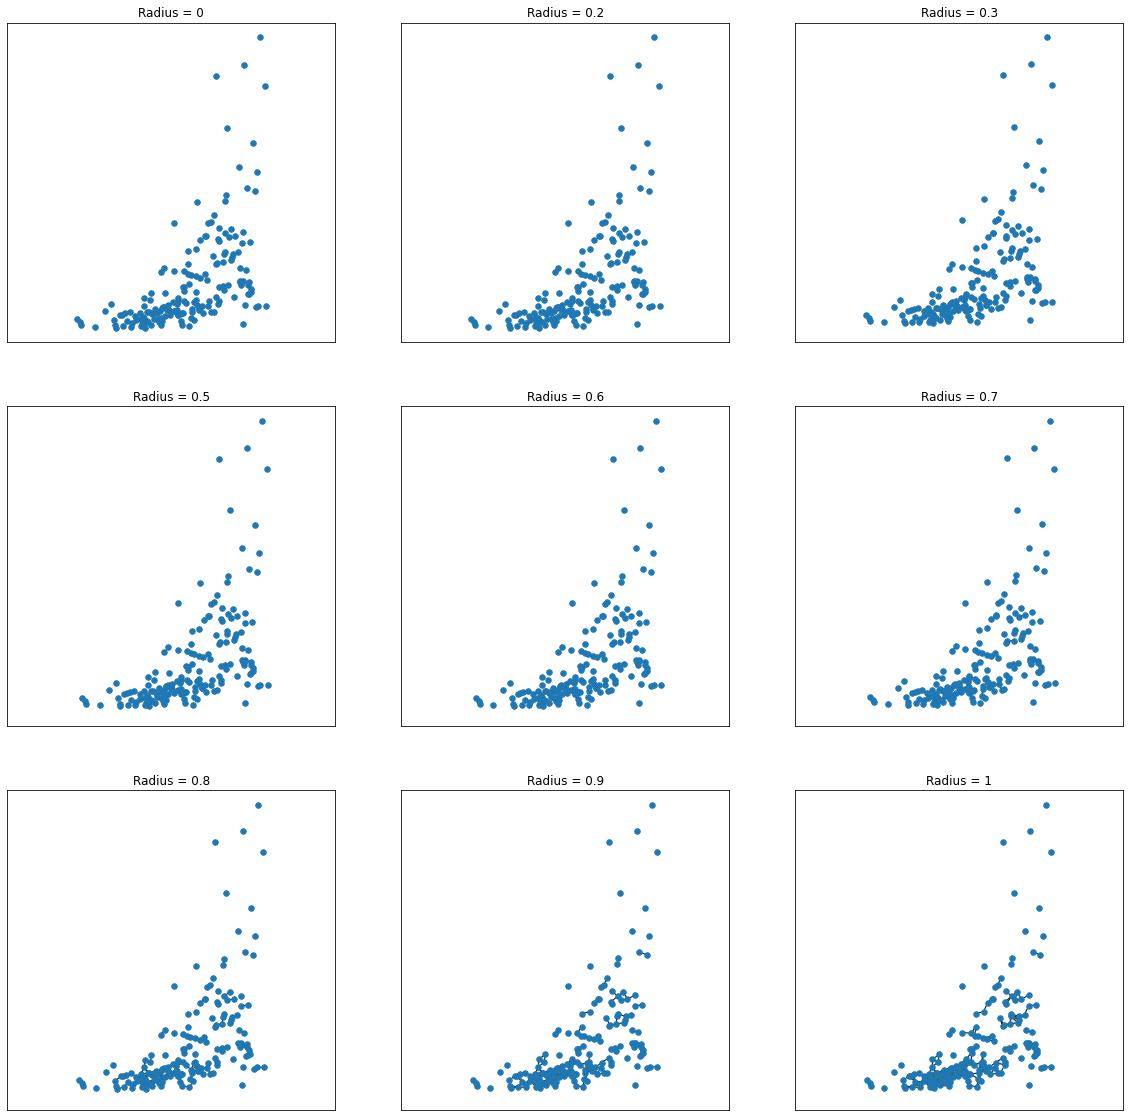

Number of Simplices: 42330


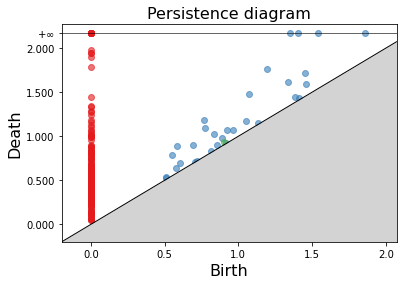

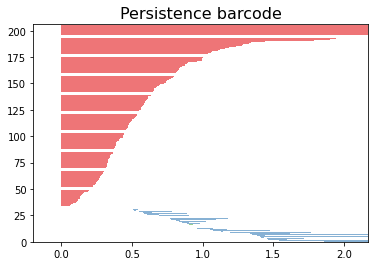

---------------------------------------------------------


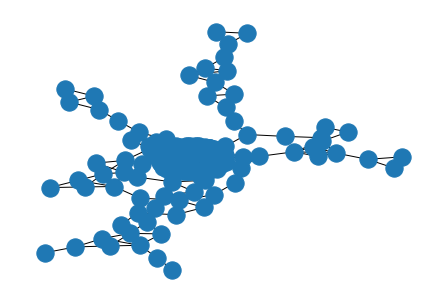

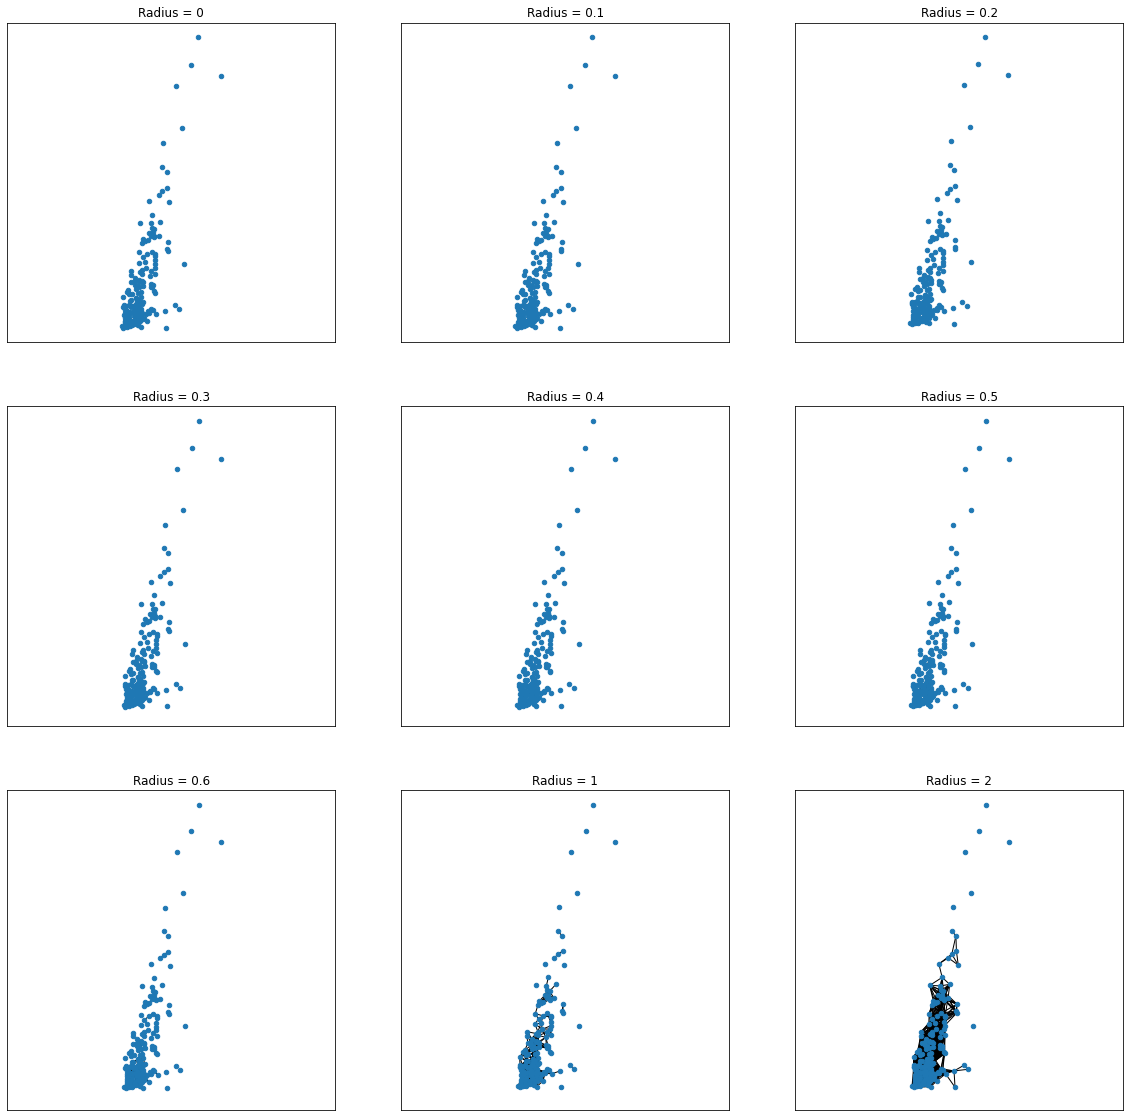

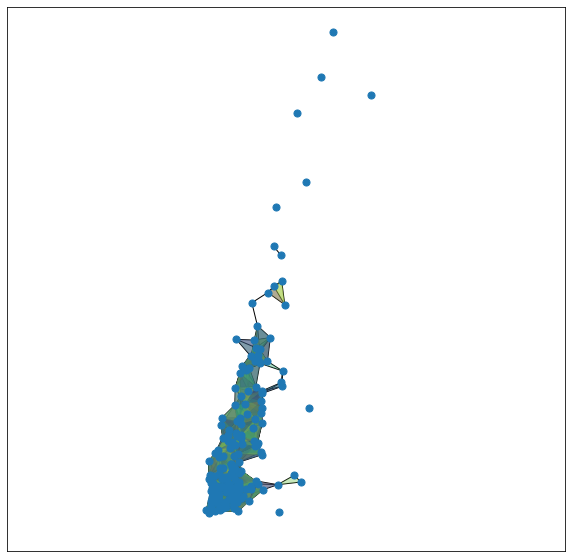

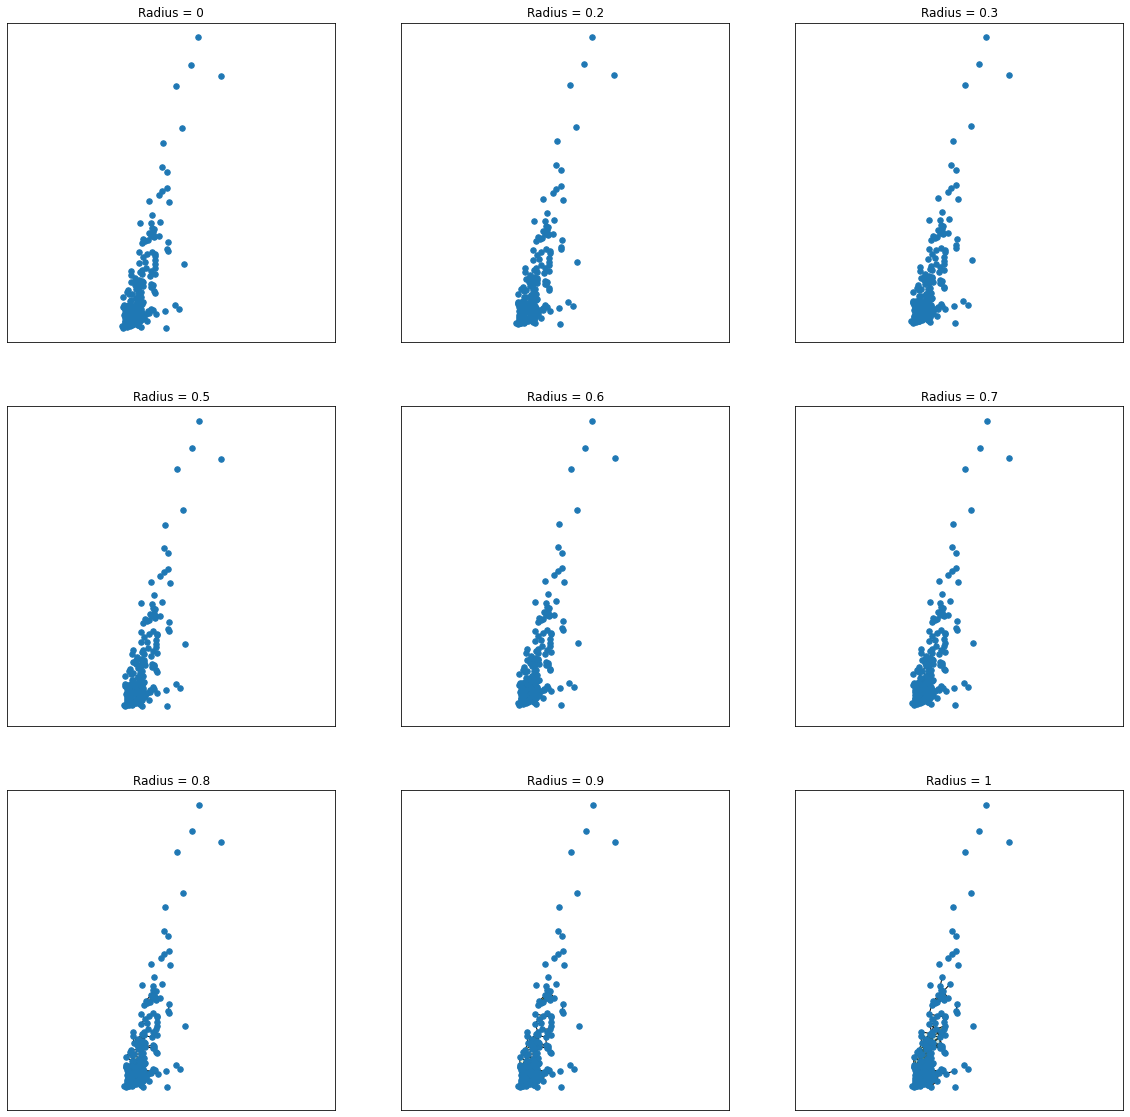

Number of Simplices: 1147953


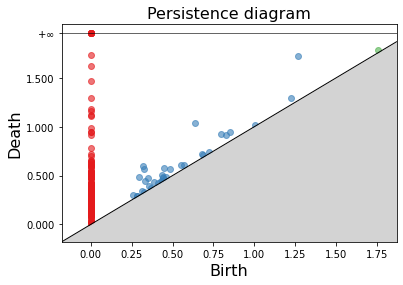

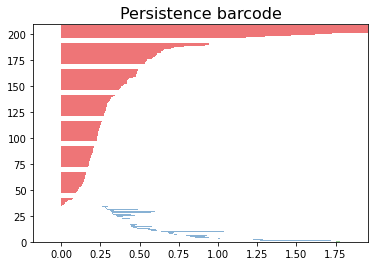

In [ ]:
lotsHomology('Fall', 'Temp', 'Prec')
print('---------------------------------------------------------')
lotsHomology('Fall', 'Temp', 'flow')
print('---------------------------------------------------------')
lotsHomology('Fall', 'Prec', 'flow')

##### Winter

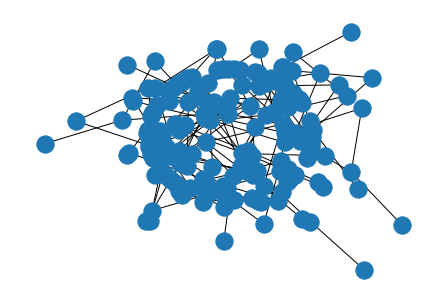

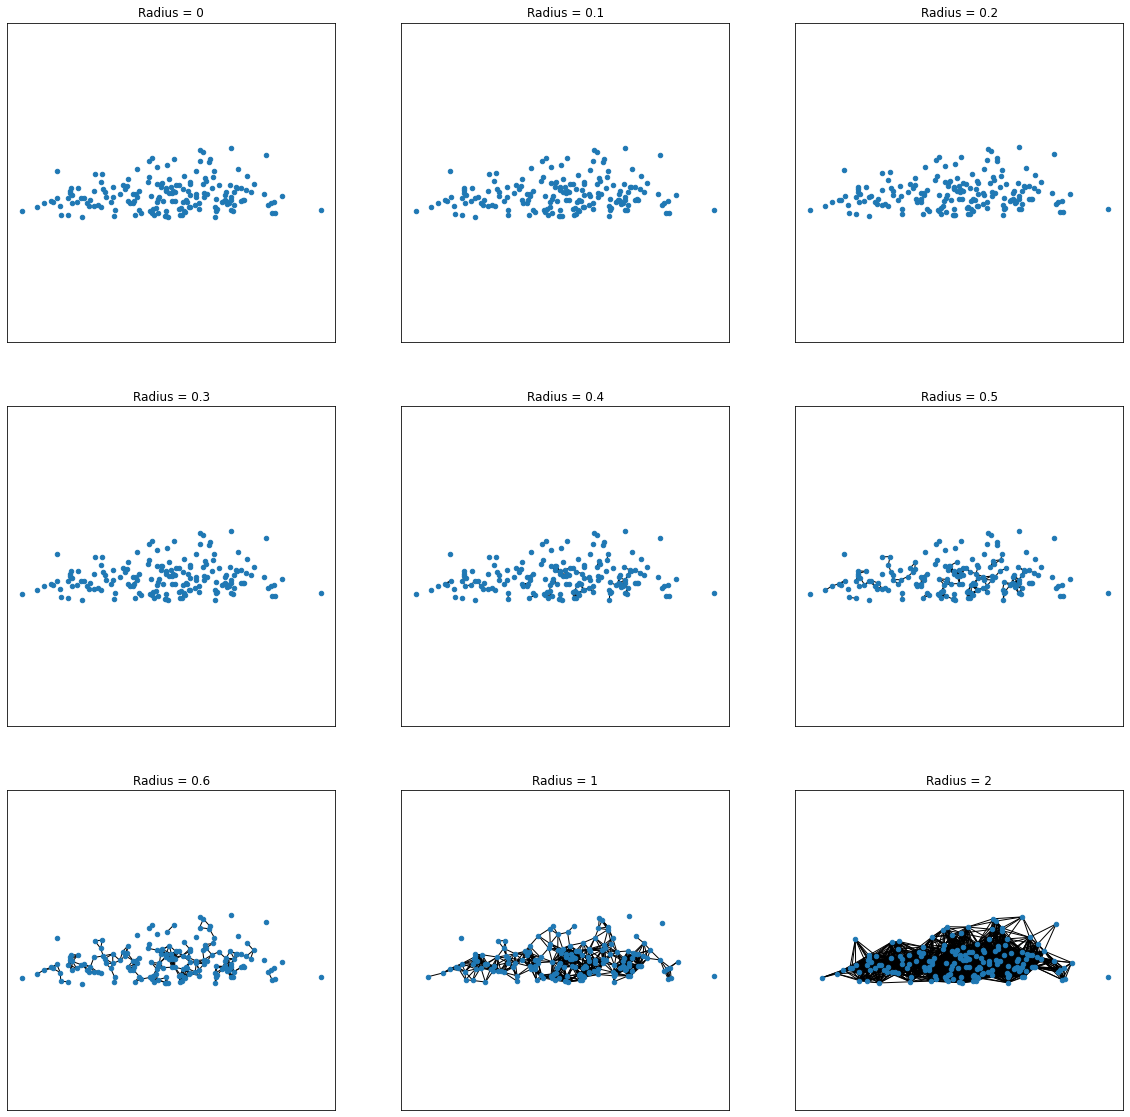

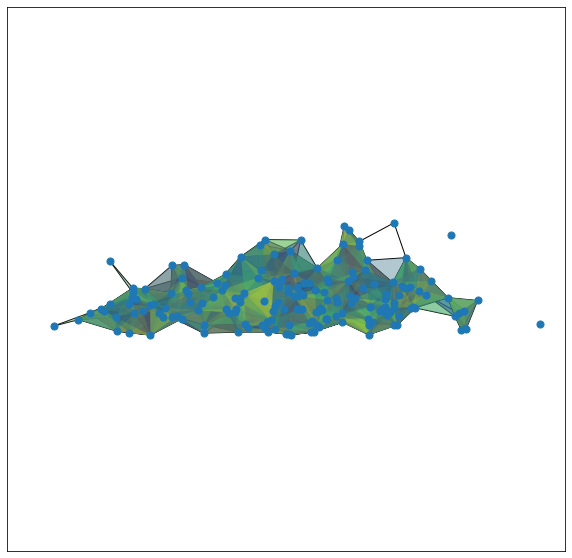

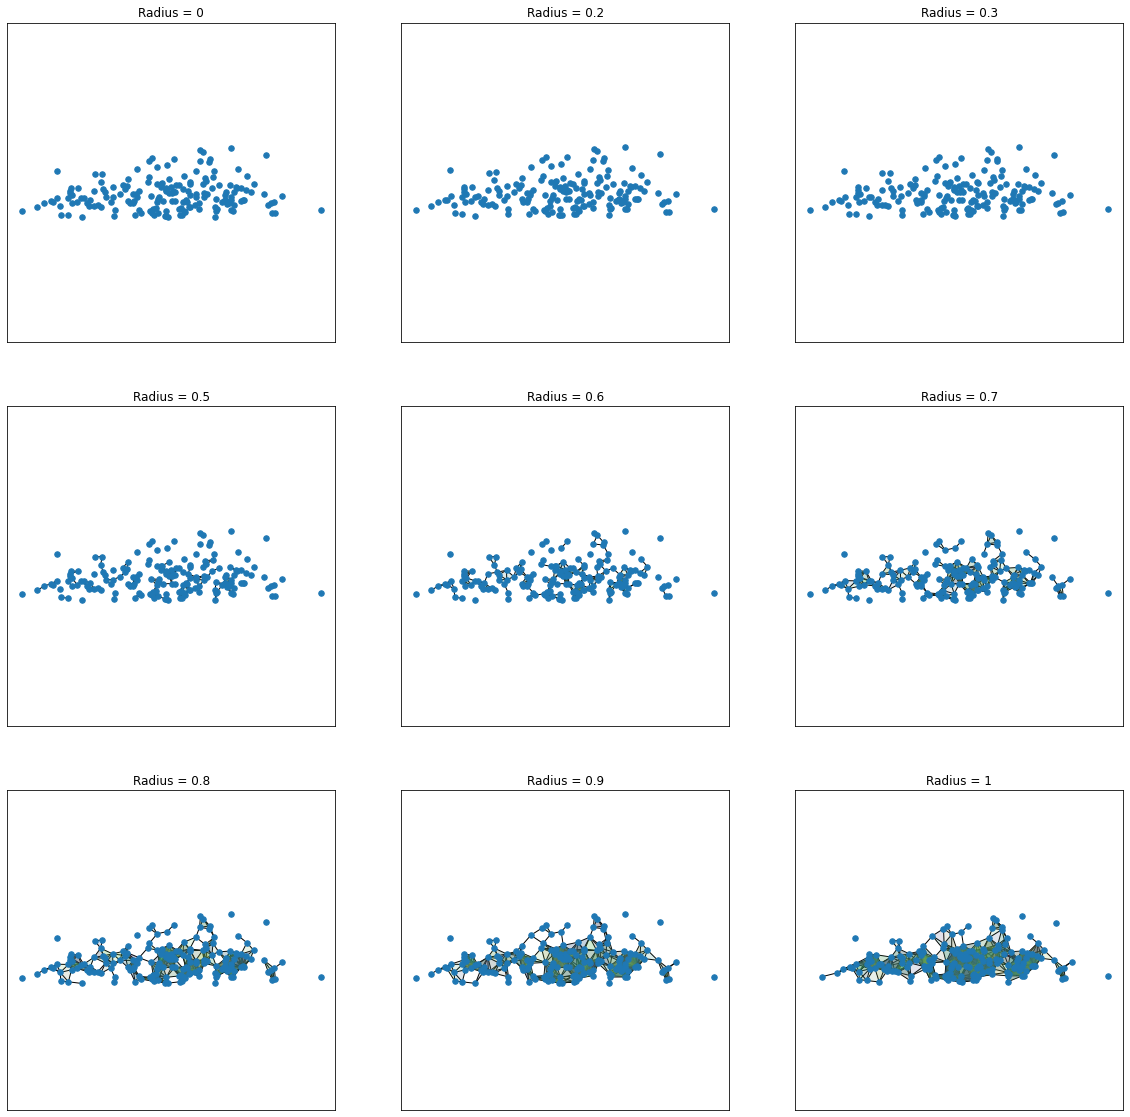

Number of Simplices: 291636


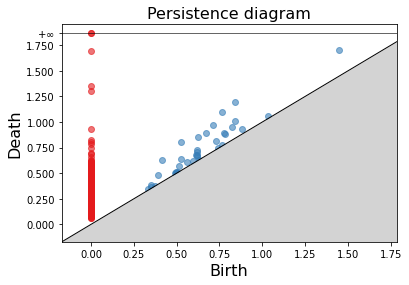

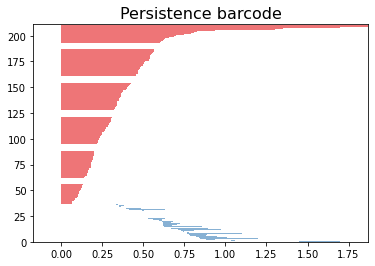

---------------------------------------------------------


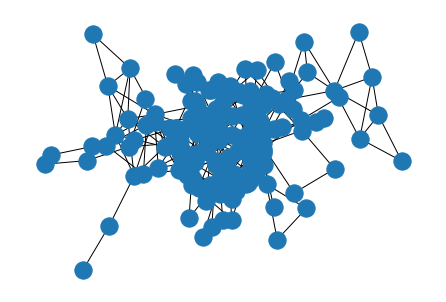

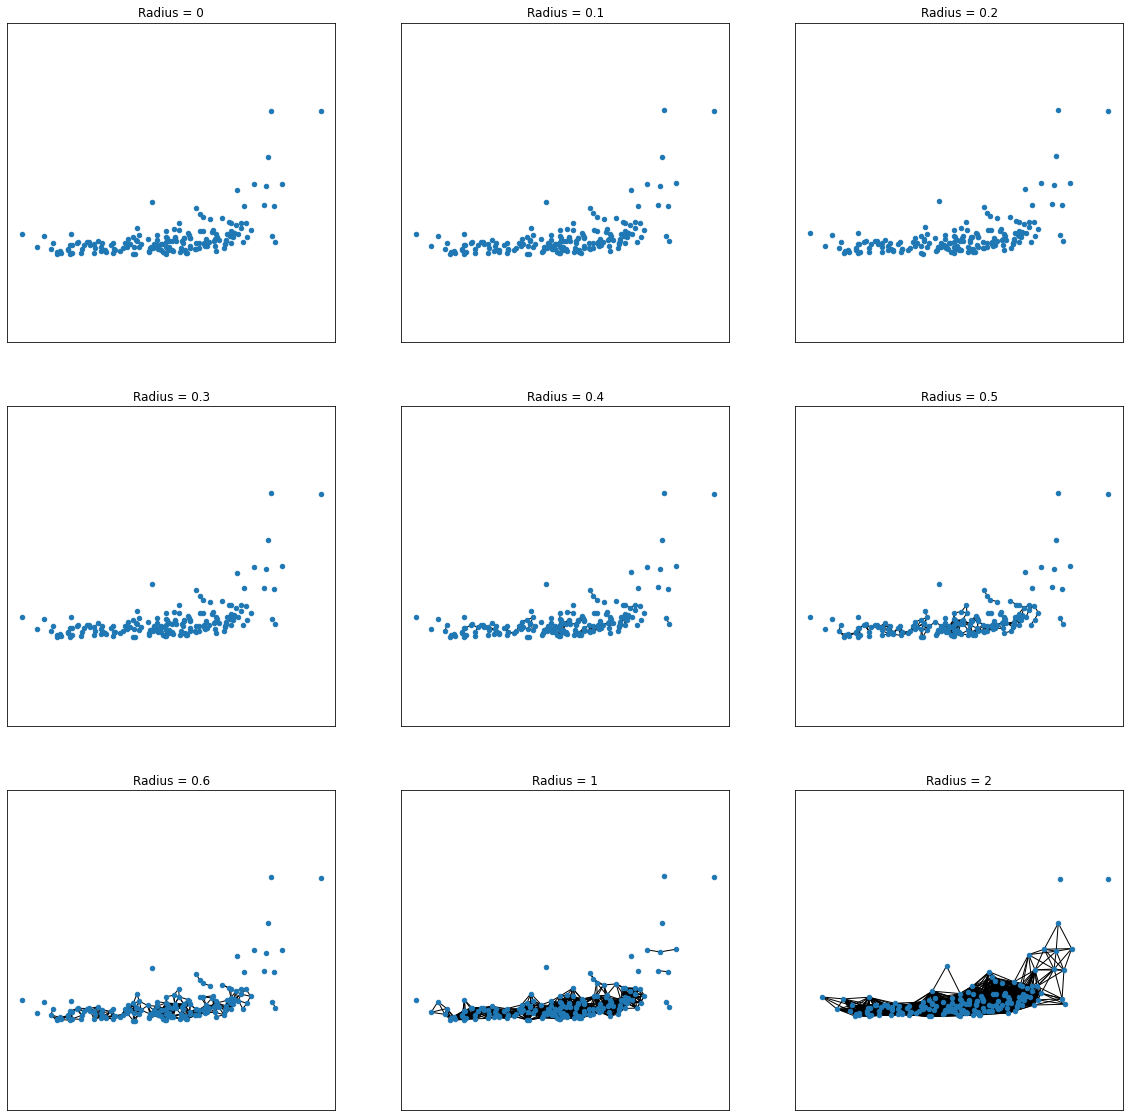

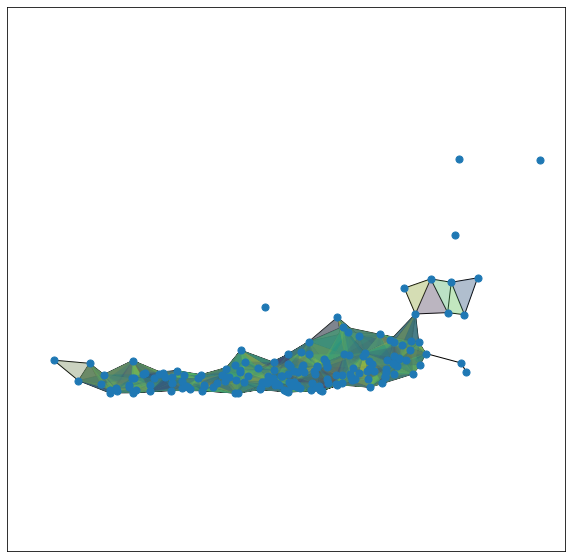

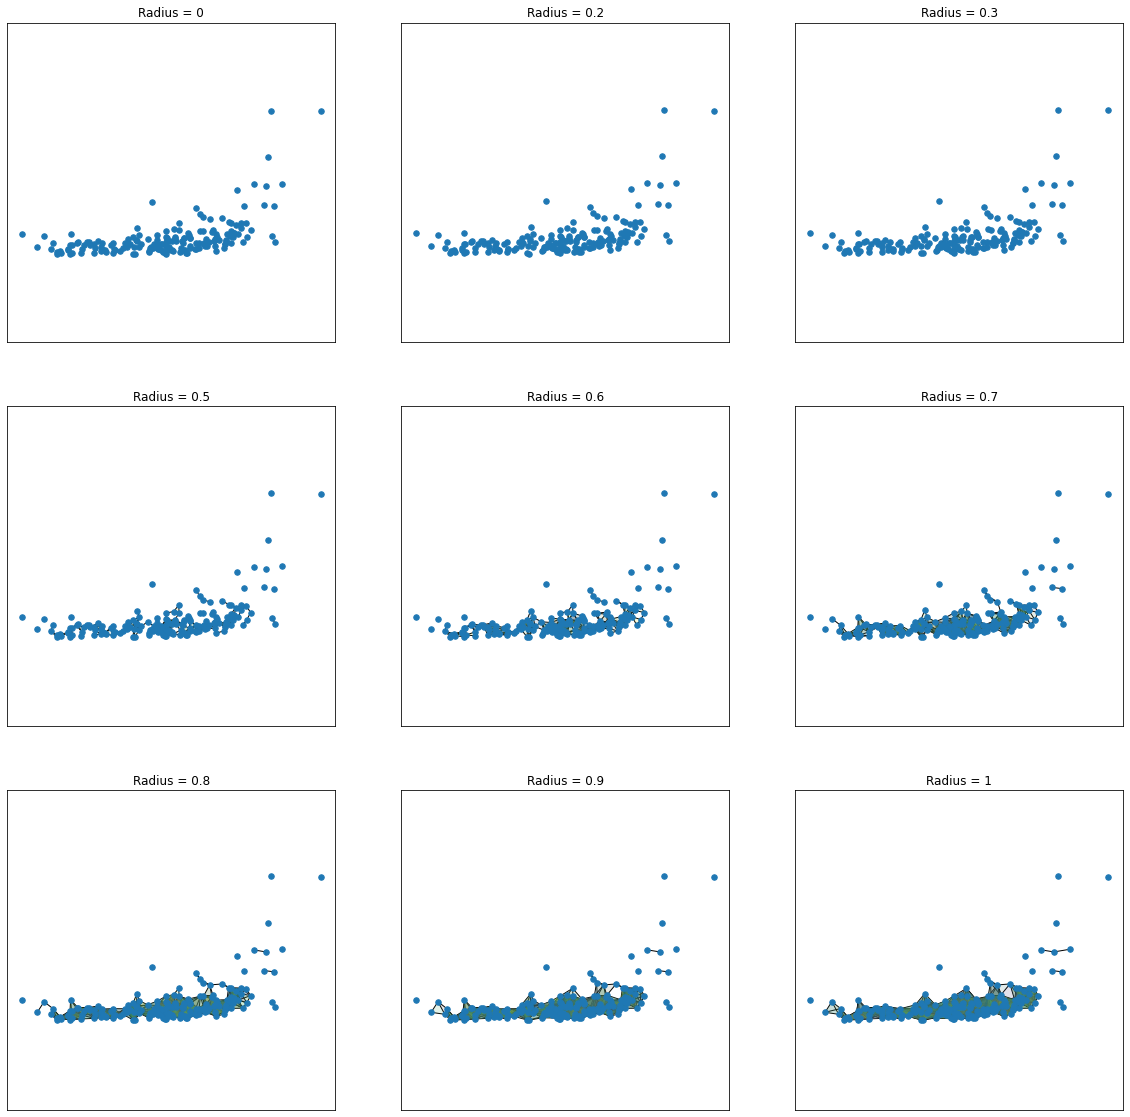

Number of Simplices: 556973


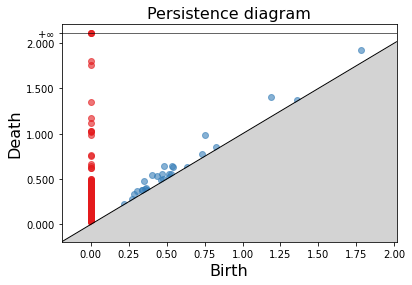

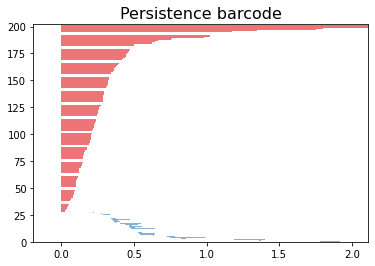

---------------------------------------------------------


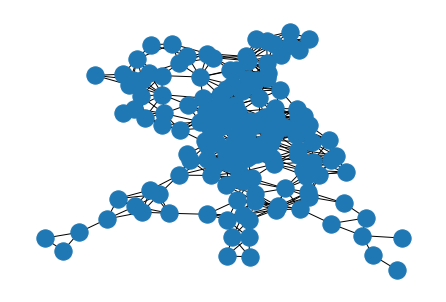

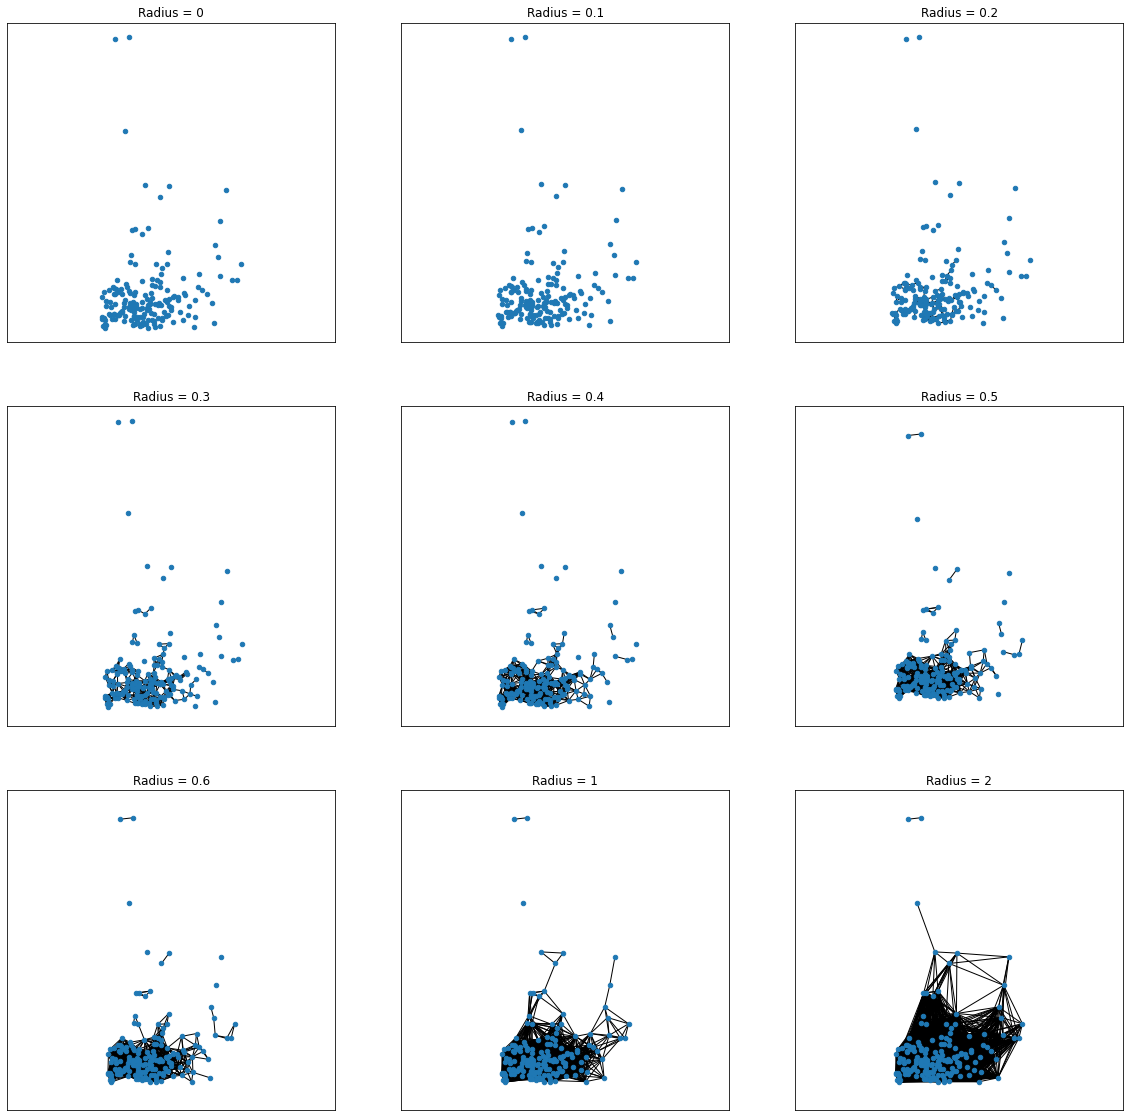

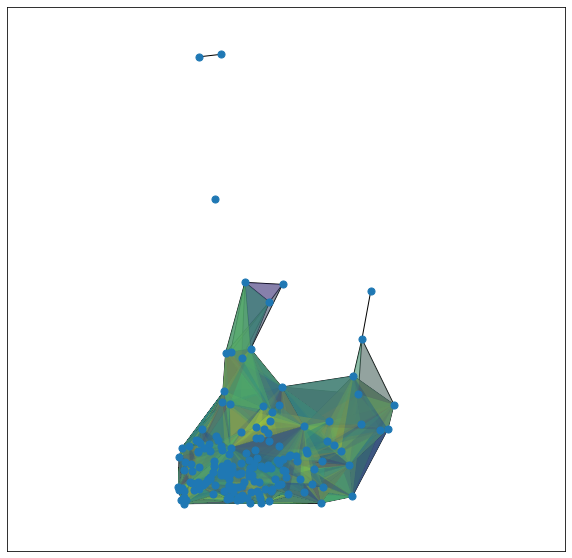

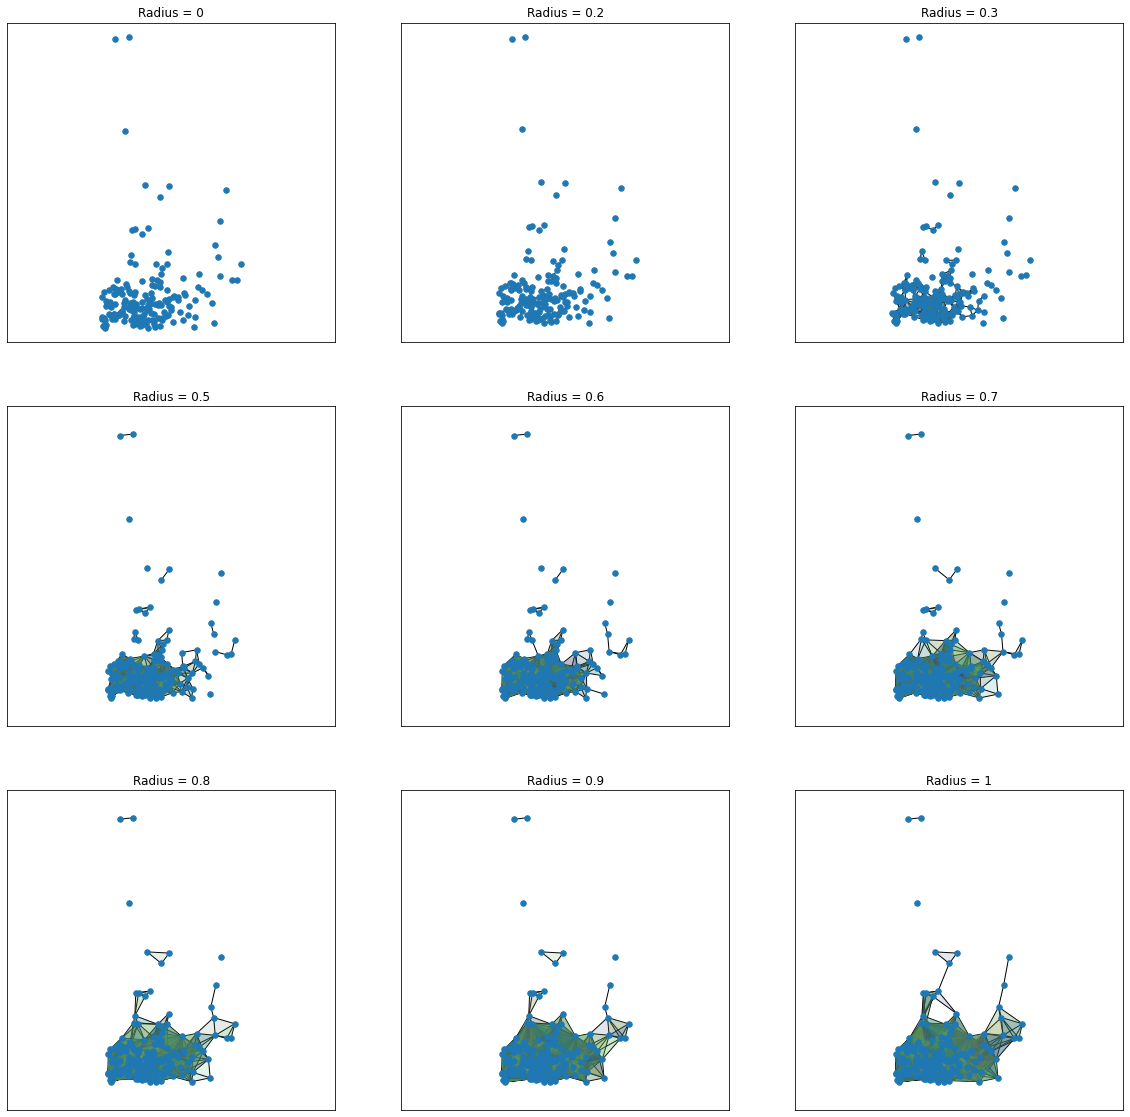

Number of Simplices: 15951549


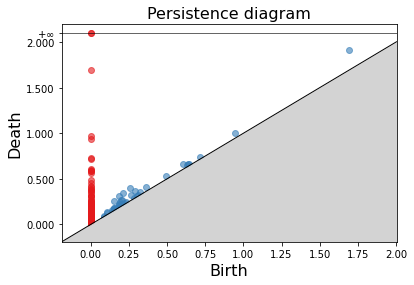

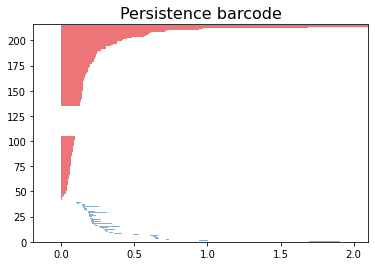

In [ ]:
lotsHomology('Winter', 'Temp', 'Prec')
print('---------------------------------------------------------')
lotsHomology('Winter', 'Temp', 'flow')
print('---------------------------------------------------------')
lotsHomology('Winter', 'Prec', 'flow')

##### Spring

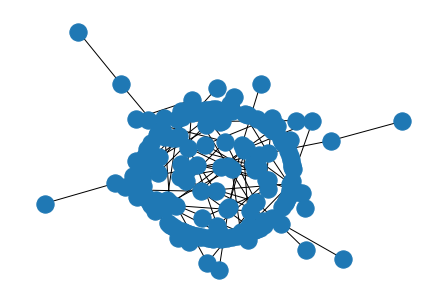

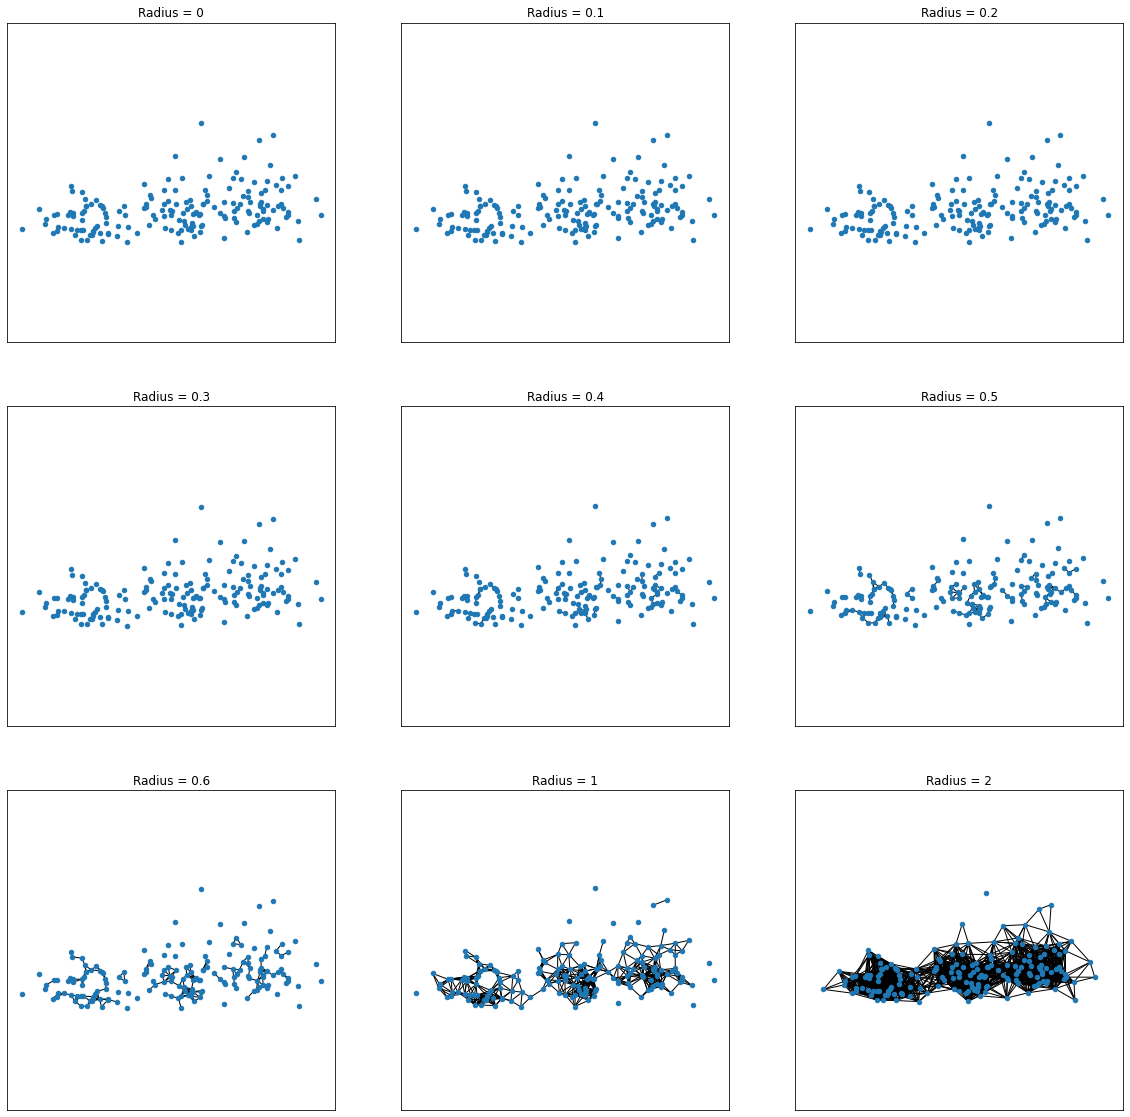

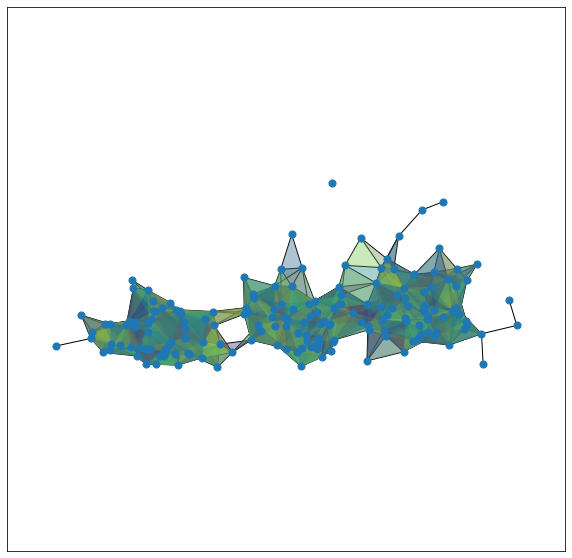

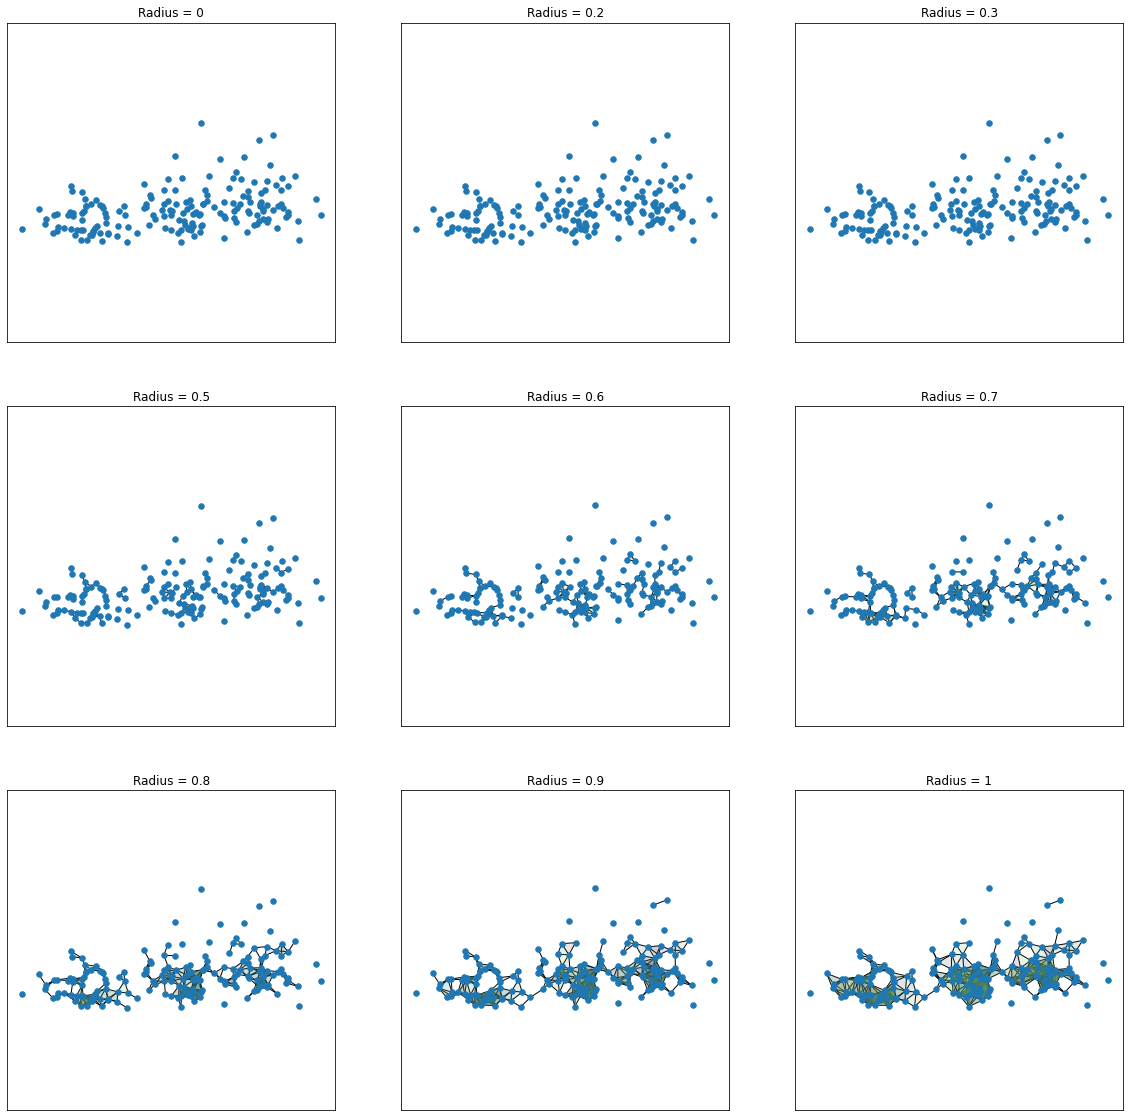

Number of Simplices: 111720


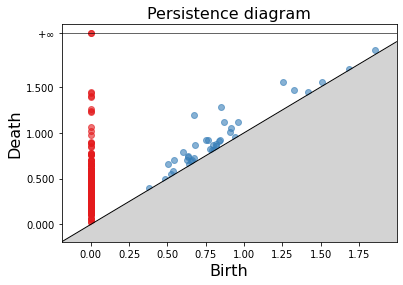

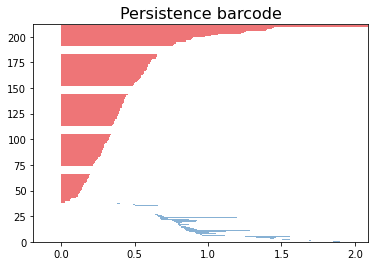

---------------------------------------------------------


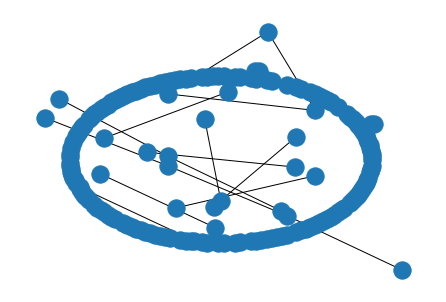

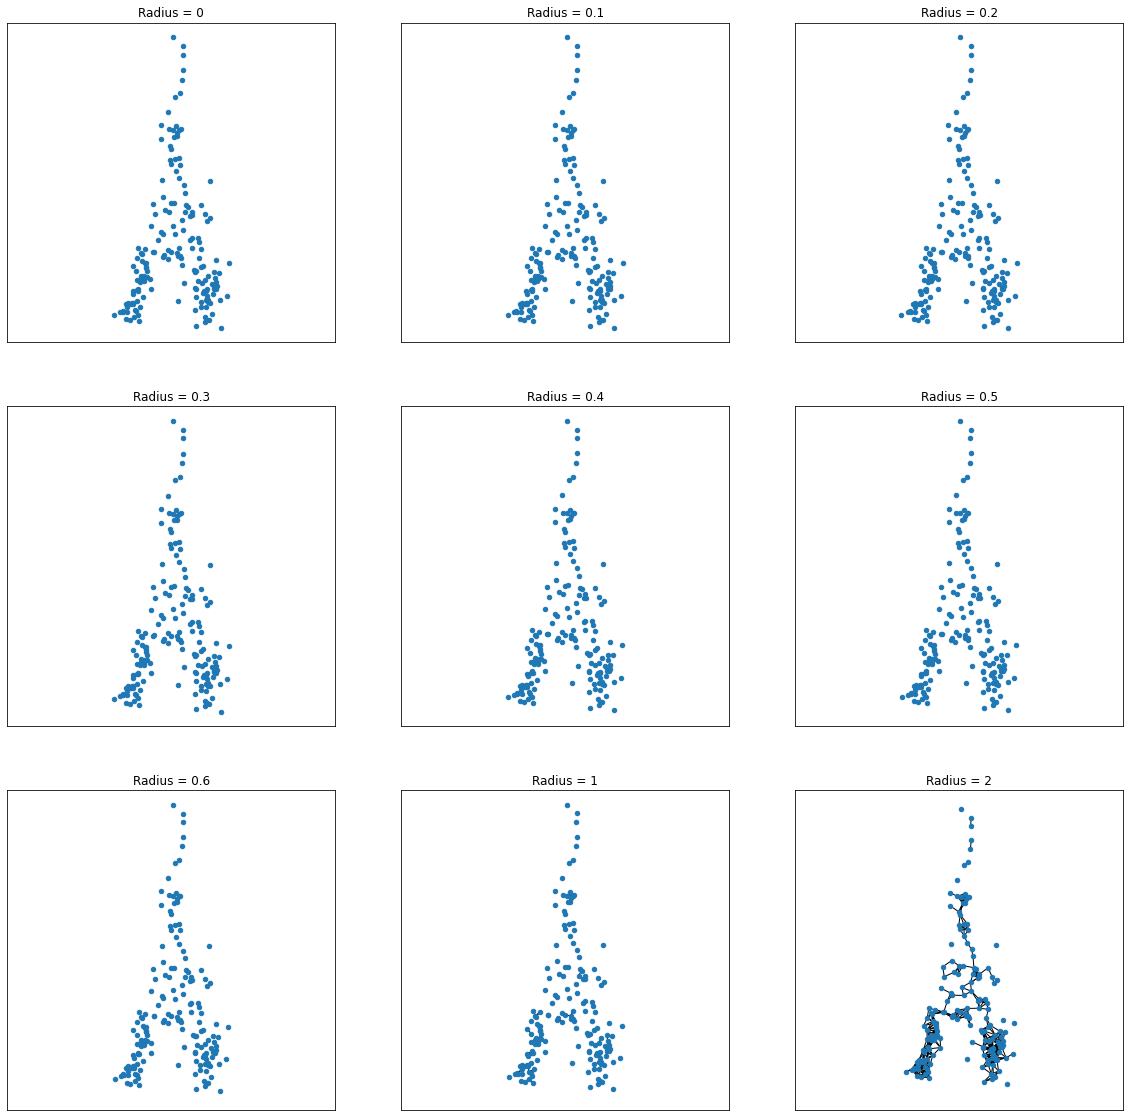

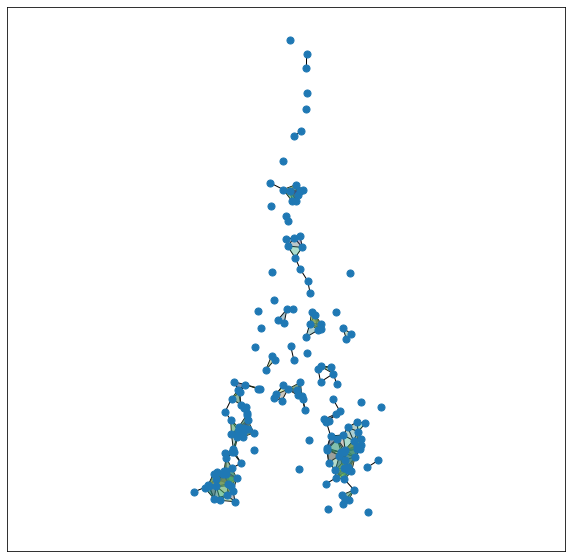

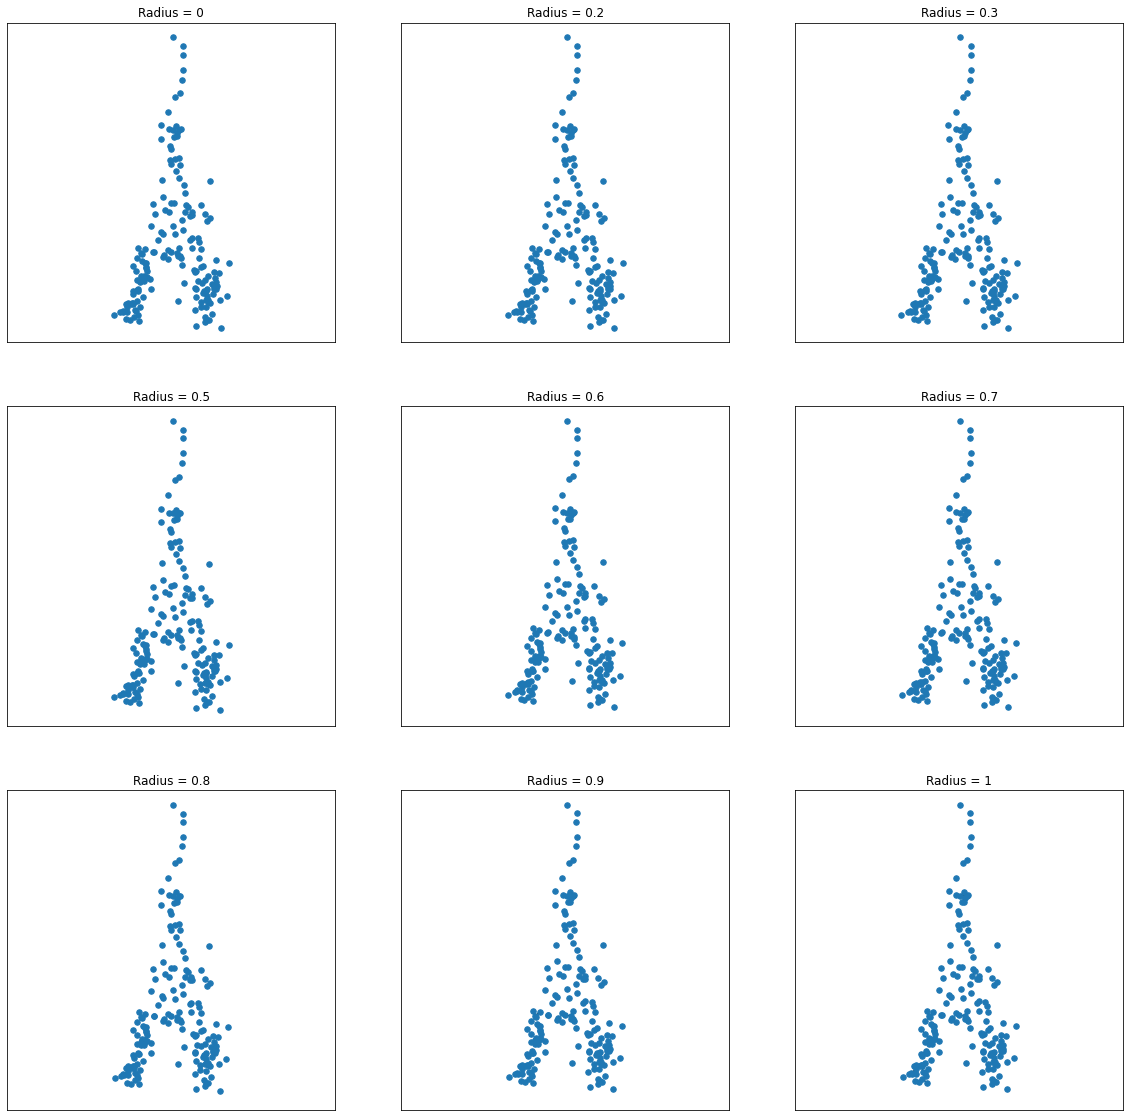

Number of Simplices: 3844


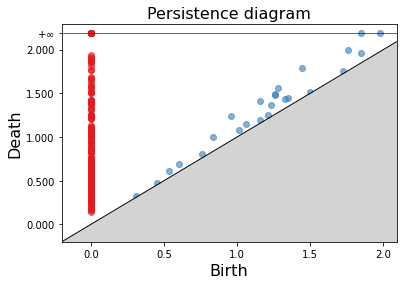

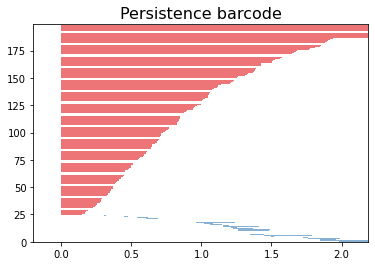

---------------------------------------------------------


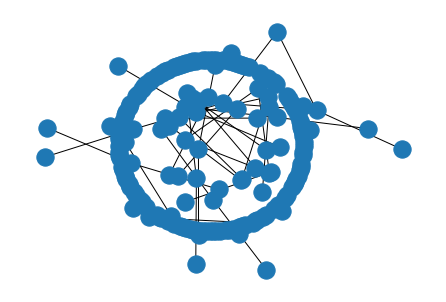

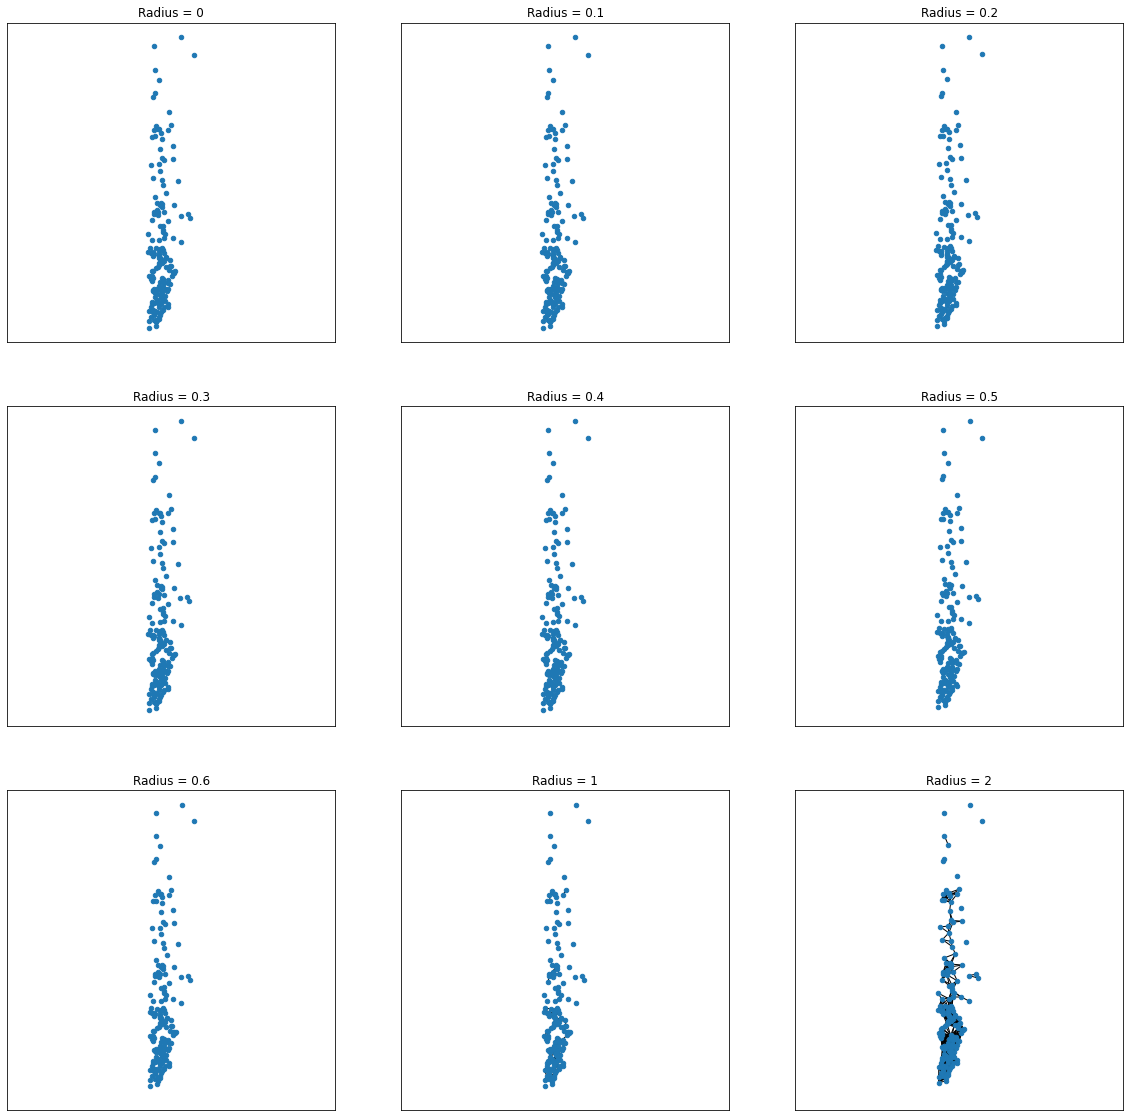

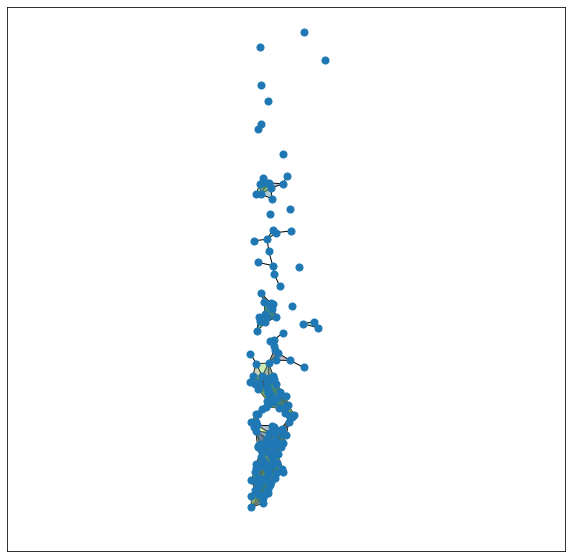

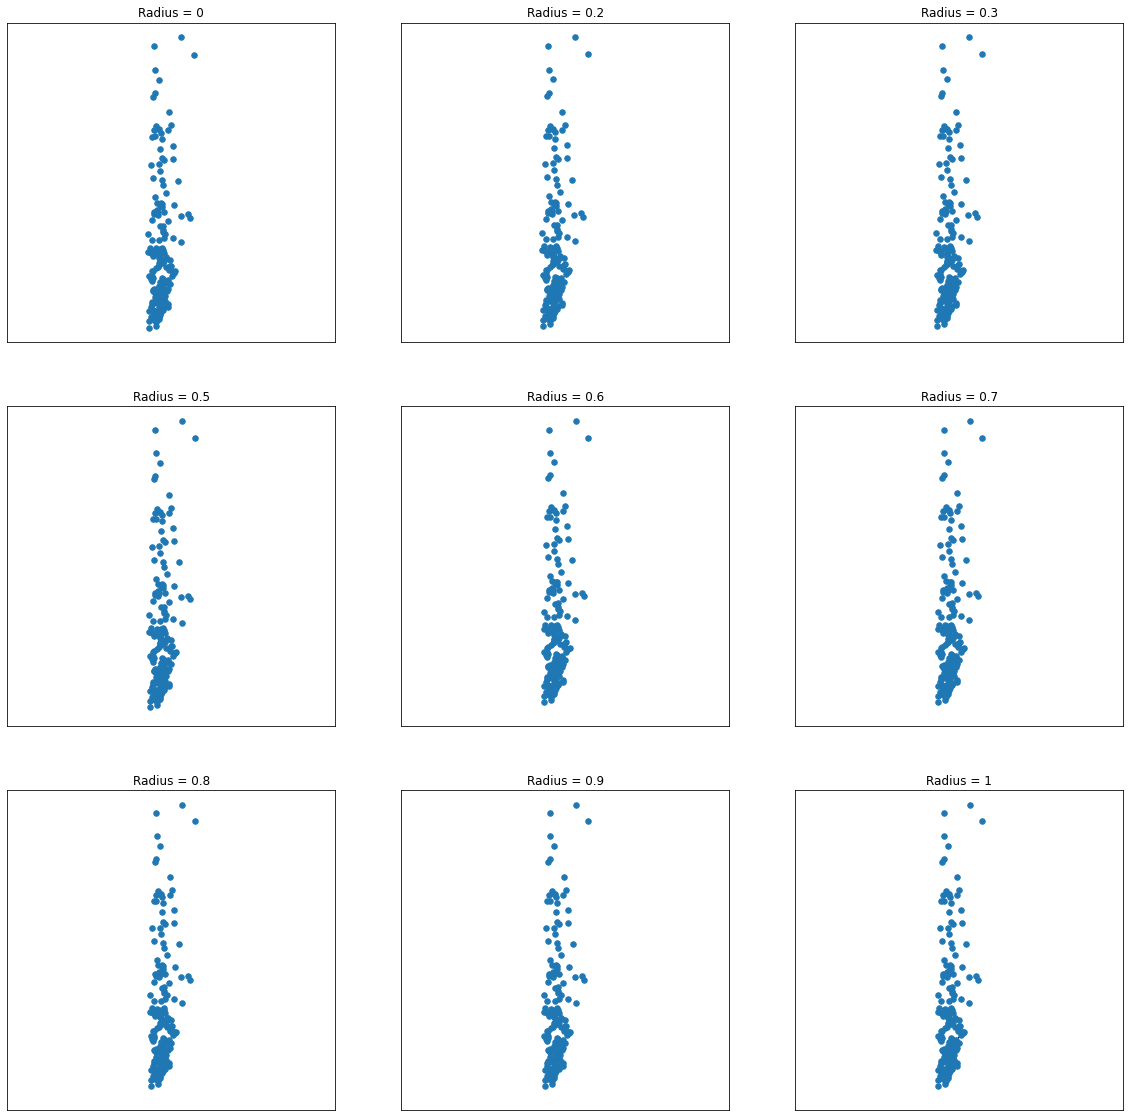

Number of Simplices: 41501


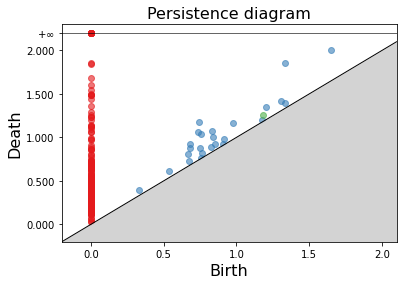

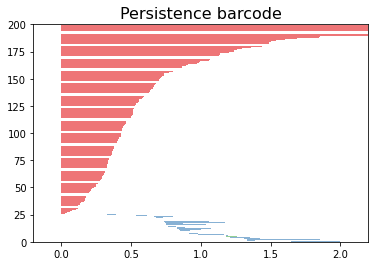

In [ ]:
lotsHomology('Spring', 'Temp', 'Prec')
print('---------------------------------------------------------')
lotsHomology('Spring', 'Temp', 'flow')
print('---------------------------------------------------------')
lotsHomology('Spring', 'Prec', 'flow')

#### Por años

In [11]:
def lotsHomologyY(year1, year2, var1, var2):
    f = df[(df['Year']>=year1)]
    f = f[f['Year'] < year2]
    f = f[[var1, var2]].to_numpy()
    D = pairwise_distances(f)

    r = .3
    G = create_simplicial_complex(D,r)
    nx.draw_kamada_kawai(G)

    rs = [0,0.1,0.2,0.3,0.4,0.5,0.6,1,2]
    pos = {n:f[n,:] for n in range(len(f))}

    plt.figure(figsize = (20,20))

    for (j,r) in enumerate(rs):
        G = create_simplicial_complex(D,r)
        plt.subplot(3,3,j+1)
        nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 20)
        plt.axis('equal')
        plt.title('Radius = '+str(r))

    plt.show()

    r = 1.5
    G, two_spx_list = create_2_dim_simplicial_complex(D,r)

    patches = []

    for i,spx in enumerate(two_spx_list):
        position_array = np.array([[pos[vert][0],pos[vert][1]] for vert in spx])
        polygon = Polygon(position_array, True)
        patches.append(polygon)

    fig, ax = plt.subplots(figsize = (10,10))

    nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 50)
    colors = 100*np.random.rand(len(patches))
    p = PatchCollection(patches, alpha=.15)
    p.set_array(np.array(colors))
    ax.add_collection(p)

    plt.axis('equal')
    plt.show()

    rs = [0,0.2,0.3,0.5,0.6,0.7,0.8,0.9,1]
    pos = {n:f[n,:] for n in range(len(f))}

    plt.figure(figsize = (20,20))

    for (j,r) in enumerate(rs):
        G, two_spx_list = create_2_dim_simplicial_complex(D,r)
        patches = []

        for i,spx in enumerate(two_spx_list):
            position_array = np.array([[pos[vert][0],pos[vert][1]] for vert in spx])
            polygon = Polygon(position_array, True)
            patches.append(polygon)
            
        ax = plt.subplot(3,3,j+1)
        nx.draw_networkx(G, pos = pos, with_labels = False,node_size = 30)
        colors = 100*np.random.rand(len(patches))
        p = PatchCollection(patches, alpha=0.05)
        p.set_array(np.array(colors))
        ax.add_collection(p)
        
        plt.axis('equal')
        plt.title('Radius = '+str(r))

    plt.show()

    skeleton = gd.RipsComplex(distance_matrix = D, max_edge_length = 2) 
    Rips_complex = skeleton.create_simplex_tree(max_dimension = 3)

    rips_filtration = Rips_complex.get_filtration()
    rips_list = list(rips_filtration)
    print('Number of Simplices:',len(rips_list))

    BarCodes = Rips_complex.persistence()
    gd.plot_persistence_diagram(BarCodes)
    plt.show()

    gd.plot_persistence_barcode(BarCodes)
    plt.show()

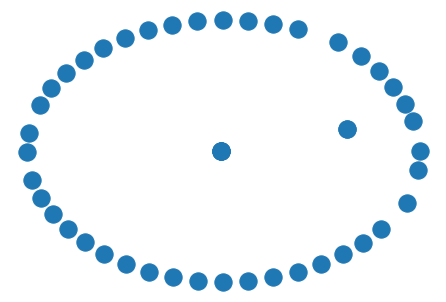

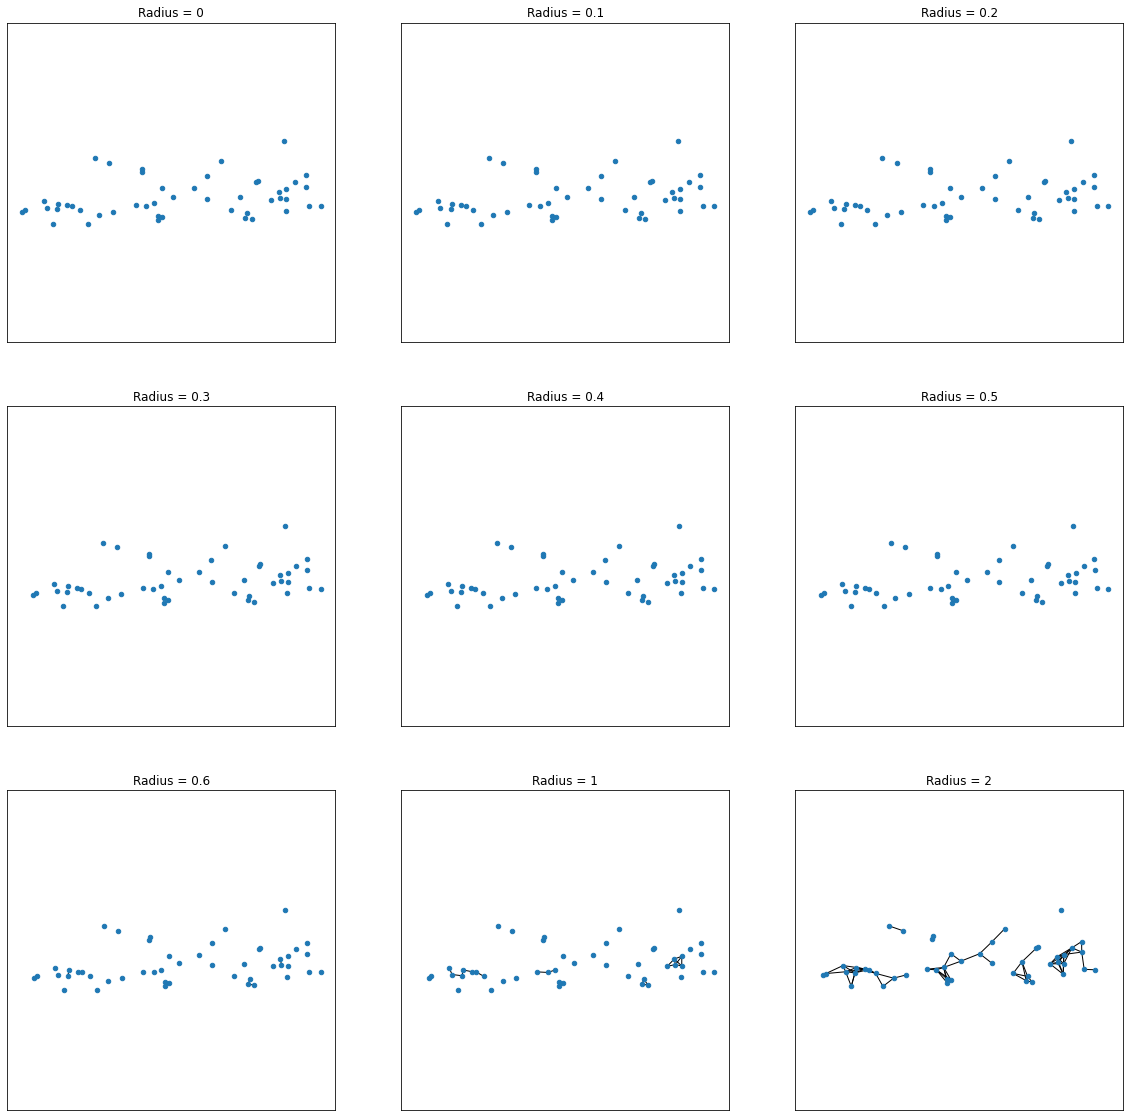

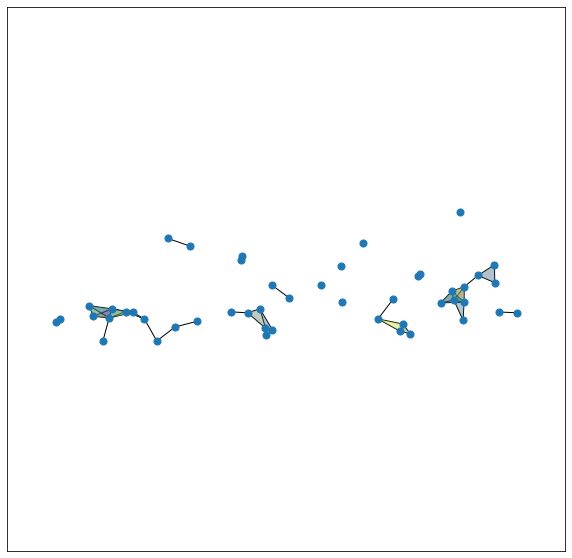

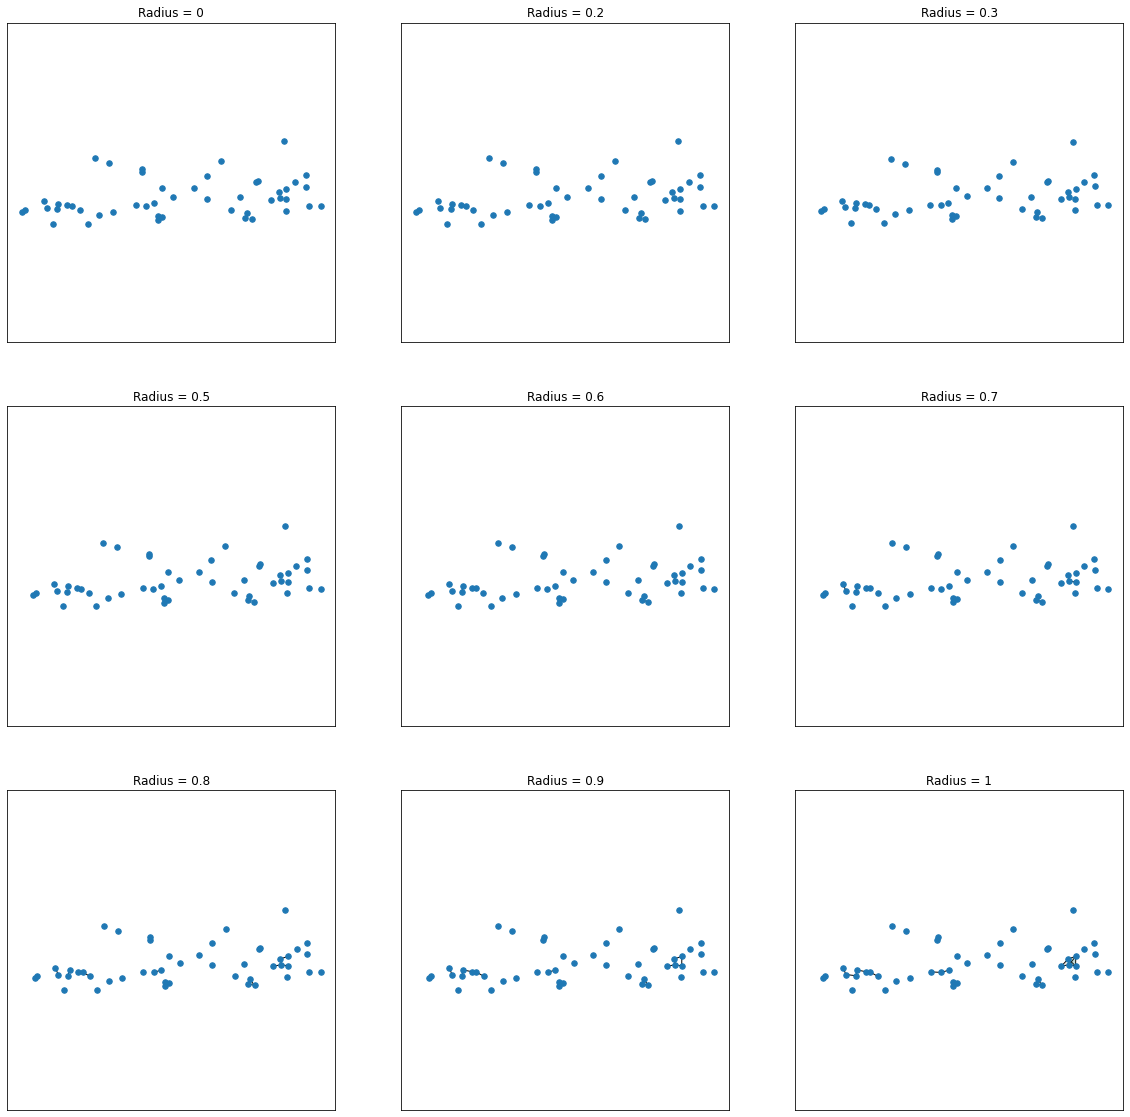

usetex mode requires TeX.


Number of Simplices: 222


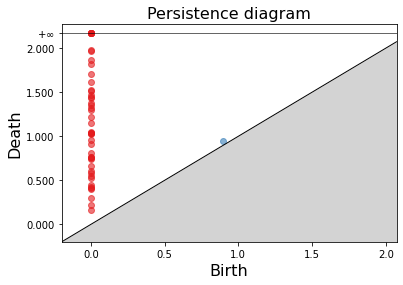

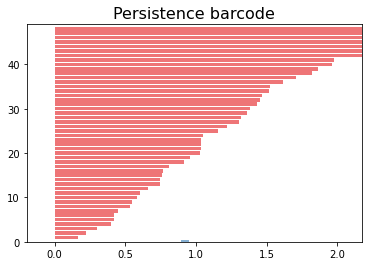

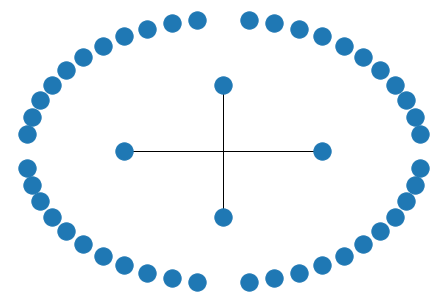

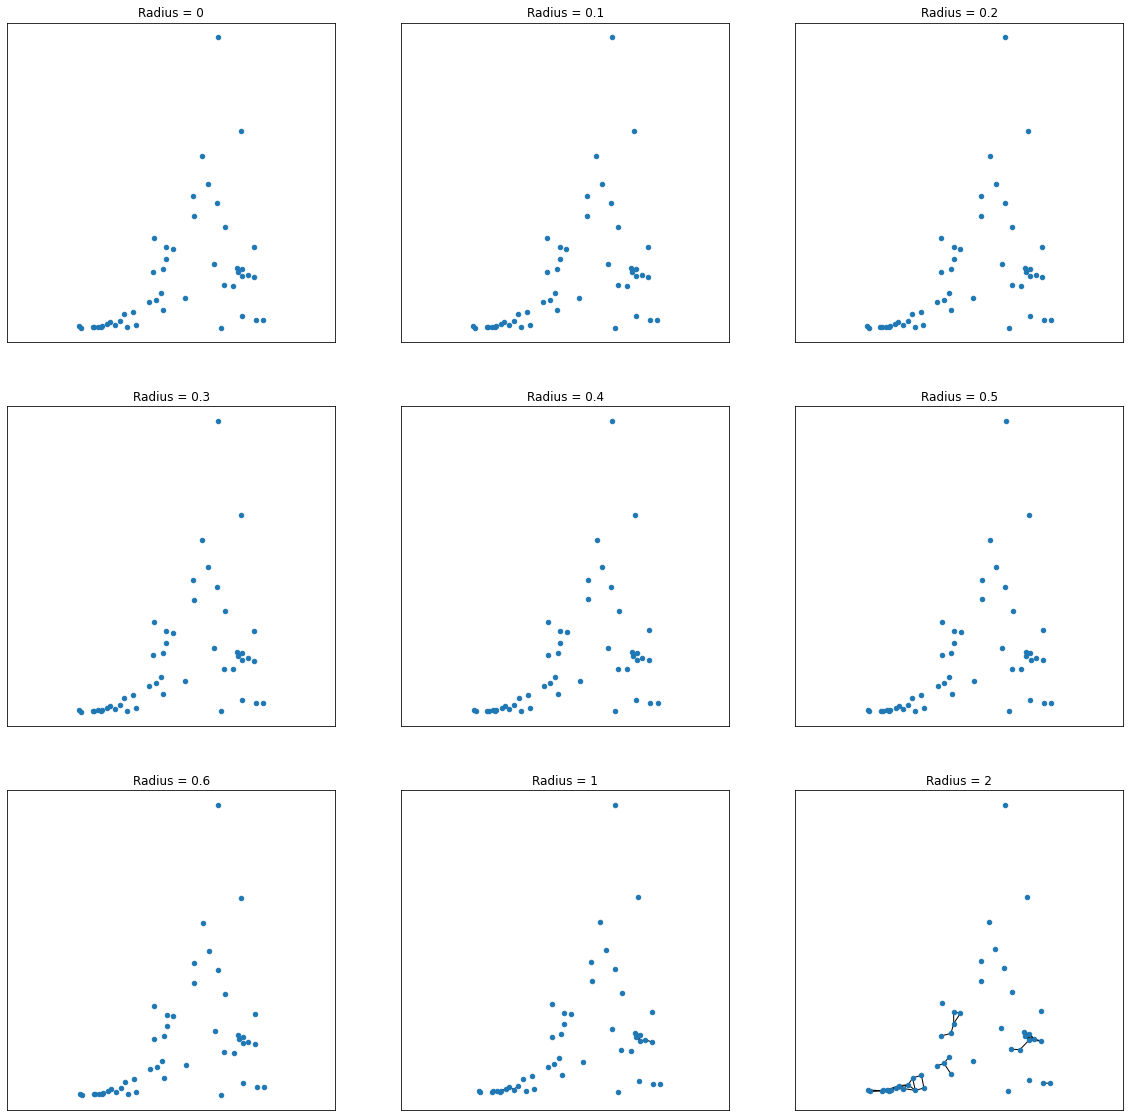

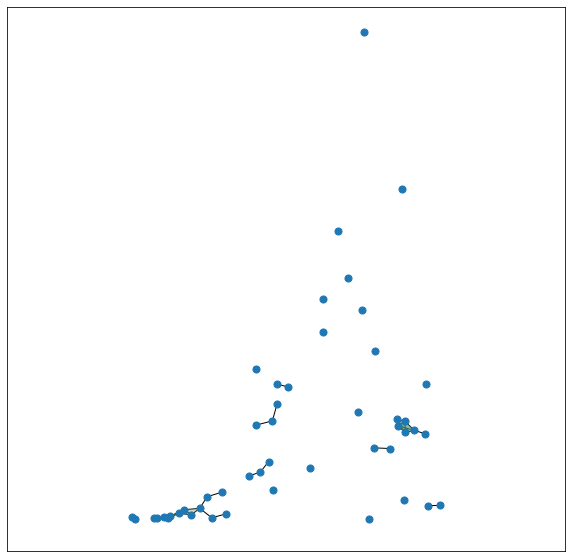

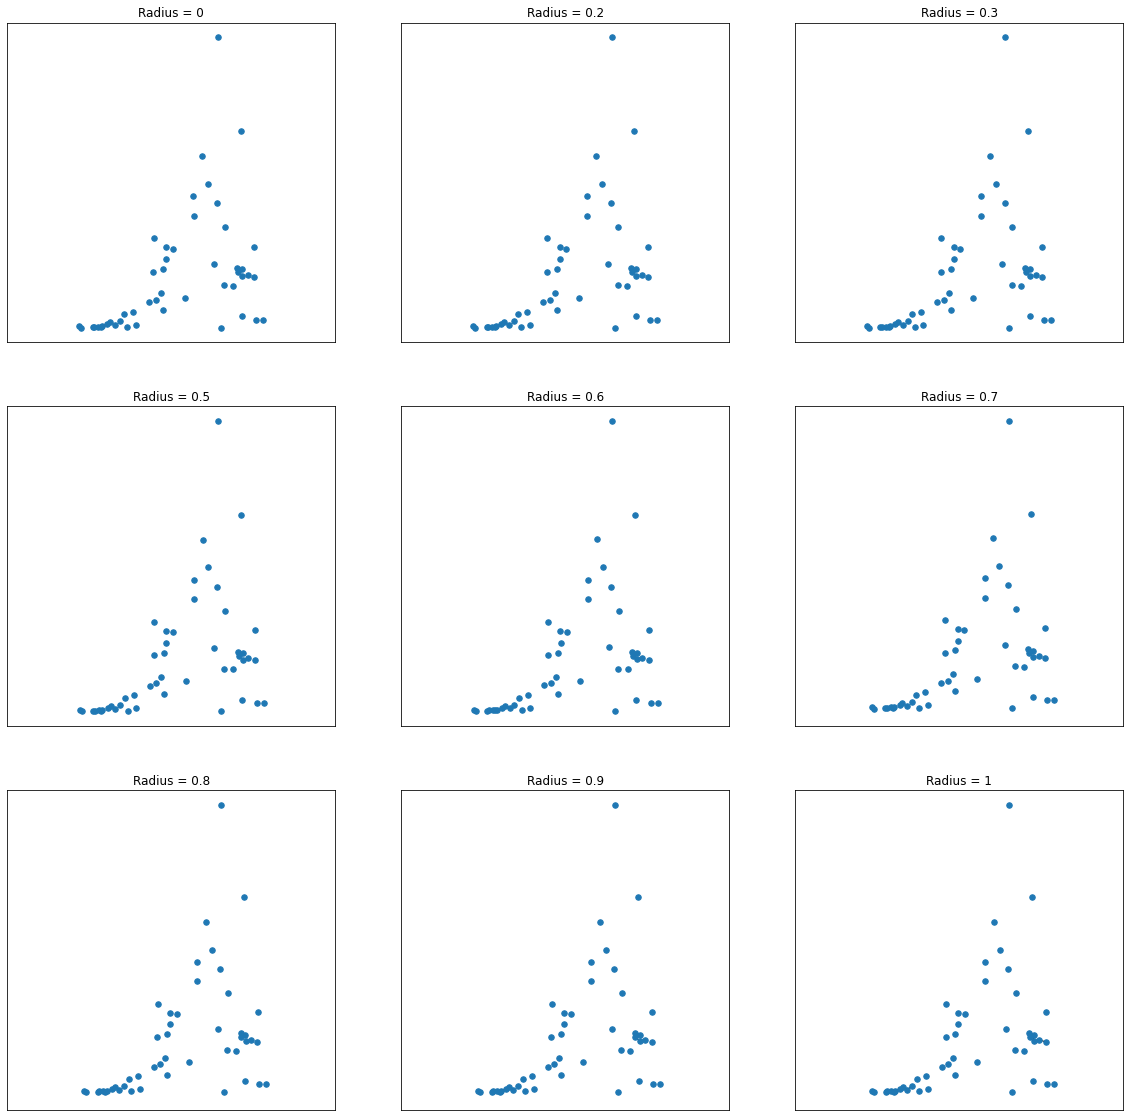

Number of Simplices: 170


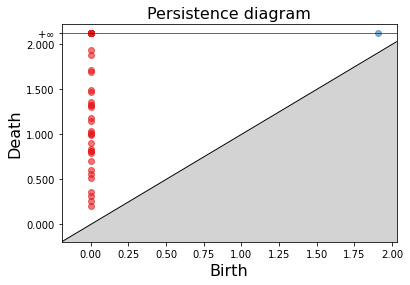

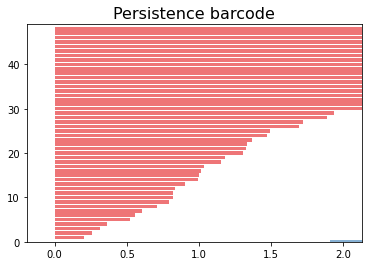

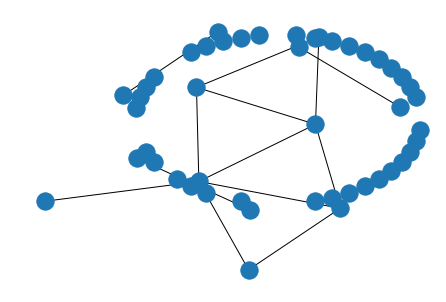

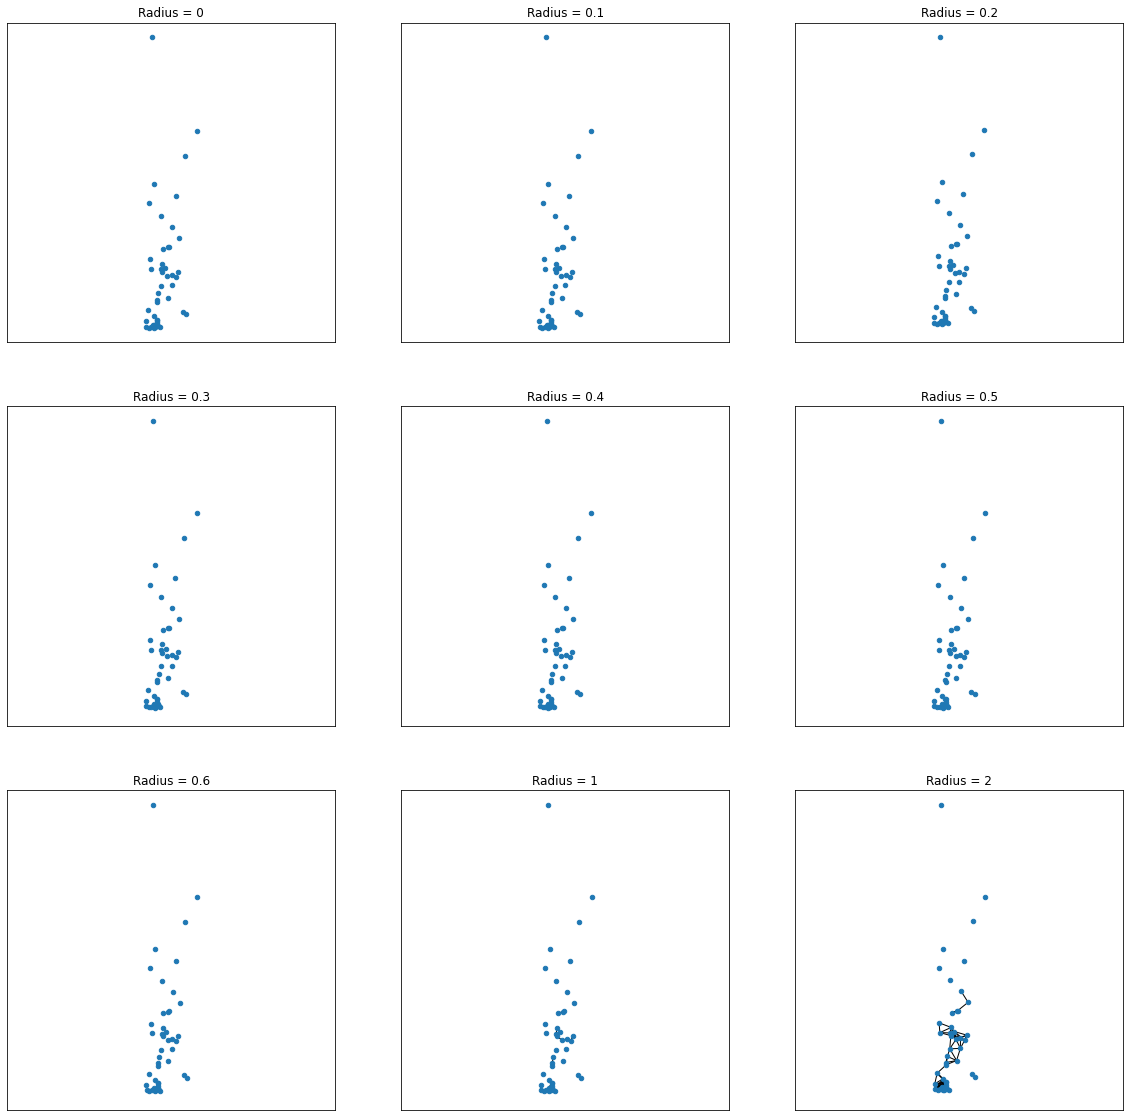

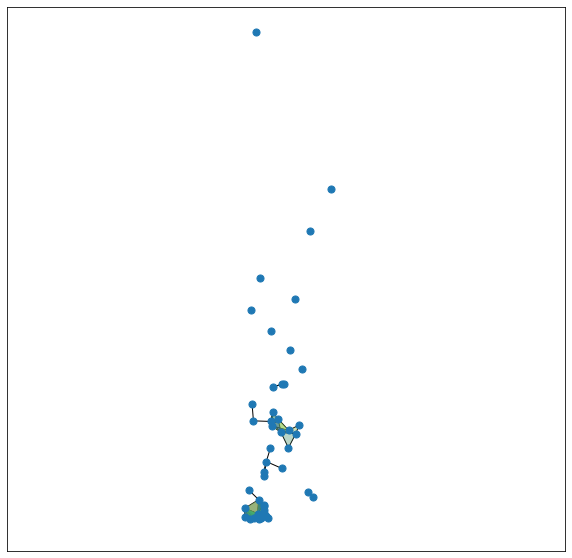

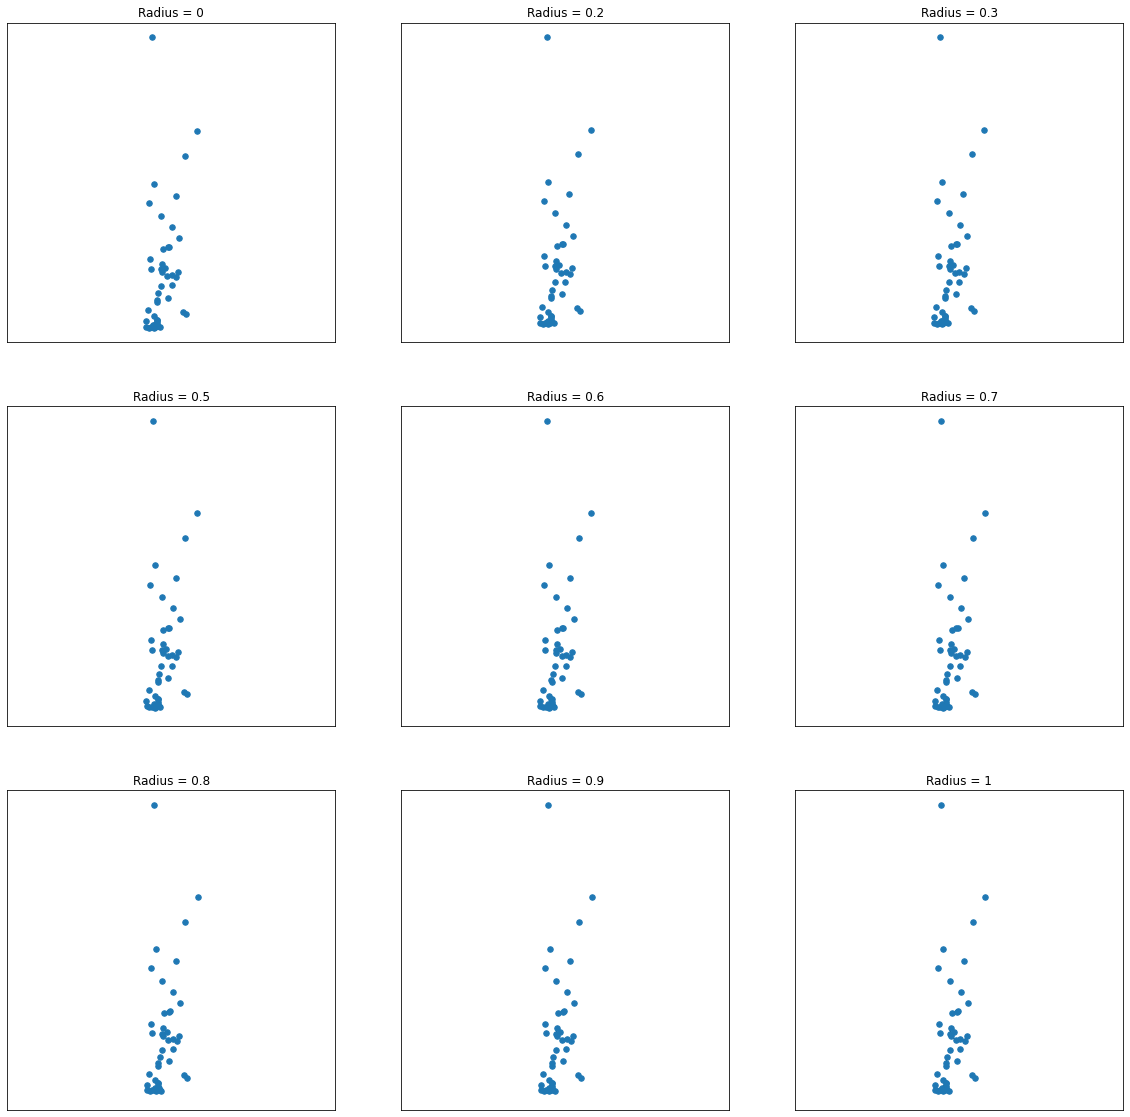

Number of Simplices: 3137


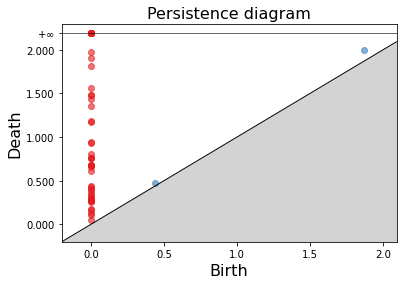

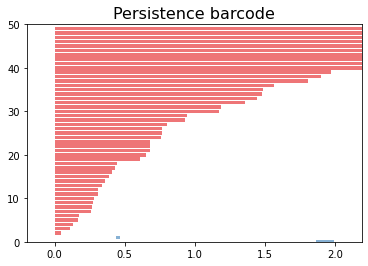

In [12]:
lotsHomologyY(1958,1962, 'Temp', 'Prec')
lotsHomologyY(1958,1962, 'Temp', 'flow')
lotsHomologyY(1958,1962, 'Prec', 'flow')

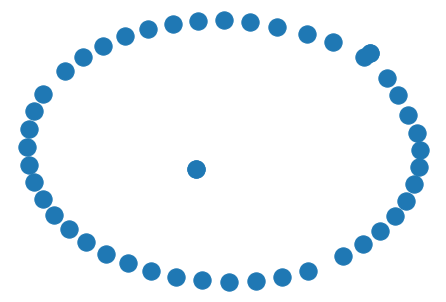

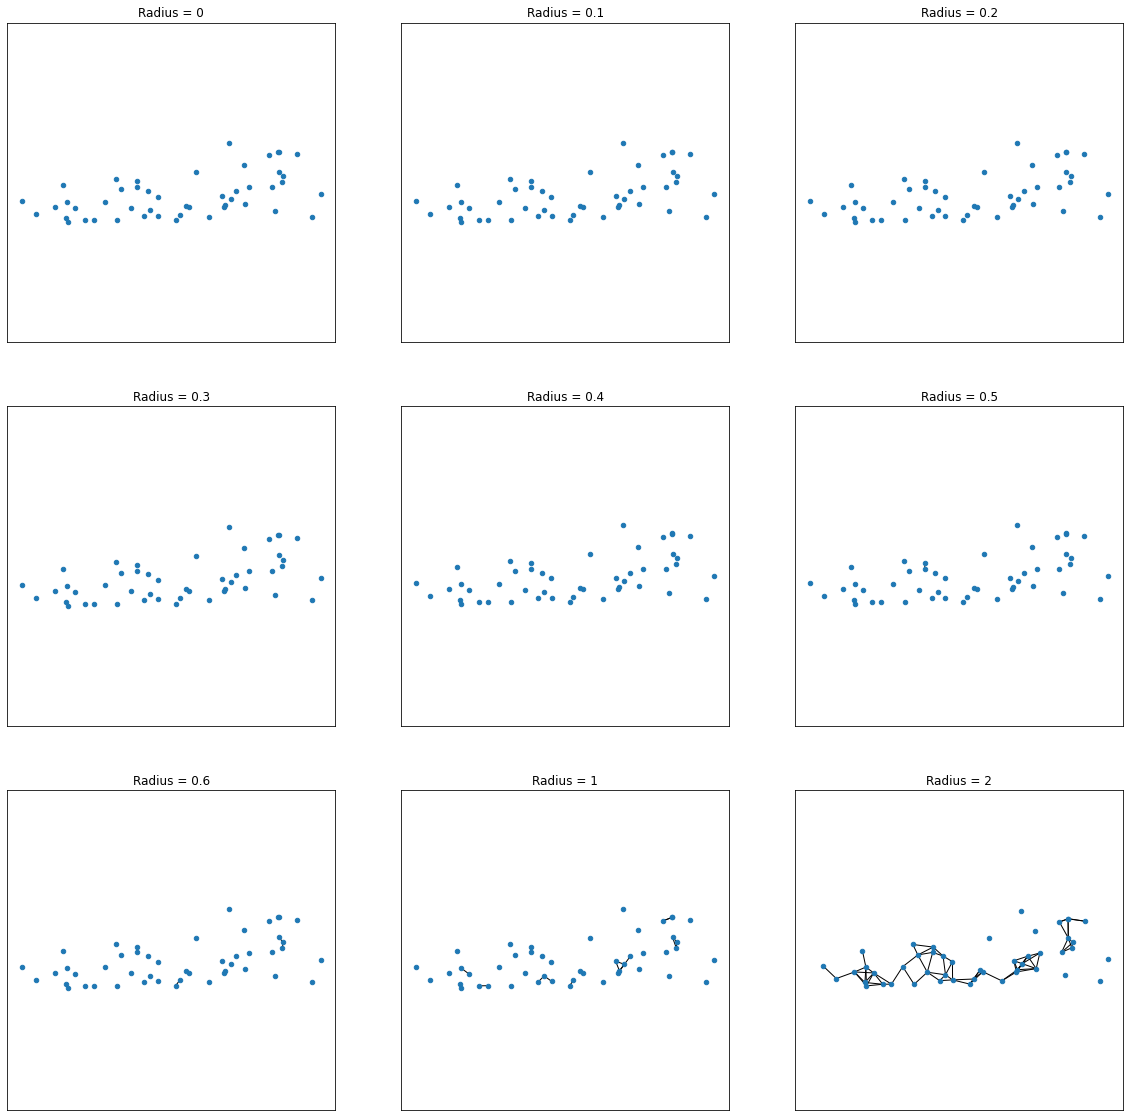

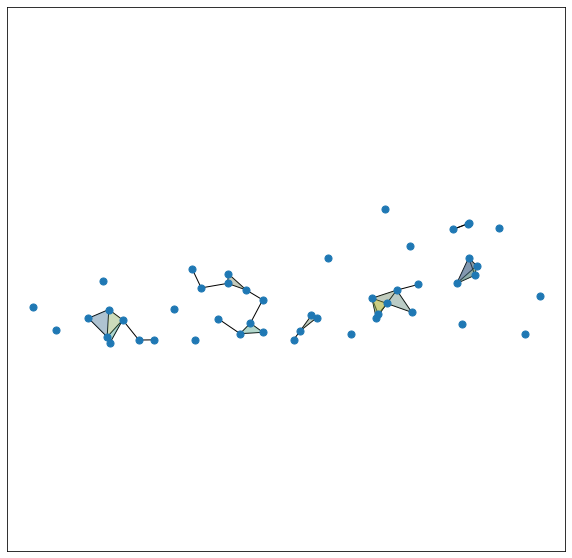

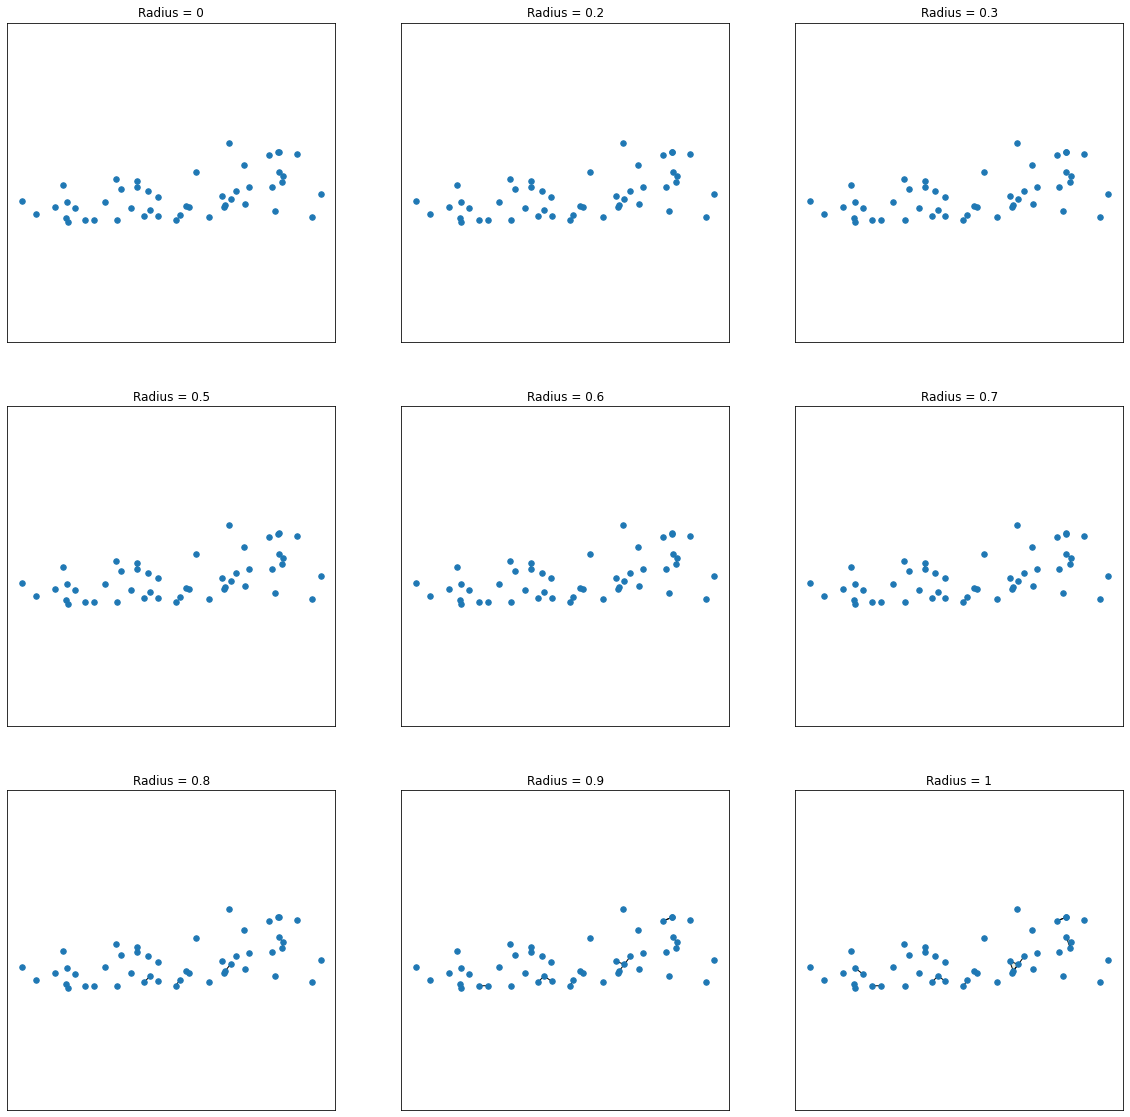

Number of Simplices: 205


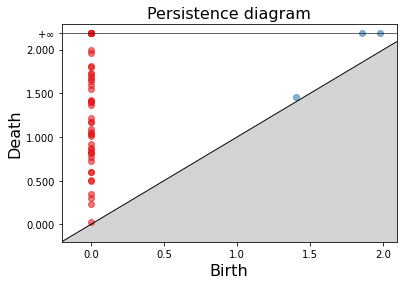

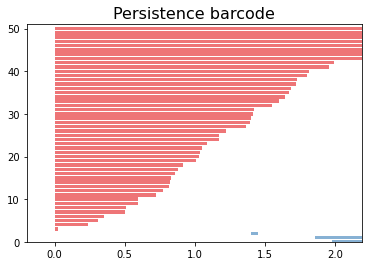

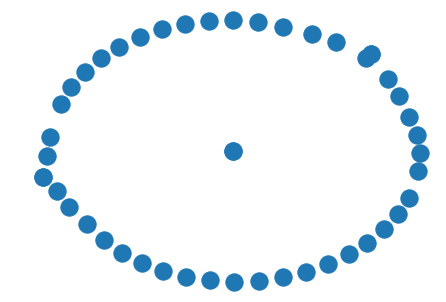

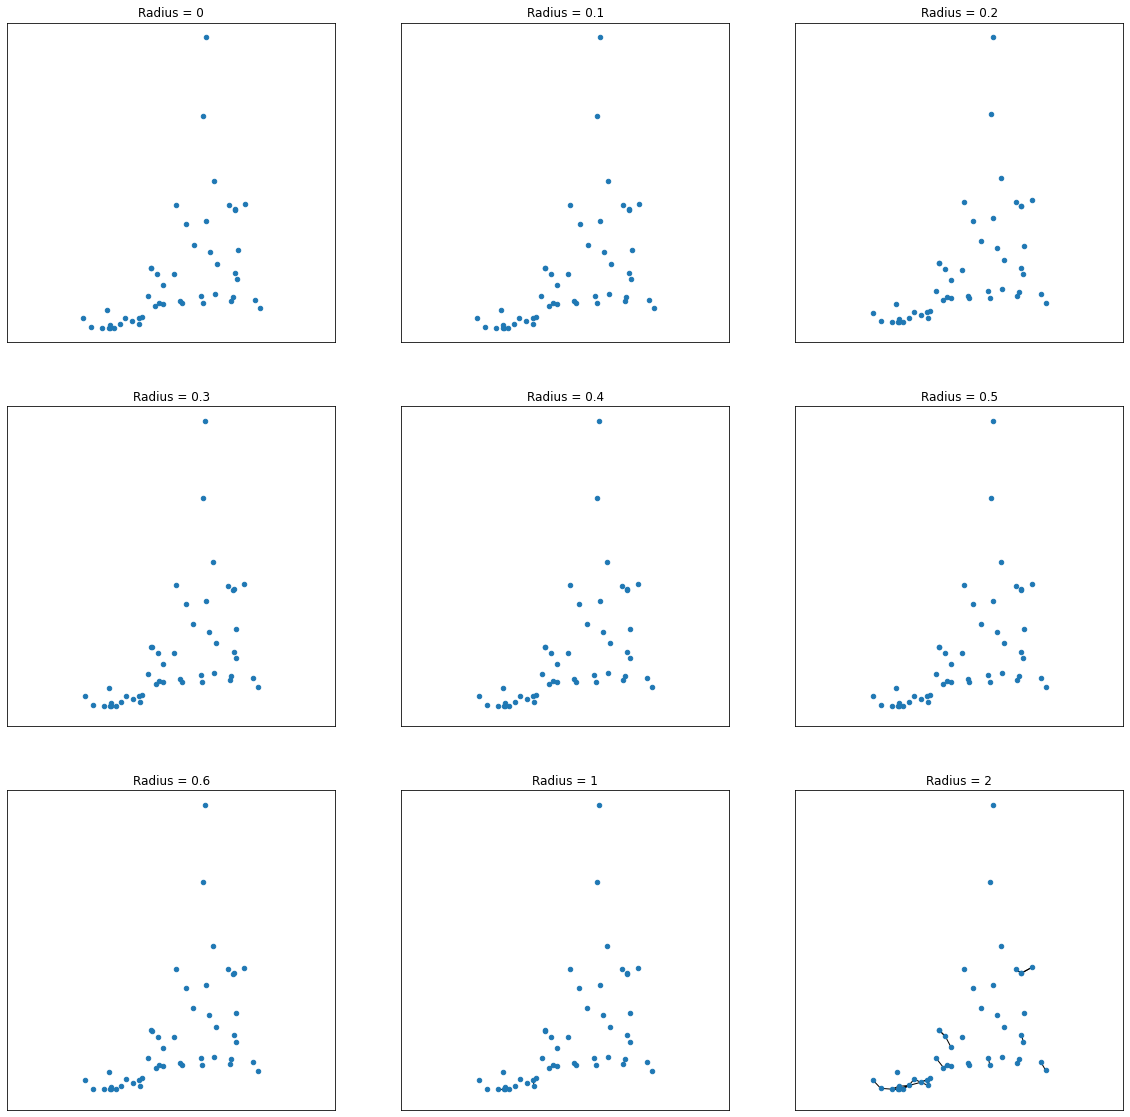

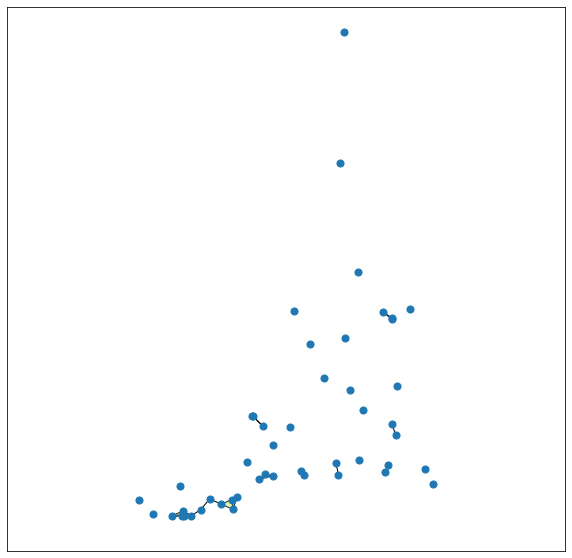

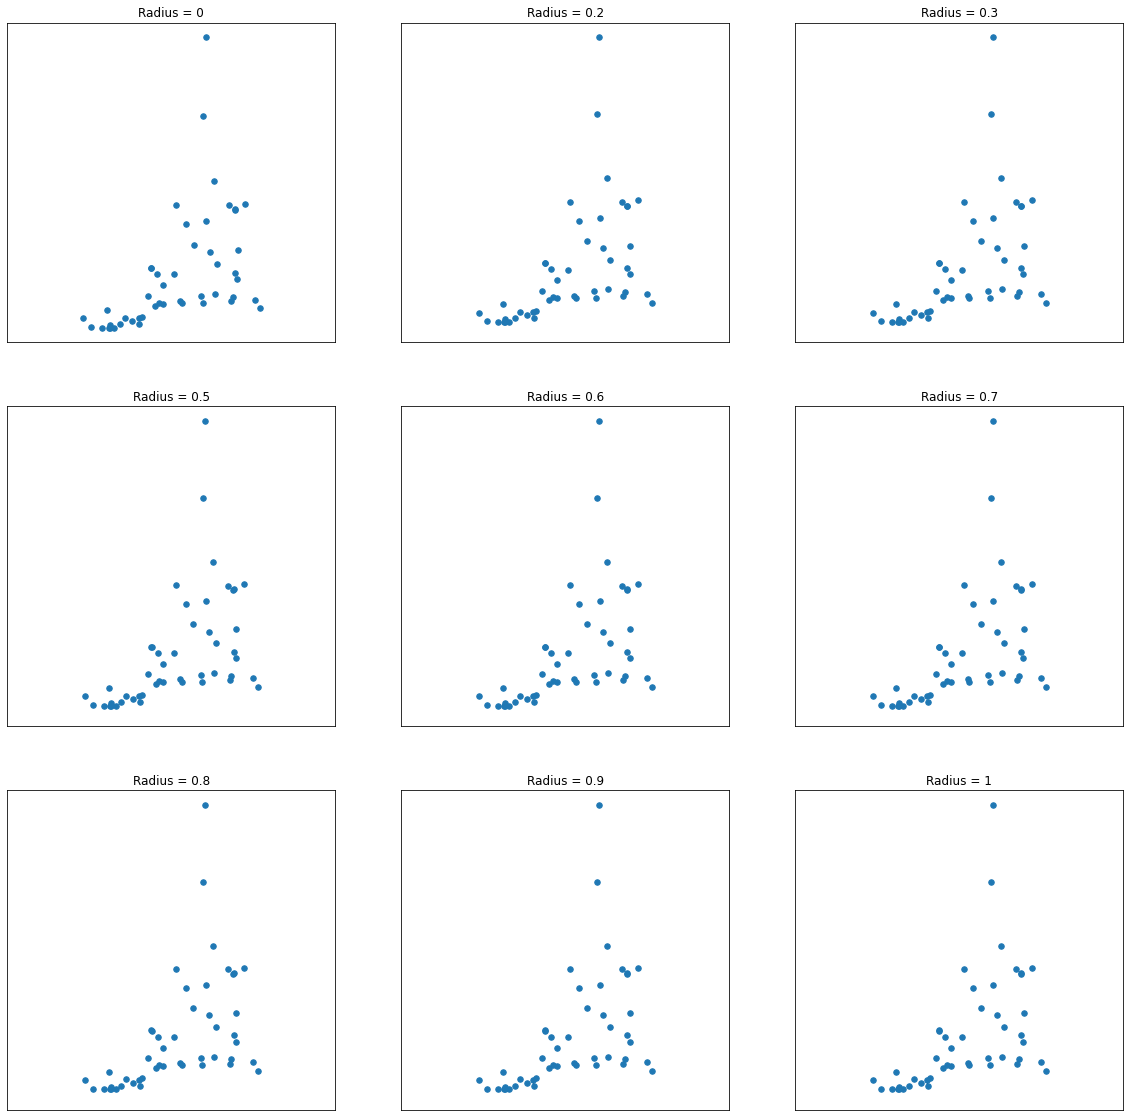

Number of Simplices: 126


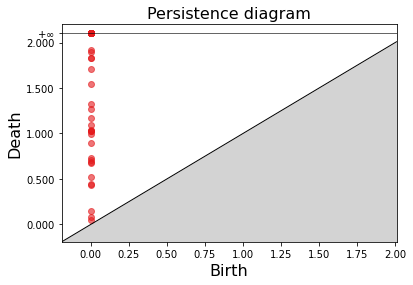

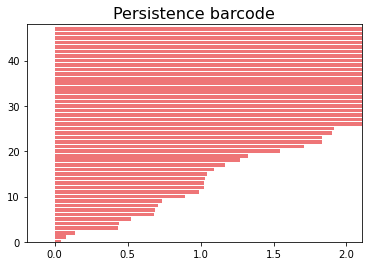

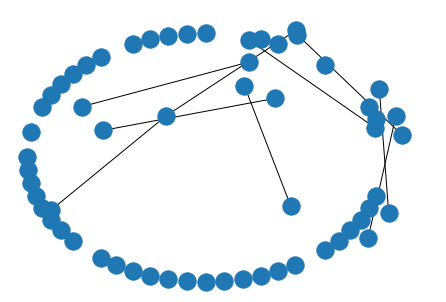

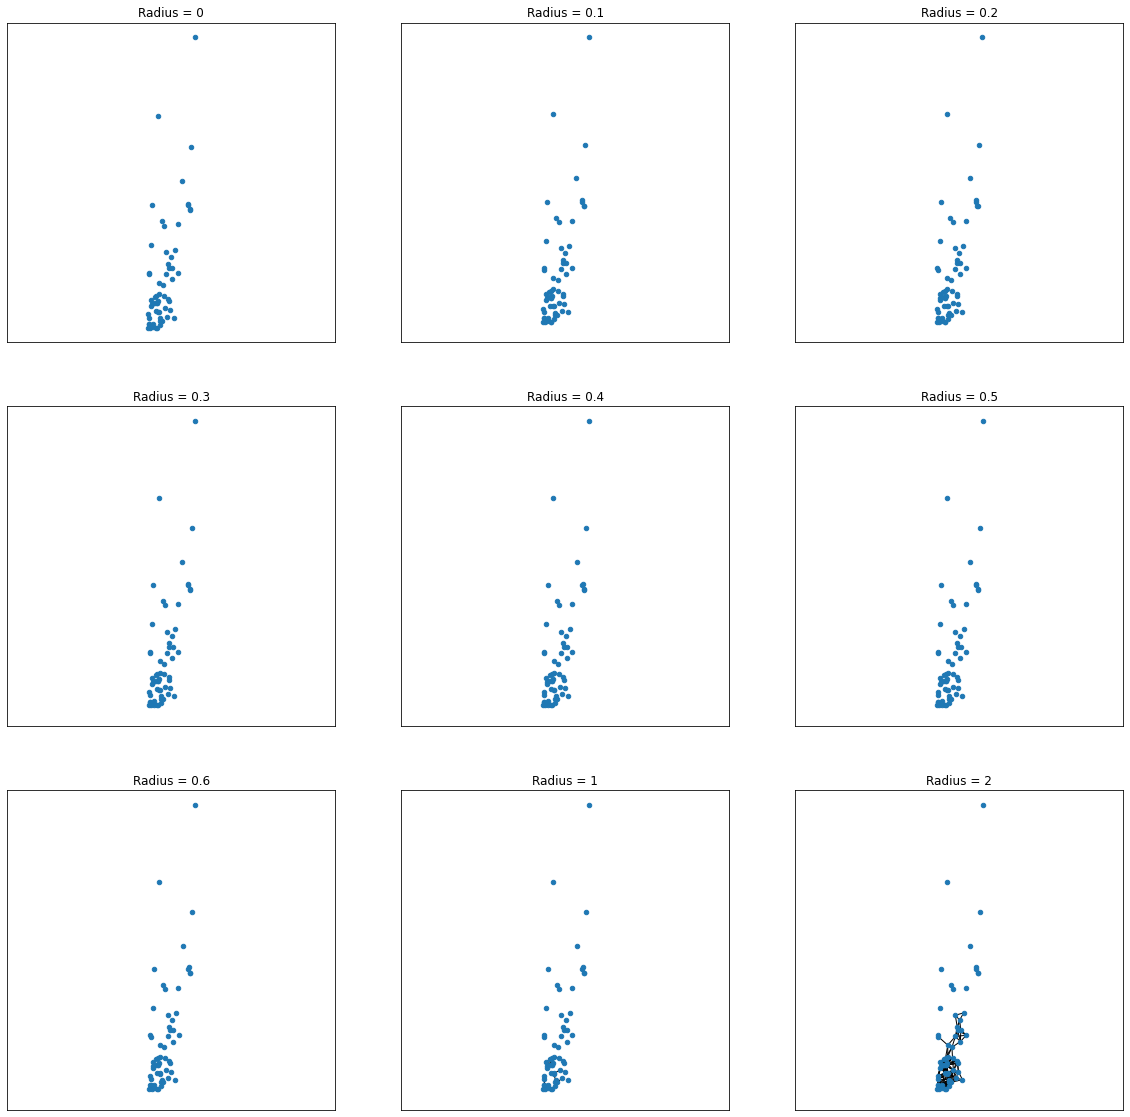

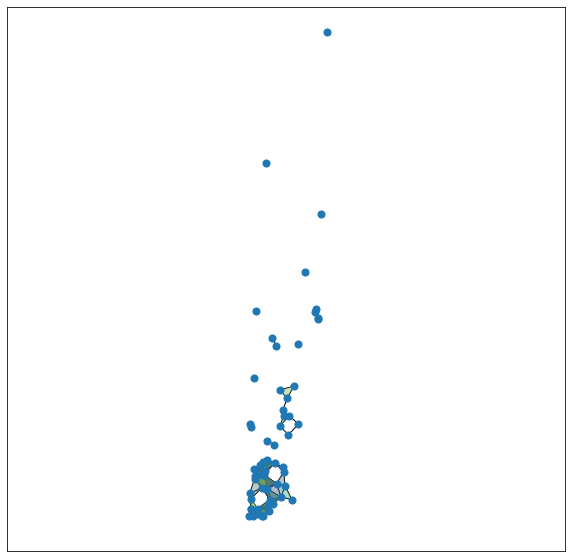

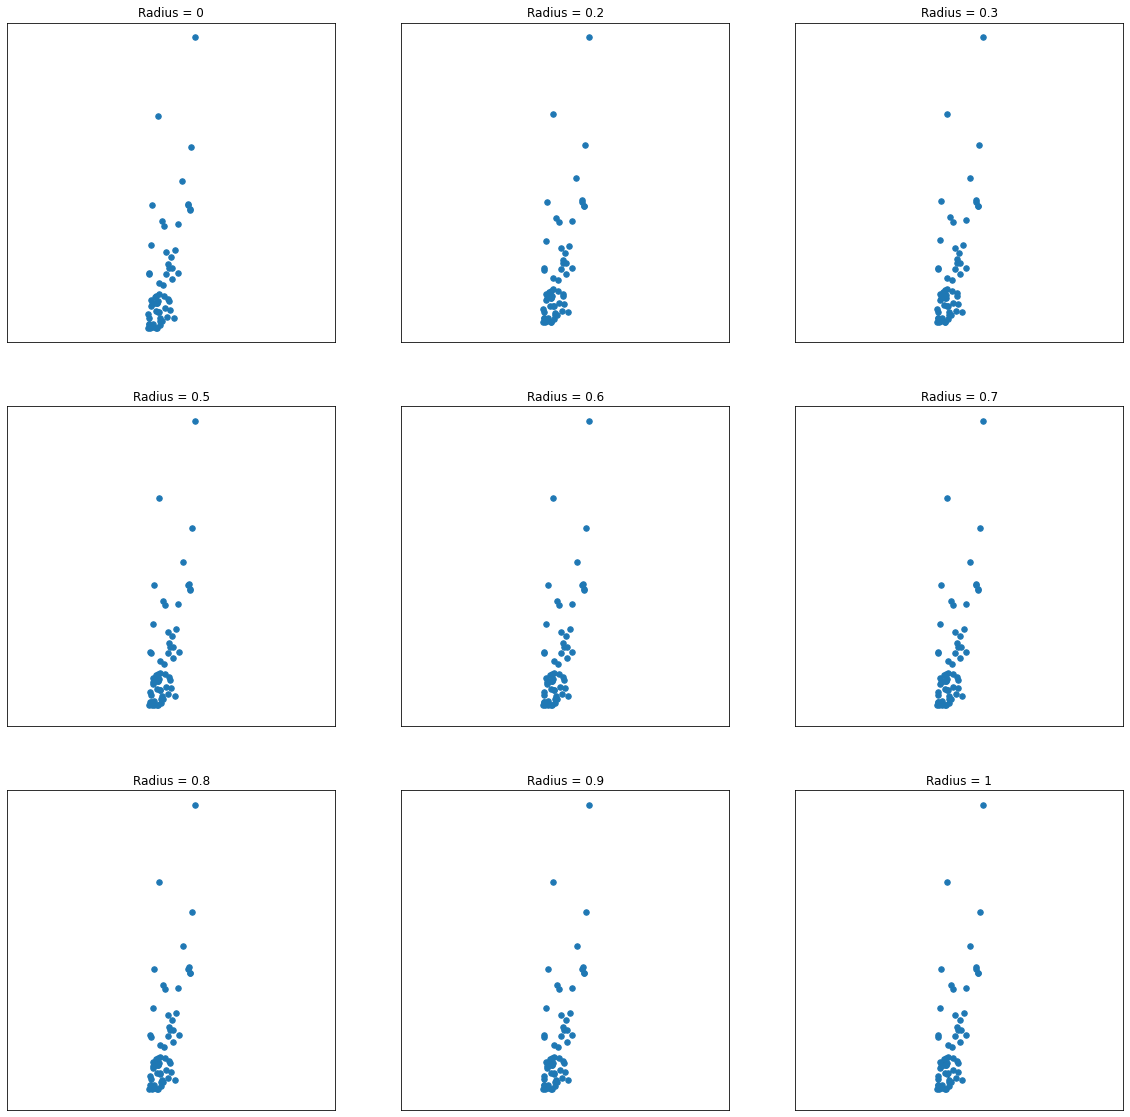

Number of Simplices: 2003


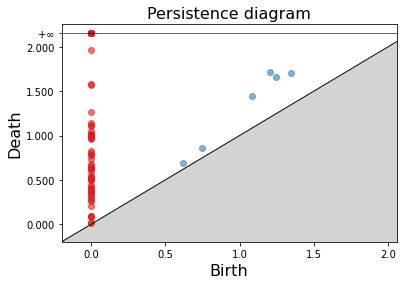

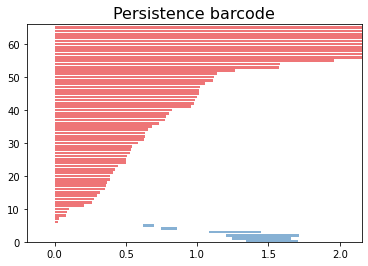

In [13]:
lotsHomologyY(2011,2015, 'Temp', 'Prec')
lotsHomologyY(2011,2015, 'Temp', 'flow')
lotsHomologyY(2011,2016, 'Prec', 'flow')